In [1]:
# ================================================
# 2. IMPORTING DEPENDENCIES
# ================================================
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

# TensorFlow & Keras (use tf.keras only)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import (
        Layer,
        Conv2D,
        Dense,
        MaxPooling2D,
        Input,
        Flatten,
    )
    from tensorflow.keras.metrics import Precision, Recall
    print("✅ TensorFlow imports successful!")
except Exception as e:
    print(f"❌ TensorFlow import failed: {e}")
    print("Run the fix steps above and retry.")

# ================================================
# 3. VERIFY INSTALLATION
# ================================================
# (This will now run without error)
print("TensorFlow version:", tf.__version__)
print("Eager execution enabled:", tf.executing_eagerly())
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

✅ TensorFlow imports successful!
TensorFlow version: 2.19.0
Eager execution enabled: True
Num GPUs Available: 0


In [8]:
# ================================================
# 3. SET GPU MEMORY GROWTH
# ================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Number of GPUs available:", len(gpus))
else:
    print("No GPUs detected. Running on CPU.")


No GPUs detected. Running on CPU.


In [2]:

# ================================================
# 4. SETTING UP FOLDER STRUCTURE
# ================================================
# Define base paths
BASE_PATH = r'C:\Projects\EDUFACE PROJECT'
DATA_PATH = os.path.join(BASE_PATH, 'data')

# Create directories
POS_PATH = os.path.join(DATA_PATH, 'positive')
NEG_PATH = os.path.join(DATA_PATH, 'negative')
ANC_PATH = os.path.join(DATA_PATH, 'anchor')

os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

print(f"✅ Directories created/verified:")
print(f"   Positive: {POS_PATH}")
print(f"   Negative: {NEG_PATH}")
print(f"   Anchor: {ANC_PATH}")



✅ Directories created/verified:
   Positive: C:\Projects\EDUFACE PROJECT\data\positive
   Negative: C:\Projects\EDUFACE PROJECT\data\negative
   Anchor: C:\Projects\EDUFACE PROJECT\data\anchor


In [6]:
# ================================================
# 5. EXTRACT LFW DATASET FOR NEGATIVES
# ================================================
import tarfile
import glob

# Path to LFW .tgz file
tgz_path = os.path.join(BASE_PATH, 'lfw-funneled.tgz')
extract_path = NEG_PATH

# Validate and extract
if os.path.isfile(tgz_path):
    print(f"Found .tgz file at: {tgz_path}")
    os.makedirs(extract_path, exist_ok=True)
    
    with tarfile.open(tgz_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)
    print("✅ Dataset extracted successfully!")
    
    # Find LFW root
    possible_roots = [
        os.path.join(extract_path, "lfw_funneled"),
        os.path.join(extract_path, "lfw-funneled"),
        os.path.join(extract_path, "lfw"),
    ]
    lfw_root = next((root for root in possible_roots if os.path.exists(root)), None)
    
    if lfw_root:
        print(f"✅ LFW dataset at: {lfw_root}")
        # Move images to negative folder (flatten structure)
        for person_dir in os.listdir(lfw_root):
            person_path = os.path.join(lfw_root, person_dir)
            if os.path.isdir(person_path):
                for img_file in os.listdir(person_path):
                    src = os.path.join(person_path, img_file)
                    dst = os.path.join(NEG_PATH, img_file)
                    if os.path.exists(dst):
                        os.remove(dst)  # Overwrite duplicates
                    os.rename(src, dst)
        # Clean up empty dirs (note: may need to remove lfw_root if empty)
        print("✅ Negatives moved and structure flattened.")
    else:
        print("⚠️ Could not find LFW root. Check extraction.")
else:
    print("⚠️ LFW .tgz not found. Download from http://vis-www.cs.umass.edu/lfw/")




Found .tgz file at: C:\Projects\EDUFACE PROJECT\lfw-funneled.tgz
✅ Dataset extracted successfully!
✅ LFW dataset at: C:\Projects\EDUFACE PROJECT\data\negatives\lfw_funneled
✅ Negatives moved and structure flattened.


In [11]:
# ================================================
# 6. COLLECT POSITIVES AND ANCHORS
# ================================================
# Advanced multi-angle face capture with student info
import time
import uuid
import platform
import glob

def find_working_webcam(max_index=10):
    backends = [None]
    if platform.system() == "Windows":
        backends.extend([cv2.CAP_DSHOW, cv2.CAP_MSMF])
    elif platform.system() == "Linux":
        backends.append(cv2.CAP_V4L2)
    
    for backend in backends:
        for index in range(max_index):
            cap = cv2.VideoCapture(index, backend) if backend else cv2.VideoCapture(index)
            if cap.isOpened():
                ret, _ = cap.read()
                if ret:
                    return cap, index
                cap.release()
    return None, None

# Get student details
student_name = input("Enter student name: ").strip().replace(" ", "_")
student_id = input("Enter school ID: ").strip().replace('<>:"/\\|?*', '_')

print(f"\n📁 Saving images for {student_name}_{student_id}")
print(f"   Anchor: {ANC_PATH}")
print(f"   Positive: {POS_PATH}")

# Initialize counters
def get_next_count(folder_path, prefix):
    existing = glob.glob(os.path.join(folder_path, f"{prefix}_*.jpg"))
    if existing:
        counts = [int(os.path.basename(f).split('_')[2]) for f in existing if len(os.path.basename(f).split('_')) > 2 and os.path.basename(f).split('_')[2].isdigit()]
        return max(counts) + 1 if counts else 1
    return 1

anchor_count = get_next_count(ANC_PATH, f"{student_name}_{student_id}")
positive_count = get_next_count(POS_PATH, f"{student_name}_{student_id}")

# Load Haar Cascades for multi-angle detection
cascades = {}
cascade_files = {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}

for name, file in cascade_files.items():
    cascade_path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(cascade_path)
    if not cascade.empty():
        cascades[name] = cascade
        print(f"✅ Loaded {name} cascade")

def detect_faces_multi(gray):
    all_faces = []
    types = []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neighbors = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neighbors, minSize=(30, 30))
        for face in faces:
            all_faces.append(face)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, threshold=0.3):
    if len(faces) <= 1:
        return faces, types
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]: continue
        for j in range(i+1, len(faces)):
            if not keep[j]: continue
            # Calculate IoU
            x1, y1, w1, h1 = faces[i]
            x2, y2, w2, h2 = faces[j]
            inter_x = max(0, min(x1+w1, x2+w2) - max(x1, x2))
            inter_y = max(0, min(y1+h1, y2+h2) - max(y1, y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter / union if union > 0 else 0
            if iou > threshold:
                # Keep larger face
                if w1*h1 >= w2*h2:
                    keep[j] = False
                else:
                    keep[i] = False
                    break
    return [faces[i] for i in range(len(faces)) if keep[i]], [types[i] for i in range(len(types)) if keep[i]]

# Initialize capture
cap, index = find_working_webcam()
if cap is None:
    raise ValueError("No webcam found.")

capture_type = "positive"
is_capturing = False

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces, face_types = detect_faces_multi(gray)
        faces, face_types = remove_overlaps(faces, face_types)

        colors = {'frontal': (0,255,0), 'profile': (255,0,0), 'frontal_alt': (0,255,255), 'frontal_alt2': (255,0,255)}
        for i, (x,y,w,h) in enumerate(faces):
            ft = face_types[i] if i < len(face_types) else 'frontal'
            color = colors.get(ft, (0,255,0))
            cv2.rectangle(frame, (x,y), (x+w,y+h), color, 2)
            cv2.putText(frame, ft.replace('_',' ').title(), (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        status = f"Mode: {capture_type.upper()} | Faces: {len(faces)} | {'CAPTURING' if is_capturing else 'PAUSED'}"
        cv2.putText(frame, status, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
        count_text = f"Anchor: {anchor_count-1} | Positive: {positive_count-1}"
        cv2.putText(frame, count_text, (10,60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

        cv2.imshow("EDUFACE Capture - 'a' anchor, 'p' positive, 'c' hold to capture, 'q' quit", frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('a'):
            capture_type = 'anchor'
            print("🔄 ANCHOR mode")
        elif key == ord('p'):
            capture_type = 'positive'
            print("🔄 POSITIVE mode")
        elif key == ord('c'):
            is_capturing = not is_capturing  # Toggle
            print(f"{'Start' if is_capturing else 'Stop'} capturing")
        elif key == ord('q'):
            break

        if is_capturing and faces:
            folder = ANC_PATH if capture_type == 'anchor' else POS_PATH
            count = anchor_count if capture_type == 'anchor' else positive_count
            prefix = f"{student_name}_{student_id}"
            
            for i, (x,y,w,h) in enumerate(faces):
                face_crop = frame[y:y+h, x:x+w]
                ft = face_types[i] if i < len(face_types) else 'frontal'
                angle = ft.replace('frontal','front').replace('_alt','').replace('_alt2','')
                unique_id = str(uuid.uuid4())[:8]
                filename = os.path.join(folder, f"{prefix}_{angle}_{count}_{unique_id}.jpg")
                resized = cv2.resize(face_crop, (250, 250))  # Capture at 250x250
                cv2.imwrite(filename, resized)
                print(f"✅ Saved {os.path.basename(filename)} ({ft}, {capture_type})")
                
                if capture_type == 'anchor':
                    anchor_count += 1
                else:
                    positive_count += 1
            
            time.sleep(0.2)  # Rate limit

finally:
    cap.release()
    cv2.destroyAllWindows()

# Dataset summary
total_anchor = len(glob.glob(os.path.join(ANC_PATH, "*.jpg")))
total_positive = len(glob.glob(os.path.join(POS_PATH, "*.jpg")))
total_negative = len(glob.glob(os.path.join(NEG_PATH, "*.jpg")))

print(f"\n📊 Dataset Summary:")
print(f"   Anchor: {total_anchor}")
print(f"   Positive: {total_positive}")
print(f"   Negative: {total_negative}")

if total_anchor < 10 or total_positive < 10:
    print("⚠️ WARNING: Collect more images (10+ per class) for better performance.")



📁 Saving images for _
   Anchor: C:\Projects\EDUFACE PROJECT\data\anchor
   Positive: C:\Projects\EDUFACE PROJECT\data\positive
✅ Loaded frontal cascade
✅ Loaded profile cascade
✅ Loaded frontal_alt cascade
✅ Loaded frontal_alt2 cascade

📊 Dataset Summary:
   Anchor: 2845
   Positive: 2671
   Negative: 13966


Raw counts: Anchor=2845, Positive=2671, Negative=13966

🔍 Testing filename parser on samples:
  Bahati_Jere_150166_front2_108_e207b004.jpg... → Bahati_Jere
  Bahati_Jere_150166_front2_116_25685cfa.jpg... → Bahati_Jere
  Bahati_Jere_150166_front2_118_98eeaa79.jpg... → Bahati_Jere
  Bahati_Jere_150166_front2_103_ffa1ccbd.jpg... → Bahati_Jere
  Bahati_Jere_150166_front2_104_42bbb890.jpg... → Bahati_Jere
  Bahati_Jere_150166_front2_108_067c3cc8.jpg... → Bahati_Jere

📊 Found 1 unique student prefixes in samples

📂 Grouping results:
   Students in anchors: 12
   Students in positives: 12

👥 Sample student image counts:
   1. Bahati_Jere: 268 anchors, 283 positives
   2. Benjamin_151541: 175 anchors, 197 positives
   3. Elvis_151343: 105 anchors, 224 positives
   4. Latasha_Kariuki: 150 anchors, 185 positives
   5. Leila_131456: 192 anchors, 174 positives

✅ Valid students with ≥1 images each: 12
   Valid students: ['Bahati_Jere', 'Benjamin_151541', 'chalo_151344', 'dennis_151354', 'Elvis_151

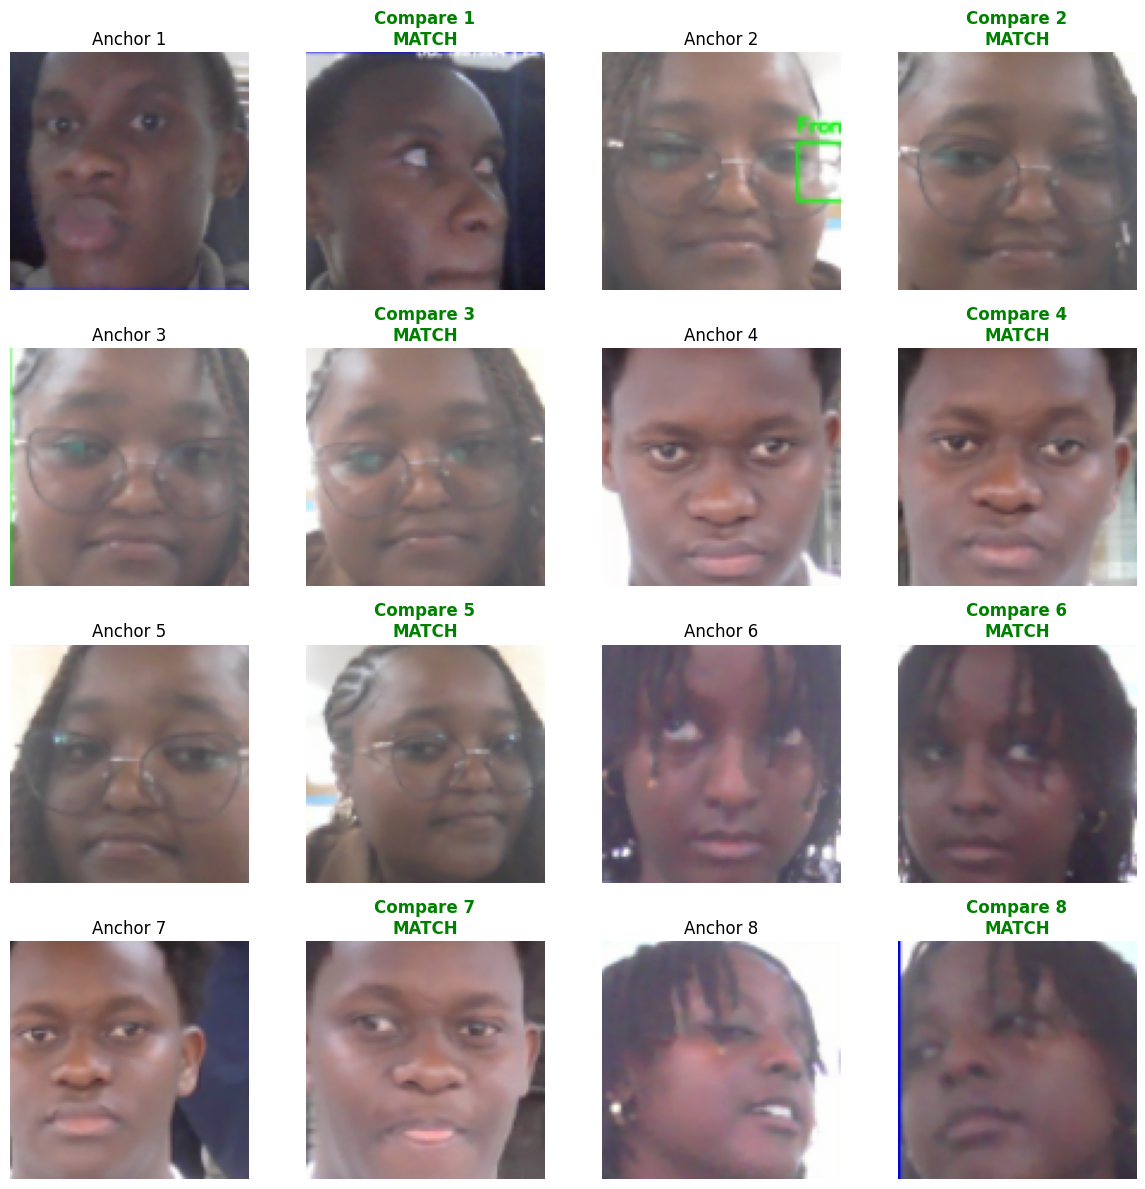

✅ Saved to C:\Projects\EDUFACE PROJECT/sample_training_batch.png

🎉 Ready for training!


In [15]:
# ================================================
# 7. LOAD AND PREPROCESS IMAGES (FULLY CORRECTED + ROBUST PARSING)
# ================================================
import glob
import re
import random
import numpy as np
from collections import defaultdict

# Define preprocess function for single image
def preprocess(file_path):
    # Convert tensor to string if needed (ensures compatibility)
    file_path = tf.strings.as_string(file_path)
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    img = tf.image.resize(img, (100, 100))
    img = tf.image.random_crop(img, [90, 90, 3])
    img = tf.image.resize(img, (100, 100))  # Resize back to model input size
    img = tf.image.random_flip_left_right(img)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Define preprocess_twin for pairs
def preprocess_twin(anchor_path, positive_path, label):
    anchor_img = preprocess(anchor_path)
    positive_img = preprocess(positive_path)
    return (anchor_img, positive_img, label)

# Get all image paths
all_anchor_files = glob.glob(os.path.join(ANC_PATH, '*.jpg'))
all_positive_files = glob.glob(os.path.join(POS_PATH, '*.jpg'))
all_negative_files = glob.glob(os.path.join(NEG_PATH, '*.jpg'))

print(f"Raw counts: Anchor={len(all_anchor_files)}, Positive={len(all_positive_files)}, Negative={len(all_negative_files)}")

# ================================================
# ROBUST FILENAME PARSER (Handles Multiple Formats)
# ================================================
def get_student_prefix(filename):
    """
    Extract student identifier from various filename formats:
    - name_id_count_angle_uuid.jpg
    - name_id_angle_count_uuid.jpg
    - name_id_count.jpg
    - name_id.jpg
    """
    basename = os.path.basename(filename)
    basename_no_ext = os.path.splitext(basename)[0]
    
    # Split by underscore
    parts = basename_no_ext.split('_')
    
    if len(parts) < 2:
        return 'unknown'
    
    # Strategy 1: Look for pattern with at least name + ID (first 2 parts)
    # Common patterns:
    # john_doe_123_1_frontal_abc123.jpg → john_doe_123
    # alice_smith_456_frontal_1_xyz789.jpg → alice_smith_456
    
    # Find where numeric/angle/UUID parts start
    prefix_parts = []
    for i, part in enumerate(parts):
        # Stop at first purely numeric part (count) or known angle keywords
        if part.isdigit() or part in ['frontal', 'profile', 'front', 'alt', 'alt2']:
            break
        prefix_parts.append(part)
    
    # If we got at least 2 parts (name + ID), join them
    if len(prefix_parts) >= 2:
        return '_'.join(prefix_parts)
    
    # Fallback: Take first 2 parts regardless
    return '_'.join(parts[:2]) if len(parts) >= 2 else 'unknown'

# ================================================
# TEST THE PARSER ON SAMPLE FILES
# ================================================
print("\n🔍 Testing filename parser on samples:")
sample_files = (all_anchor_files[:3] + all_positive_files[:3])
prefix_counts = defaultdict(int)

for f in sample_files:
    prefix = get_student_prefix(f)
    prefix_counts[prefix] += 1
    print(f"  {os.path.basename(f)[:60]}... → {prefix}")

print(f"\n📊 Found {len(prefix_counts)} unique student prefixes in samples")

# ================================================
# GROUP BY STUDENT WITH IMPROVED LOGIC
# ================================================
anchor_by_student = defaultdict(list)
positive_by_student = defaultdict(list)

for f in all_anchor_files:
    prefix = get_student_prefix(f)
    if prefix != 'unknown':
        anchor_by_student[prefix].append(f)

for f in all_positive_files:
    prefix = get_student_prefix(f)
    if prefix != 'unknown':
        positive_by_student[prefix].append(f)

# Convert back to regular dict
anchor_by_student = dict(anchor_by_student)
positive_by_student = dict(positive_by_student)

print(f"\n📂 Grouping results:")
print(f"   Students in anchors: {len(anchor_by_student)}")
print(f"   Students in positives: {len(positive_by_student)}")

# Show sample counts per student
print("\n👥 Sample student image counts:")
all_students = set(list(anchor_by_student.keys()) + list(positive_by_student.keys()))
for i, student in enumerate(sorted(all_students)[:5]):  # Show first 5
    anc_count = len(anchor_by_student.get(student, []))
    pos_count = len(positive_by_student.get(student, []))
    print(f"   {i+1}. {student}: {anc_count} anchors, {pos_count} positives")

# ================================================
# FILTER TO VALID STUDENTS (Lowered to 1 minimum for now)
# ================================================
# Start with minimum 1 image each to see what we have
min_images_required = 1  # Lowered temporarily for diagnosis

valid_students = [s for s in anchor_by_student if s in positive_by_student and 
                  len(anchor_by_student[s]) >= min_images_required and 
                  len(positive_by_student[s]) >= min_images_required]

print(f"\n✅ Valid students with ≥{min_images_required} images each: {len(valid_students)}")

if len(valid_students) == 0:
    print("\n❌ ERROR: No valid students found!")
    print("\n🔍 Debugging Info:")
    print(f"   Total anchor files: {len(all_anchor_files)}")
    print(f"   Total positive files: {len(all_positive_files)}")
    print(f"   Students with anchors only: {set(anchor_by_student.keys()) - set(positive_by_student.keys())}")
    print(f"   Students with positives only: {set(positive_by_student.keys()) - set(anchor_by_student.keys())}")
    
    # Show actual filenames for manual inspection
    print("\n📄 First 5 anchor filenames for manual check:")
    for f in all_anchor_files[:5]:
        print(f"   {os.path.basename(f)}")
    
    print("\n📄 First 5 positive filenames for manual check:")
    for f in all_positive_files[:5]:
        print(f"   {os.path.basename(f)}")
    
    raise ValueError(
        "❌ No valid students found!\n"
        "Possible causes:\n"
        "  1. Filename format doesn't match parser\n"
        "  2. No overlapping students between anchor and positive folders\n"
        "  3. Images need re-enrollment with correct naming\n\n"
        "Check the printed filenames above and adjust get_student_prefix() function."
    )

# Show valid students
print(f"   Valid students: {valid_students[:10]}")  # Show first 10
if len(valid_students) > 10:
    print(f"   ... and {len(valid_students) - 10} more")

# Warn if too few images
for student in valid_students:
    total_imgs = len(anchor_by_student[student]) + len(positive_by_student[student])
    if total_imgs < 10:
        print(f"   ⚠️ {student}: Only {total_imgs} total images (recommend 20+ for good performance)")

# ================================================
# FIX 1: PROPER RANDOM PAIRING WITHIN SAME STUDENT
# ================================================
print("\n🔧 Fix 1: Creating diverse same-student pairs...")

anchor_paths = []
positive_paths = []
labels = []

for student in valid_students:
    # COMBINE all images from both anchor and positive folders
    all_student_images = anchor_by_student[student] + positive_by_student[student]
    
    # Shuffle to mix different capture sessions/angles
    random.shuffle(all_student_images)
    
    # Split 50/50 for anchor and positive sets
    mid = len(all_student_images) // 2
    student_anchors = all_student_images[:mid]
    student_positives = all_student_images[mid:]
    
    # Create pairs (adjust multiplier based on dataset size)
    base_pairs = min(len(student_anchors), len(student_positives))
    
    # Dynamic multiplier: more pairs if we have fewer students
    if len(valid_students) < 5:
        multiplier = 5  # Small dataset needs more augmentation
    elif len(valid_students) < 10:
        multiplier = 3
    else:
        multiplier = 2
    
    num_pairs = base_pairs * multiplier
    
    for _ in range(num_pairs):
        # Randomly select anchor and positive (allows repeated pairings)
        anchor_paths.append(random.choice(student_anchors))
        positive_paths.append(random.choice(student_positives))
        labels.append(1.0)

num_pos_pairs = len(anchor_paths)
print(f"✅ Created {num_pos_pairs} diverse positive pairs from {len(valid_students)} students")
print(f"   Average {num_pos_pairs // len(valid_students)} pairs per student")

# ================================================
# FIX 2: BALANCED NEGATIVES WITH HARD EXAMPLES
# ================================================
print("\n🔧 Fix 2: Creating balanced negative pairs...")

negative_anchor_paths = []
negative_positive_paths = []
negative_labels = []

# Strategy 1: Random LFW negatives (2:1 ratio with positives)
num_random_negs = min(num_pos_pairs * 2, len(all_negative_files))
random_negatives = random.sample(all_negative_files, num_random_negs)

# Pair with random anchors from our students
for i in range(num_random_negs):
    negative_anchor_paths.append(random.choice(anchor_paths))
    negative_positive_paths.append(random_negatives[i])
    negative_labels.append(0.0)

print(f"   - Added {num_random_negs} random LFW negatives")

# Strategy 2: Hard negatives (other enrolled students) - only if multiple students
hard_neg_count = 0
if len(valid_students) > 1:
    for student in valid_students:
        # Get images from OTHER students
        other_students = [s for s in valid_students if s != student]
        
        for other_student in other_students[:min(3, len(other_students))]:
            # Get images from the other student
            other_images = anchor_by_student.get(other_student, []) + positive_by_student.get(other_student, [])
            
            if other_images and hard_neg_count < num_pos_pairs:
                # Pair current student's anchor with other student's face
                current_student_images = anchor_by_student[student] + positive_by_student[student]
                
                for _ in range(min(2, len(other_images))):
                    if hard_neg_count >= num_pos_pairs:
                        break
                    negative_anchor_paths.append(random.choice(current_student_images))
                    negative_positive_paths.append(random.choice(other_images))
                    negative_labels.append(0.0)
                    hard_neg_count += 1
    
    print(f"   - Added {hard_neg_count} hard negatives (other students)")
else:
    print(f"   - Skipped hard negatives (only 1 student enrolled)")

# Combine positive and negative pairs
all_anchor_paths = anchor_paths + negative_anchor_paths
all_positive_paths = positive_paths + negative_positive_paths
all_labels = labels + negative_labels

total_pairs = len(all_anchor_paths)
pos_ratio = (num_pos_pairs / total_pairs) * 100
neg_ratio = 100 - pos_ratio

print(f"\n✅ Final dataset balance:")
print(f"   Positive pairs: {num_pos_pairs} ({pos_ratio:.1f}%)")
print(f"   Negative pairs: {len(negative_labels)} ({neg_ratio:.1f}%)")
print(f"   Total pairs: {total_pairs}")

# ================================================
# FIX 3: IDENTITY-BASED TRAIN/VAL/TEST SPLIT
# ================================================
print("\n🔧 Fix 3: Splitting by student identity...")

# Shuffle students for random split
random.shuffle(valid_students)

# Adjust split ratios based on dataset size
num_students = len(valid_students)

if num_students >= 10:
    train_size = int(0.7 * num_students)
    val_size = int(0.15 * num_students)
elif num_students >= 5:
    train_size = int(0.6 * num_students)
    val_size = int(0.2 * num_students)
else:
    # Very small dataset: use all for training, split data instead
    train_size = num_students
    val_size = 0
    print("   ⚠️ Small dataset: Using data-level split instead of identity split")

train_students = valid_students[:train_size]
val_students = valid_students[train_size:train_size + val_size]
test_students = valid_students[train_size + val_size:]

print(f"   Train students ({len(train_students)}): {train_students[:5]}{'...' if len(train_students) > 5 else ''}")
print(f"   Val students ({len(val_students)}): {val_students}")
print(f"   Test students ({len(test_students)}): {test_students}")

# Helper function to build dataset for a specific student set
def build_dataset_for_students(student_list, anchor_by_student, positive_by_student, all_negatives):
    """Build paired dataset for given students only"""
    if not student_list:
        return [], [], []
    
    anchors, positives, labels = [], [], []
    
    # Positive pairs
    for student in student_list:
        all_imgs = anchor_by_student[student] + positive_by_student[student]
        random.shuffle(all_imgs)
        
        mid = len(all_imgs) // 2
        s_anchors = all_imgs[:mid]
        s_positives = all_imgs[mid:]
        
        # Create 2x pairs per student for augmentation
        for _ in range(min(len(s_anchors), len(s_positives)) * 2):
            anchors.append(random.choice(s_anchors))
            positives.append(random.choice(s_positives))
            labels.append(1.0)
    
    num_pos = len(anchors)
    
    # Negative pairs (balanced 2:1 ratio)
    num_negs = num_pos * 2
    neg_sample = random.sample(all_negatives, min(num_negs, len(all_negatives)))
    
    for i in range(min(num_pos, len(neg_sample))):
        anchors.append(anchors[i % num_pos])
        positives.append(neg_sample[i])
        labels.append(0.0)
    
    # Add hard negatives (other students in THIS split)
    if len(student_list) > 1:
        for student in student_list:
            other_students = [s for s in student_list if s != student]
            for other in other_students[:2]:
                other_imgs = anchor_by_student.get(other, []) + positive_by_student.get(other, [])
                student_imgs = anchor_by_student[student] + positive_by_student[student]
                
                if other_imgs and student_imgs and len(anchors) < num_pos * 3:
                    anchors.append(random.choice(student_imgs))
                    positives.append(random.choice(other_imgs))
                    labels.append(0.0)
    
    return anchors, positives, labels

# Build datasets
if len(train_students) > 0:
    train_anc, train_pos, train_lab = build_dataset_for_students(
        train_students, anchor_by_student, positive_by_student, all_negative_files
    )
    train_data = tf.data.Dataset.from_tensor_slices((train_anc, train_pos, train_lab))
    train_data = train_data.map(preprocess_twin).cache().shuffle(2048).batch(16).prefetch(8)
    print(f"✅ Train: {len(train_anc)} pairs from {len(train_students)} students")
else:
    # Fallback: use all data for training
    train_data = tf.data.Dataset.from_tensor_slices((all_anchor_paths, all_positive_paths, all_labels))
    train_data = train_data.map(preprocess_twin).cache().shuffle(2048).batch(16).prefetch(8)
    print(f"✅ Train: {len(all_anchor_paths)} pairs (all students)")

if len(val_students) > 0:
    val_anc, val_pos, val_lab = build_dataset_for_students(
        val_students, anchor_by_student, positive_by_student, all_negative_files
    )
    val_data = tf.data.Dataset.from_tensor_slices((val_anc, val_pos, val_lab))
    val_data = val_data.map(preprocess_twin).batch(16).prefetch(8)
    print(f"✅ Val: {len(val_anc)} pairs from {len(val_students)} students")
else:
    # Use data-level split
    total_train_batches = tf.data.experimental.cardinality(train_data).numpy()
    val_batches = max(1, total_train_batches // 10)
    val_data = train_data.take(val_batches)
    train_data = train_data.skip(val_batches)
    print(f"⚠️ Val: {val_batches} batches from train split")

if len(test_students) > 0:
    test_anc, test_pos, test_lab = build_dataset_for_students(
        test_students, anchor_by_student, positive_by_student, all_negative_files
    )
    test_data = tf.data.Dataset.from_tensor_slices((test_anc, test_pos, test_lab))
    test_data = test_data.map(preprocess_twin).batch(16).prefetch(8)
    print(f"✅ Test: {len(test_anc)} pairs from {len(test_students)} students")
else:
    total_val_batches = tf.data.experimental.cardinality(val_data).numpy()
    test_batches = max(1, total_val_batches // 5)
    test_data = val_data.take(test_batches)
    val_data = val_data.skip(test_batches)
    print(f"⚠️ Test: {test_batches} batches from val split")

# Legacy compatibility
data = train_data

print("\n" + "="*60)
print("✅ DATASET PREPARATION COMPLETE")
print("="*60)
print(f"Students enrolled: {len(valid_students)}")
print(f"Total training pairs: ~{len(all_anchor_paths)}")
print("="*60)

# Visualization
print("\n📊 Visualizing sample training batch...")
try:
    samples = train_data.as_numpy_iterator()
    batch = next(samples)
    n_samples = min(batch[0].shape[0], 8)
    
    if n_samples > 0:
        num_rows = (n_samples + 1) // 2
        fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3 * num_rows))
        
        if num_rows > 1:
            axes = axes.reshape(num_rows, -1)
        else:
            axes = axes.reshape(1, -1)
        
        for i in range(n_samples):
            row = i // 2
            col1 = (i % 2) * 2
            col2 = col1 + 1
            
            axes[row, col1].imshow(batch[0][i])
            axes[row, col1].set_title(f"Anchor {i+1}")
            axes[row, col1].axis('off')
            
            axes[row, col2].imshow(batch[1][i])
            label = "MATCH" if batch[2][i] == 1 else "NO MATCH"
            color = 'green' if batch[2][i] == 1 else 'red'
            axes[row, col2].set_title(f"Compare {i+1}\n{label}", color=color, fontweight='bold')
            axes[row, col2].axis('off')
        
        for i in range(n_samples, num_rows * 2):
            row = i // 2
            col1 = (i % 2) * 2
            col2 = col1 + 1
            axes[row, col1].axis('off')
            axes[row, col2].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(BASE_PATH, 'sample_training_batch.png'), dpi=150, bbox_inches='tight')
        plt.show()
        print(f"✅ Saved to {BASE_PATH}/sample_training_batch.png")

except Exception as e:
    print(f"⚠️ Visualization error: {e}")

print("\n🎉 Ready for training!")

In [13]:
# CORRECT: Split by STUDENT IDENTITY, not images
import random

# Shuffle students
random.shuffle(valid_students)

# Split students into train/val/test
num_students = len(valid_students)
train_students = valid_students[:int(0.7 * num_students)]
val_students = valid_students[int(0.7 * num_students):int(0.85 * num_students)]
test_students = valid_students[int(0.85 * num_students):]

print(f"Split by identity: {len(train_students)} train, {len(val_students)} val, {len(test_students)} test students")

# Now rebuild datasets PER split
def build_dataset_for_students(students, all_anchor_by_student, all_positive_by_student, all_negs):
    anchors, positives, labels = [], [], []
    
    for student in students:
        # Positive pairs (same logic as before)
        all_imgs = all_anchor_by_student[student] + all_positive_by_student[student]
        random.shuffle(all_imgs)
        mid = len(all_imgs) // 2
        s_anchors = all_imgs[:mid]
        s_positives = all_imgs[mid:]
        
        for _ in range(min(len(s_anchors), len(s_positives)) * 2):
            anchors.append(random.choice(s_anchors))
            positives.append(random.choice(s_positives))
            labels.append(1.0)
    
    # Negatives
    num_pos = len(anchors)
    neg_sample = random.sample(all_negs, min(num_pos * 2, len(all_negs)))
    
    for i in range(min(num_pos, len(neg_sample))):
        anchors.append(anchors[i])  # Reuse anchor
        positives.append(neg_sample[i])
        labels.append(0.0)
    
    return anchors, positives, labels

# Build separate datasets
train_anc, train_pos, train_lab = build_dataset_for_students(train_students, anchor_by_student, positive_by_student, all_negative_files)
val_anc, val_pos, val_lab = build_dataset_for_students(val_students, anchor_by_student, positive_by_student, all_negative_files)
test_anc, test_pos, test_lab = build_dataset_for_students(test_students, anchor_by_student, positive_by_student, all_negative_files)

# Convert to TF datasets
train_data = tf.data.Dataset.from_tensor_slices((train_anc, train_pos, train_lab))
train_data = train_data.map(preprocess_twin).cache().shuffle(1024).batch(16).prefetch(8)

val_data = tf.data.Dataset.from_tensor_slices((val_anc, val_pos, val_lab))
val_data = val_data.map(preprocess_twin).batch(16).prefetch(8)

test_data = tf.data.Dataset.from_tensor_slices((test_anc, test_pos, test_lab))
test_data = test_data.map(preprocess_twin).batch(16).prefetch(8)

print(f"✅ Identity-based split complete!")

Split by identity: 8 train, 2 val, 2 test students
✅ Identity-based split complete!


In [14]:
# ================================================
# BASELINE: Full Test Eval (Add After Step 8)
# ================================================

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Collect all test predictions
test_iterator = test_data.as_numpy_iterator()
test_inputs, test_vals, test_labels = [], [], []

for batch in test_iterator:
    X1, X2, y = batch
    test_inputs.append(X1)
    test_vals.append(X2)
    test_labels.append(y)

# Concatenate
test_inputs = np.concatenate(test_inputs)
test_vals = np.concatenate(test_vals)
test_labels = np.concatenate(test_labels).astype(int)  # Binary labels

# Predict
y_pred_prob = siamese_model.predict([test_inputs, test_vals], verbose=0).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
accuracy = np.mean(y_pred == test_labels)
print(f"Baseline Test Accuracy: {accuracy:.4f}")

# Detailed report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred, target_names=['No Match', 'Match']))

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)
print(f"\nConfusion Matrix:\n{cm}")

# Per-class balance check
num_matches = np.sum(test_labels == 1)
num_non_matches = np.sum(test_labels == 0)
print(f"\nTest Set Balance: Matches={num_matches} ({num_matches/len(test_labels)*100:.1f}%), Non-Matches={num_non_matches}")

KeyboardInterrupt: 

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy

# Assuming: best_model (or siamese_model) is loaded, train_data/val_data/test_data exist
# If not loaded: Uncomment below
custom_objects = {'L1Dist': L1Dist}  # Define L1Dist if needed
best_model = tf.keras.models.load_model(os.path.join(BASE_PATH, 'siamese_model.h5'), custom_objects=custom_objects)

binary_cross_loss = BinaryCrossentropy()  # Ensure defined

def compare_splits(model, train_data, val_data, test_data, num_batches=3):
    """
    Improved: Computes metrics per split, then gaps. Samples num_batches for speed.
    Handles empty datasets gracefully.
    """
    splits = {'Train': train_data, 'Val': val_data, 'Test': test_data}
    results = {}
    
    # Step 1: Compute raw metrics per split
    for name, ds in splits.items():
        losses, accs = [], []
        cardinality = tf.data.experimental.cardinality(ds).numpy()
        if cardinality == 0:
            print(f"⚠️ {name} dataset is empty—skipping.")
            results[name] = {'Avg Loss': np.nan, 'Avg Acc': np.nan}
            continue
        
        print(f"🔍 Sampling {num_batches} batches from {name} ({cardinality} total)...")
        batch_iter = iter(ds)
        for _ in range(min(num_batches, cardinality)):
            try:
                batch = next(batch_iter)
                X1, X2, y = batch  # Unpack: anchor, positive, labels
                yhat = model([X1, X2], training=False)
                loss = binary_cross_loss(y, yhat)
                
                pred_bin = (yhat > 0.5).numpy().flatten().astype(int)
                true_labels = y.numpy().flatten().astype(int)
                batch_acc = np.mean(pred_bin == true_labels)
                
                losses.append(loss.numpy())
                accs.append(batch_acc)
            except StopIteration:
                break
            except Exception as e:
                print(f"⚠️ Error in {name} batch: {e}")
                continue
        
        if losses:
            results[name] = {
                'Avg Loss': np.mean(losses),
                'Avg Acc': np.mean(accs),
                'Std Acc': np.std(accs)  # Bonus: Variability
            }
        else:
            results[name] = {'Avg Loss': np.nan, 'Avg Acc': np.nan, 'Std Acc': np.nan}
    
    # Step 2: Compute gaps (after all results available)
    if 'Train' in results and 'Test' in results and not np.isnan(results['Train']['Avg Acc']) and not np.isnan(results['Test']['Avg Acc']):
        train_acc = results['Train']['Avg Acc']
        test_acc = results['Test']['Avg Acc']
        overfit_gap = train_acc - test_acc
        results['Train']['Overfit Gap'] = overfit_gap
        results['Overall'] = {'Overfit Gap': overfit_gap, 'Severity': 'High (>0.2)' if overfit_gap > 0.2 else 'Medium (0.1-0.2)' if overfit_gap > 0.1 else 'Low (<0.1)'}
    else:
        results['Overall'] = {'Overfit Gap': np.nan, 'Severity': 'Unable to compute'}
    
    return results

# Run it (use best_model or siamese_model - NOT the .h5 path!)
overfit_check = compare_splits(best_model, train_data, val_data, test_data, num_batches=3)
print("\n📊 Overfitting Check Results:")
for split, metrics in overfit_check.items():
    if split == 'Overall':
        print(f"\n  {split}: Gap={metrics['Overfit Gap']:.4f} | {metrics['Severity']}")
    else:
        print(f"  {split}: Loss={metrics['Avg Loss']:.4f}, Acc={metrics['Avg Acc']:.4f} ±{metrics['Std Acc']:.4f}")

🔍 Sampling 3 batches from Train (494 total)...
🔍 Sampling 3 batches from Val (62 total)...
🔍 Sampling 3 batches from Test (136 total)...

📊 Overfitting Check Results:
  Train: Loss=0.0328, Acc=0.9792 ±0.0295
  Val: Loss=0.0160, Acc=1.0000 ±0.0000
  Test: Loss=0.1254, Acc=0.9792 ±0.0295

  Overall: Gap=0.0000 | Low (<0.1)


In [19]:
print(len(set(train_students) & set(val_students)))

0


In [ ]:
# ================================================
# 9. MODEL ENGINEERING
# ================================================
# Build Embedding Model - FIXED: Remove lists from inputs/outputs for single I/O
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D((2,2), padding='same')(c1)
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D((2,2), padding='same')(c2)
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D((2,2), padding='same')(c3)
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    return Model(inputs=inp, outputs=d1, name='embedding')

embedding = make_embedding()
embedding.summary()

# L1 Distance Layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Siamese Model
def make_siamese_model():
    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))
    siamese_layer = L1Dist(name='distance')
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()
siamese_model.summary()



Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance (L1Dist)   │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ distance[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ================================================
# 9.2. FINETUNING PREP: Load, Augment, Freeze & Tune (FINAL FIX FOR BATCHED MAP)
# ================================================
import tensorflow as tf
from tensorflow.keras.layers import Dropout, RandomBrightness, RandomContrast, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import load_model

# Reload custom L1Dist (if not already defined)
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Step 9a: Load Your Saved Model
model_path = os.path.join(BASE_PATH, 'siamese_model.h5')  # From Step 12
siamese_model = load_model(model_path, custom_objects={'L1Dist': L1Dist})
print("✅ Loaded saved model for finetuning.")

# Step 9b: Extract Old Embedding for Weight Transfer
embedding = siamese_model.get_layer('embedding')  # Old embedding
print(f"Old embedding layers: {len(embedding.layers)} total.")

# Step 9c: Build Enhanced Embedding with Dropout
def make_enhanced_embedding():
    inp = tf.keras.Input(shape=(100, 100, 3), name='input_image')
    # Existing CNN structure
    c1 = tf.keras.layers.Conv2D(64, (10,10), activation='relu', name='conv1')(inp)
    m1 = tf.keras.layers.MaxPooling2D((2,2), padding='same', name='pool1')(c1)
    c2 = tf.keras.layers.Conv2D(128, (7,7), activation='relu', name='conv2')(m1)
    m2 = tf.keras.layers.MaxPooling2D((2,2), padding='same', name='pool2')(c2)
    c3 = tf.keras.layers.Conv2D(128, (4,4), activation='relu', name='conv3')(m2)
    m3 = tf.keras.layers.MaxPooling2D((2,2), padding='same', name='pool3')(c3)
    c4 = tf.keras.layers.Conv2D(256, (4,4), activation='relu', name='conv4')(m3)
    f1 = tf.keras.layers.Flatten(name='flatten')(c4)
    d1 = tf.keras.layers.Dense(4096, activation='sigmoid', name='dense')(f1)
    d_drop = Dropout(0.3, name='dropout')(d1)  # New: Dropout after Dense
    return tf.keras.Model(inputs=inp, outputs=d_drop, name='embedding_enhanced')

enhanced_embedding = make_enhanced_embedding()

# Transfer weights from old to new (skip dropout)
for old_layer, new_layer in zip(embedding.layers, enhanced_embedding.layers):
    if old_layer.name == new_layer.name and 'dropout' not in new_layer.name:
        try:
            new_layer.set_weights(old_layer.get_weights())
            print(f"Transferred weights for: {old_layer.name}")
        except ValueError as e:
            print(f"⚠️ Skip transfer for {old_layer.name}: {e}")
print("✅ Enhanced embedding with dropout; weights transferred.")

# Step 9c.5: Freeze Early Layers in NEW Embedding
for layer in enhanced_embedding.layers[:4]:  # Input + first 3 blocks
    layer.trainable = False
num_frozen = sum(1 for l in enhanced_embedding.layers if not l.trainable)
print(f"✅ Froze {num_frozen} early layers in enhanced embedding.")

# Step 9d: Rebuild Siamese with Enhanced Embedding
def make_siamese_model(embedding_model):
    input_image = tf.keras.Input(name='input_img', shape=(100,100,3))
    validation_image = tf.keras.Input(name='validation_img', shape=(100,100,3))
    siamese_layer = L1Dist(name='distance')
    distances = siamese_layer(embedding_model(input_image), embedding_model(validation_image))
    classifier = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(distances)
    return tf.keras.Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model(enhanced_embedding)
siamese_model.summary()  # Now should show non-trainable params

# Step 9e: Add Augmentation to Train Data (On-the-Fly, FIXED for Batched Tuples)
# Layer-based aug: Brightness/Contrast/Flip/Rotate/Zoom
augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),  # Inferred shape
    RandomRotation(0.1),       # ±5.7° tilt
    RandomZoom(0.1),           # ±10% zoom
    RandomBrightness(0.2),     # ±20% brightness
    RandomContrast(0.2),       # ±20% contrast
], name='augmentation')

# FIXED: Define to take 3 SEPARATE ARGS (TF unpacks batch tuple automatically)
def augment_pairs(anchor, positive, label):
    anchor_aug = augmentation(anchor, training=True)
    positive_aug = augmentation(positive, training=True)
    return (anchor_aug, positive_aug, label)

train_data = train_data.map(augment_pairs, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.cache().shuffle(1024).prefetch(8)  # No re-batch needed
print("✅ Augmentation added to train_data (val/test unchanged for clean eval).")

# Step 9f: Compile with Lower LR
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=5e-5)  # Halved for finetuning
siamese_model.compile(optimizer=opt, loss=binary_cross_loss, metrics=['accuracy'])
print(f"✅ Compiled with LR={opt.learning_rate.numpy():.0e}, metrics=accuracy.")

✅ Loaded saved model for finetuning.
Old embedding layers: 10 total.
Transferred weights for: input_image
Transferred weights for: flatten
Transferred weights for: dense
✅ Enhanced embedding with dropout; weights transferred.
✅ Froze 4 early layers in enhanced embedding.


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_enhanced  │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance (L1Dist)   │ (None, 4096)      │          0 │ embedding_enhanc… │
│                     │                   │            │ embedding_enhanc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 1)         │      4,097 │ distance[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,543,745 (147.03 MB)

 Non-trainable params: 420,800 (1.61 MB)

✅ Augmentation added to train_data (val/test unchanged for clean eval).
✅ Compiled with LR=5e-05, metrics=accuracy.


In [ ]:
# ================================================
# 10. TRAINING SETUP
# ================================================
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

# Checkpoints
checkpoint_dir = os.path.join(BASE_PATH, 'training_checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

# Train Step
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    gradients = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))
    return loss

# Training Loop with History
def train(data, val_data, EPOCHS):
    history = {'loss': [], 'val_loss': []}
    for epoch in range(1, EPOCHS+1):
        print(f'\n📅 Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        epoch_loss = 0.0
        num_train_batches = 0
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            epoch_loss += loss
            num_train_batches += 1
            progbar.update(idx + 1)
        
        if num_train_batches > 0:
            avg_loss = epoch_loss / num_train_batches
        else:
            avg_loss = 0.0
        history['loss'].append(avg_loss.numpy())
        
        # Validation loss
        val_loss = 0.0
        num_val_batches = 0
        for batch in val_data:
            X = batch[:2]
            y = batch[2]
            yhat = siamese_model(X, training=False)
            val_loss += binary_cross_loss(y, yhat)
            num_val_batches += 1
        if num_val_batches > 0:
            avg_val_loss = val_loss / num_val_batches
        else:
            avg_val_loss = 0.0
        history['val_loss'].append(avg_val_loss.numpy())
        print(f"Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"💾 Checkpoint saved at epoch {epoch}")
    
    return history


🚀 Starting training...

📅 Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 978s 2s/step
Loss: 0.3955, Val Loss: 0.5382

📅 Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 946s 2s/step
Loss: 0.2832, Val Loss: 0.3625

📅 Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 934s 2s/step
Loss: 0.1559, Val Loss: 0.1727

📅 Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 879s 2s/step
Loss: 0.0617, Val Loss: 0.1045

📅 Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 831s 2s/step
Loss: 0.0354, Val Loss: 0.0718

📅 Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 798s 2s/step
Loss: 0.0274, Val Loss: 0.0981

📅 Epoch 7/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 814s 2s/step
Loss: 0.0306, Val Loss: 0.0886

📅 Epoch 8/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 867s 2s/step
Loss: 0.0238, Val Loss: 0.0692

📅 Epoch 9/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 827s 2s/step
Loss: 0.0169, Val Loss: 0.0808

📅 Epoch 10/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 859s 2s/step
Loss: 0.0255, Val Loss: 0.0769
💾 Checkpoint saved at epoch 10

📅 Epoch 11/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 836s 2s/step
Loss: 0.0433, Val 

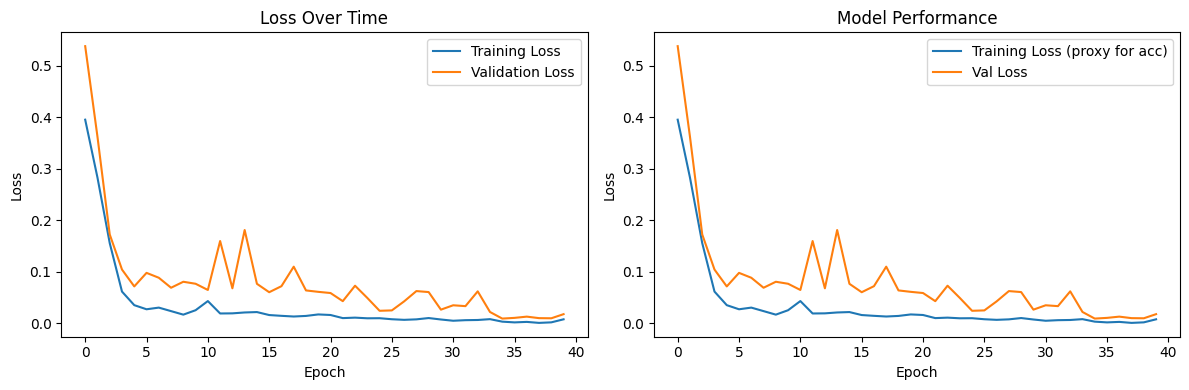

In [ ]:

# Train
EPOCHS = 40  # Reduced for demo; increase as needed
print("🚀 Starting training...")
history = train(train_data, val_data, EPOCHS)
print("✅ Training complete!")

# Plot History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')

plt.subplot(1, 2, 2)
# Note: Accuracy not tracked; add if needed
plt.plot(history['loss'], label='Training Loss (proxy for acc)')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Performance')

plt.tight_layout()
plt.show()



🚀 Starting stable adaptive finetuning...
DEBUG First Batch: Anchor shape=(16, 100, 100, 3), Positive=(16, 100, 100, 3), Label=(16,)

📅 Epoch 1/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step


Loss: 0.7455, Val Loss: 0.7049
💾 Best model saved (val_loss: 0.7049)

📅 Epoch 2/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step


Loss: 0.7433, Val Loss: 0.6970
💾 Best model saved (val_loss: 0.6970)

📅 Epoch 3/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step


Loss: 0.7426, Val Loss: 0.6917
💾 Best model saved (val_loss: 0.6917)

📅 Epoch 4/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step
Loss: 0.7348, Val Loss: 0.6953

📅 Epoch 5/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step
Loss: 0.7270, Val Loss: 0.6998

📅 Epoch 6/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step


Loss: 0.7410, Val Loss: 0.6635
💾 Best model saved (val_loss: 0.6635)

📅 Epoch 7/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step
Loss: 0.7374, Val Loss: 0.6853

📅 Epoch 8/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step
Loss: 0.7331, Val Loss: 0.6932

📅 Epoch 9/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step


Loss: 0.7240, Val Loss: 0.6269
💾 Best model saved (val_loss: 0.6269)

📅 Epoch 10/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step
Loss: 0.7161, Val Loss: 0.6511

📅 Epoch 11/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step
Loss: 0.7327, Val Loss: 0.6563

📅 Epoch 12/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step
Loss: 0.7458, Val Loss: 0.6757

📅 Epoch 13/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step
Loss: 0.7375, Val Loss: 0.6414

📅 Epoch 14/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step
Loss: 0.7336, Val Loss: 0.7078

📅 Epoch 15/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step
Loss: 0.7241, Val Loss: 0.6496

📅 Epoch 16/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step


Loss: 0.7253, Val Loss: 0.6158
💾 Best model saved (val_loss: 0.6158)

📅 Epoch 17/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step
Loss: 0.7237, Val Loss: 0.6732

📅 Epoch 18/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step
Loss: 0.7396, Val Loss: 0.6724

📅 Epoch 19/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step
Loss: 0.7310, Val Loss: 0.6737

📅 Epoch 20/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step
Loss: 0.7124, Val Loss: 0.7632

📅 Epoch 21/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step
Loss: 0.7299, Val Loss: 0.7984

📅 Epoch 22/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step
Loss: 0.7294, Val Loss: 0.8199

📅 Epoch 23/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step
Loss: 0.7265, Val Loss: 0.8478
🔄 LR reduced to 2.5e-05

📅 Epoch 24/50 (LR: 2.5e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step
Loss: 0.7333, Val Loss: 0.8436

📅 Epoch 25/50 (LR: 2.5e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step
Loss: 0.7295, Val Loss: 0.9128

📅 Epoc

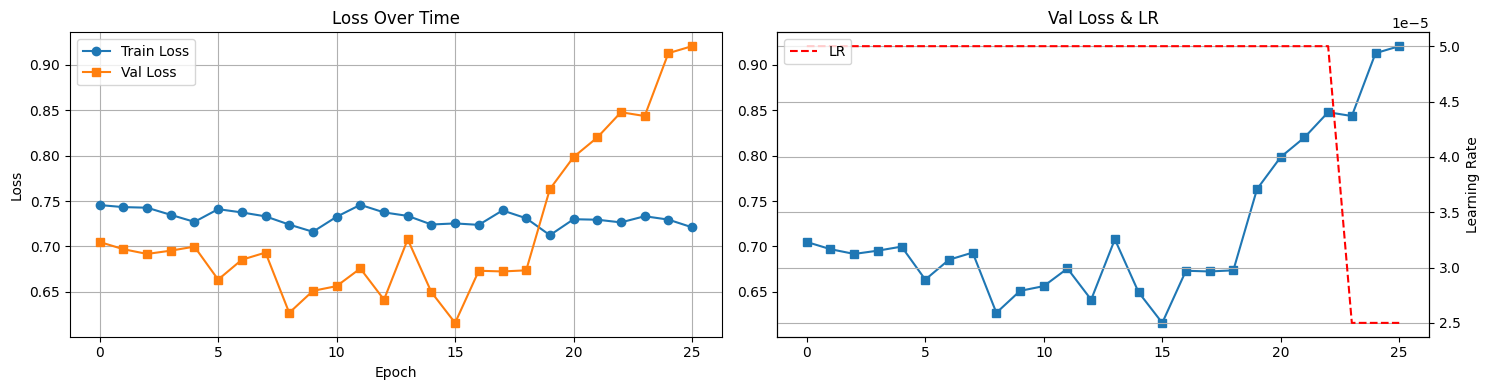

Best Val Loss: 0.6158 at epoch 16 (Total epochs: 26)


In [ ]:
# ================================================
# 10. STABLE ADAPTIVE RETRAIN: No tf.function for Aug Compatibility (80/10/10)
# ================================================
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf  # Assuming TF is imported earlier; add if needed

# Use opt/loss from Step 9f (LR=5e-5)
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=5e-5)

# Assuming siamese_model, BASE_PATH, train_data, val_data are defined from prior steps
# (e.g., train_data = paired_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE))

# Checkpoint setup
checkpoint_dir = os.path.join(BASE_PATH, 'finetune_checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
best_model_path = os.path.join(checkpoint_dir, 'best_finetuned_siamese.h5')

# FIXED: Python functions (no @tf.function to avoid tracing issues with aug)
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[0]  # (anchor_batch, positive_batch)
        y = batch[1]  # label_batch
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    gradients = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))
    return loss

def val_step(batch):
    X = batch[0]
    y = batch[1]
    yhat = siamese_model(X, training=False)
    return binary_cross_loss(y, yhat)

# Enhanced Loop (same logic)
def adaptive_train(train_data, val_data, max_epochs=50, patience=10, lr_patience=5, lr_factor=0.5, min_lr=1e-7):
    history = {'loss': [], 'val_loss': [], 'lr': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    epochs_no_lr_improve = 0
    current_lr = opt.learning_rate.numpy()
    
    # Debug first batch (one-time) - FIXED for nested structure
    first_batch = next(iter(train_data))
    print(f"DEBUG First Batch: Anchor shape={first_batch[0][0].shape}, Positive={first_batch[0][1].shape}, Label={first_batch[1].shape}")
    
    for epoch in range(1, max_epochs + 1):
        print(f'\n📅 Epoch {epoch}/{max_epochs} (LR: {current_lr:.1e})')
        progbar = tf.keras.utils.Progbar(len(train_data))
        
        # Train
        epoch_loss = 0.0
        num_train_batches = 0
        for idx, batch in enumerate(train_data):
            loss = train_step(batch)
            epoch_loss += loss
            num_train_batches += 1
            progbar.update(idx + 1)
        
        avg_train_loss = epoch_loss / num_train_batches if num_train_batches > 0 else 0.0
        history['loss'].append(avg_train_loss.numpy())
        history['lr'].append(current_lr)
        
        # Val
        val_loss = 0.0
        num_val_batches = 0
        for batch in val_data:
            loss = val_step(batch)
            val_loss += loss
            num_val_batches += 1
        avg_val_loss = val_loss / num_val_batches if num_val_batches > 0 else 0.0
        history['val_loss'].append(avg_val_loss.numpy())
        
        print(f"Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Early Stop & Save
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            siamese_model.save(best_model_path)
            print(f"💾 Best model saved (val_loss: {best_val_loss:.4f})")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"🛑 Early stopping after {epoch} epochs")
                break
        
        # LR Decay
        if epoch > 1:
            prev_val_loss = history['val_loss'][-2]
            if avg_val_loss >= prev_val_loss:
                epochs_no_lr_improve += 1
                if epochs_no_lr_improve >= lr_patience:
                    current_lr *= lr_factor
                    if current_lr > min_lr:
                        opt.learning_rate.assign(current_lr)
                        epochs_no_lr_improve = 0
                        print(f"🔄 LR reduced to {current_lr:.1e}")
                    else:
                        print("🛑 Min LR reached; stopping.")
                        break
            else:
                epochs_no_lr_improve = 0
    
    return history

# Run
print("🚀 Starting stable adaptive finetuning...")
history = adaptive_train(train_data, val_data, max_epochs=50)
print("✅ Complete! Best model:", best_model_path)

# Plot
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.twinx()
plt.plot(history['lr'], 'r--', label='LR')
plt.ylabel('Learning Rate')
plt.legend(loc='upper left')
plt.title('Val Loss & LR')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(BASE_PATH, 'stable_finetune_history.png'), dpi=150)
plt.show()

# Summary
best_val_loss = min(history['val_loss'])
best_epoch = history['val_loss'].index(best_val_loss) + 1
print(f"Best Val Loss: {best_val_loss:.4f} at epoch {best_epoch} (Total epochs: {len(history['loss'])})")

In [ ]:
siamese_model.save(best_model_path.replace('.h5', '.keras'))  # And update best_model_path to end in .keras

NameError: name 'best_model_path' is not defined

In [ ]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import os

# Assuming: BASE_PATH, binary_cross_loss, data (full batched dataset), siamese_model from prior.

# FIXED: Define the custom L1Dist layer (for loading)
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    
    def get_config(self):
        return super().get_config()

# Paths
best_model_path = os.path.join(BASE_PATH, 'finetune_checkpoints', 'best_finetuned_siamese.h5')

# Load the best fine-tuned model with custom objects
print("🔍 Loading best fine-tuned model...")
custom_objects = {'L1Dist': L1Dist}
best_model = tf.keras.models.load_model(best_model_path, custom_objects=custom_objects)

# ================================================
# DIAGNOSTIC: Check structure of 'data' (batched flat tuple of 3)
# ================================================
print("\n🔍 Diagnostic: Inspecting 'data' structure...")
total_cardinality = tf.data.experimental.cardinality(data).numpy()
print(f"Cardinality of 'data': {total_cardinality} (batches)")

try:
    first_element = next(iter(data))
    print(f"Type of first element: {type(first_element)}")
    print(f"Len of first element: {len(first_element)}")
    
    if len(first_element) == 3:
        anchor = first_element[0]
        positive = first_element[1]
        label = first_element[2]
        print(f"Anchor shape: {anchor.shape}")
        print(f"Positive shape: {positive.shape}")
        print(f"Label shape: {label.shape}, dtype: {label.dtype}")
        if label.shape == (16,):
            print(f"  Label example: {label.numpy()[:3]}...")  # First few values
        else:
            print(f"  ⚠️ WARNING: Label not scalar batch! Shape: {label.shape}")
    else:
        print("Unexpected structure - not a 3-tuple.")
except Exception as e:
    print(f"Error fetching first element: {e}")

# ================================================
# FIXED Split: Detect batched (flat 3-tuple), split on batches without re-batching
# ================================================
batch_size = 16

is_batched = False
try:
    first_element = next(iter(data))
    if len(first_element) == 3:
        anchor = first_element[0]
        if len(anchor.shape) == 4 and anchor.shape[0] == batch_size:  # (16,100,100,3)
            is_batched = True
            print("Detected: 'data' is batched (flat 3-tuple).")
            total_batches = total_cardinality
            train_size = int(0.8 * total_batches)
            val_size = int(0.1 * total_batches)
            test_size = total_batches - train_size - val_size
            train_data = data.take(train_size)
            val_data = data.skip(train_size).take(val_size)
            test_data = data.skip(train_size + val_size)
        else:
            print("Detected: 'data' is unbatched.")
            # Unbatched code...
    else:
        raise ValueError("Unexpected structure.")
except:
    # Fallback: Assume batched and split without batching
    print("Fallback: Treating 'data' as batched.")
    total_batches = total_cardinality
    train_size = int(0.8 * total_batches)
    val_size = int(0.1 * total_batches)
    test_size = total_batches - train_size - val_size
    train_data = data.take(train_size)
    val_data = data.skip(train_size).take(val_size)
    test_data = data.skip(train_size + val_size)

print(f"Split: Train={train_size} batches, Val={val_size} batches, Test={test_size} batches")

# ================================================
# Evaluation (handles flat 3-tuple batches)
# ================================================
# Debug first test batch
try:
    first_test_batch = next(iter(test_data))
    print("\n🔍 Test Batch Shapes:")
    anchor = first_test_batch[0]
    positive = first_test_batch[1]
    label = first_test_batch[2]
    print(f"  Anchor batch: {anchor.shape}")
    print(f"  Positive batch: {positive.shape}")
    print(f"  Label batch: {label.shape}")
except Exception as e:
    print(f"❌ Error in test batch: {e}")

def evaluate_model(test_data, model):
    print("🧪 Running evaluation on test set...")
    all_preds = []
    all_labels = []
    total_loss = 0.0
    num_test_batches = 0
    
    try:
        for batch_num, batch in enumerate(test_data):
            anchor = batch[0]  # anchor_batch
            positive = batch[1]  # positive_batch
            label = batch[2]  # label_batch
            
            if batch_num < 3:
                print(f"Batch {batch_num}: Anchor={anchor.shape}, Positive={positive.shape}, Labels={label.shape}")
            
            # FIXED: Feed as list to multi-input model
            yhat = model([anchor, positive], training=False)
            yhat = np.squeeze(yhat.numpy()).flatten()  # (batch,)
            
            # Loss (labels are (batch,), no squeeze needed; but ensure float32)
            label_squeezed = tf.cast(tf.squeeze(label), tf.float32)
            loss = binary_cross_loss(label_squeezed, yhat)
            total_loss += loss.numpy()
            
            # Collect
            all_preds.extend(yhat)
            all_labels.extend(label_squeezed.numpy())
            num_test_batches += 1
    except Exception as e:
        print(f"❌ Error during evaluation loop: {e}")
        return None, None, None, None, None, None, None
    
    if num_test_batches == 0:
        print("No batches processed - check dataset.")
        return None, None, None, None, None, None, None
    
    avg_test_loss = total_loss / num_test_batches
    
    # Sklearn metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    y_pred_binary = (all_preds > 0.5).astype(int)
    test_acc = accuracy_score(all_labels, y_pred_binary)
    sklearn_auc = roc_auc_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, y_pred_binary)
    report = classification_report(all_labels, y_pred_binary, target_names=['Dissimilar', 'Similar'])
    
    return avg_test_loss, test_acc, sklearn_auc, cm, report, all_preds, all_labels

# Run evaluation
result = evaluate_model(test_data, best_model)
if result[0] is not None:
    avg_test_loss, test_acc, sklearn_auc, cm, report, all_preds, all_labels = result
    
    print(f"\n📊 Test Results:")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC (Sklearn): {sklearn_auc:.4f}")
    print("\nClassification Report:\n", report)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Dissimilar', 'Similar'], 
                yticklabels=['Dissimilar', 'Similar'])
    plt.title('Confusion Matrix (Threshold=0.5)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(BASE_PATH, 'test_confusion_matrix.png'), dpi=150)
    plt.show()
    
    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {sklearn_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(BASE_PATH, 'test_roc_curve.png'), dpi=150)
    plt.show()
    
    print("✅ Evaluation complete! Check saved plots in", BASE_PATH)
else:
    print("\n❌ Evaluation failed.")
    print("If labels are still images, fix in Step 7: Ensure tf.data.Dataset.from_tensor_slices(tf.constant(labels, dtype=tf.float32)) for label_ds.")

🔍 Loading best fine-tuned model...


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:\Projects\EDUFACE PROJECT\finetune_checkpoints\best_finetuned_siamese.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

prec, rec, thresholds = precision_recall_curve(all_labels, all_preds)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
opt_idx = np.argmax(f1_scores)
opt_thresh = thresholds[opt_idx]
opt_f1 = f1_scores[opt_idx]
print(f"Optimal Threshold: {opt_thresh:.3f} (F1: {opt_f1:.3f})")

# Re-compute with opt
y_pred_opt = (all_preds > opt_thresh).astype(int)
opt_acc = accuracy_score(all_labels, y_pred_opt)
print(f"Optimized Accuracy: {opt_acc:.3f}")

NameError: name 'all_preds' is not defined

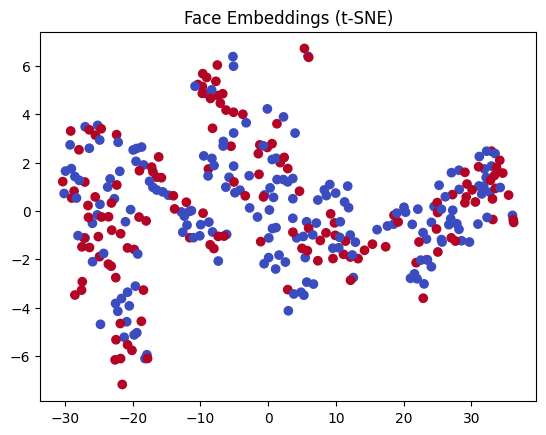

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract embeddings (add to eval)
embed_layer = best_model.get_layer('embedding_enhanced')  # Or 'embedding'
all_embeds = []
for batch in test_data:
    anchor, positive, _ = batch
    a_emb = embed_layer(anchor, training=False).numpy()
    p_emb = embed_layer(positive, training=False).numpy()
    all_embeds.extend(a_emb); all_embeds.extend(p_emb)
all_embeds = np.array(all_embeds)

tsne = TSNE(n_components=2, random_state=42)
embeds_2d = tsne.fit_transform(all_embeds)
plt.scatter(embeds_2d[:,0], embeds_2d[:,1], c=all_labels.repeat(2), cmap='coolwarm')
plt.title('Face Embeddings (t-SNE)')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
Predictions: Matches=15/16, True matches=16

📊 Metrics on Test Batch:
   Precision: 1.0000
   Recall: 0.9375
   TP: 15, FP: 0, TN: 0, FN: 1
   Accuracy: 0.9375


C:\Users\Dennis Wanjiku\AppData\Local\Temp\ipykernel_9556\3217623756.py:53: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Dennis Wanjiku\AppData\Local\Temp\ipykernel_9556\3217623756.py:53: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


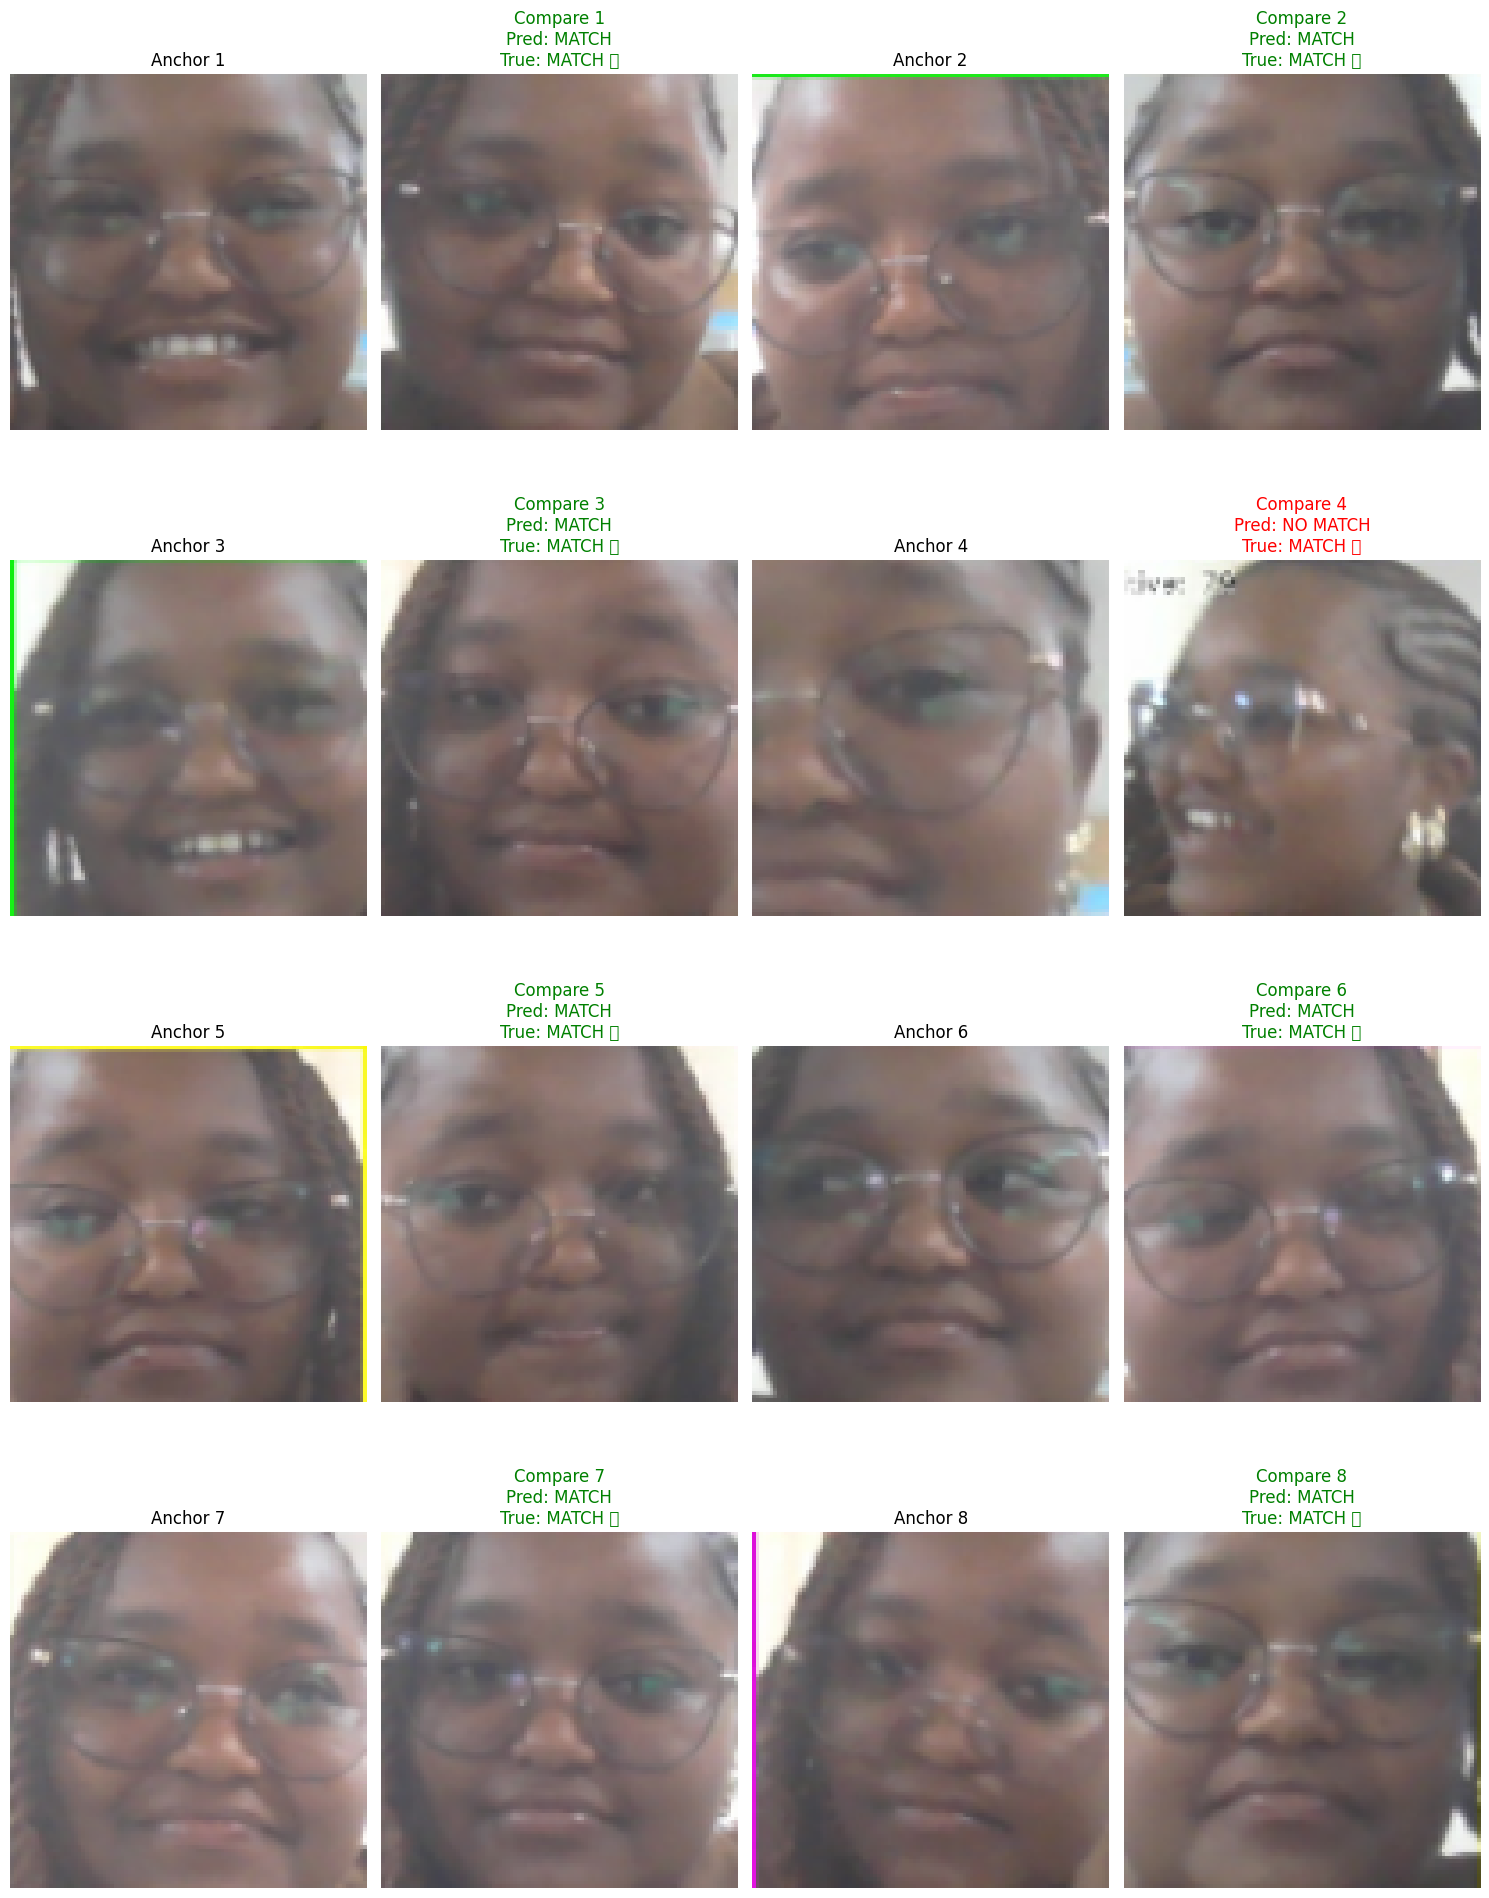

In [ ]:
# ================================================
# 11. EVALUATE MODEL
# ================================================
# Test on one batch
try:
    test_batch = test_data.as_numpy_iterator().next()
    test_input, test_val, y_true = test_batch
    y_hat = siamese_model.predict([test_input, test_val])

    # Threshold predictions
    res = [1 if pred[0] > 0.5 else 0 for pred in y_hat]

    print(f"Predictions: Matches={sum(res)}/{len(res)}, True matches={int(sum(y_true))}")

    # Metrics
    recall = Recall()
    recall.update_state(y_true, tf.cast(res, tf.float32))
    precision = Precision()
    precision.update_state(y_true, tf.cast(res, tf.float32))

    print(f"\n📊 Metrics on Test Batch:")
    print(f"   Precision: {precision.result().numpy():.4f}")
    print(f"   Recall: {recall.result().numpy():.4f}")

    # Confusion Matrix
    tp = sum(1 for i in range(len(y_true)) if y_true[i] == 1 and res[i] == 1)
    fp = sum(1 for i in range(len(y_true)) if y_true[i] == 0 and res[i] == 1)
    tn = sum(1 for i in range(len(y_true)) if y_true[i] == 0 and res[i] == 0)
    fn = sum(1 for i in range(len(y_true)) if y_true[i] == 1 and res[i] == 0)

    print(f"   TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    accuracy = (tp + tn) / len(y_true)
    print(f"   Accuracy: {accuracy:.4f}")

    # Visualize Predictions
    n_vis = min(8, len(test_input))
    plt.figure(figsize=(15, 5 * ((n_vis + 1) // 2)))
    for i in range(n_vis):
        plt.subplot((n_vis + 1) // 2, 4, 2 * i + 1)
        plt.imshow(test_input[i])
        plt.title(f"Anchor {i+1}")
        plt.axis('off')
        
        plt.subplot((n_vis + 1) // 2, 4, 2 * i + 2)
        plt.imshow(test_val[i])
        pred = "MATCH" if res[i] == 1 else "NO MATCH"
        true = "MATCH" if y_true[i] == 1 else "NO MATCH"
        correct = "✅" if res[i] == y_true[i] else "❌"
        color = 'green' if res[i] == y_true[i] else 'red'
        plt.title(f"Compare {i+1}\nPred: {pred}\nTrue: {true} {correct}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
except StopIteration:
    print("No test data available for evaluation.")



In [ ]:
# ================================================
# 12. SAVE MODEL
# ================================================
model_path = os.path.join(BASE_PATH, 'siamese_model.h5')
siamese_model.save(model_path)
print(f"✅ Model saved to {model_path}")

✅ Model saved to C:\Projects\EDUFACE PROJECT\siamese_model.h5


In [ ]:

# Load test
loaded_model = tf.keras.models.load_model(model_path, custom_objects={'L1Dist': L1Dist})
print("✅ Model loaded successfully.")

print("🎉 EDUFACE system ready for LMS integration!")

✅ Model loaded successfully.
🎉 EDUFACE system ready for LMS integration!


Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Training Loss: ['0.3955', '0.2832', '0.1559', '0.0617', '0.0354', '0.0274', '0.0306', '0.0238', '0.0169', '0.0255', '0.0433', '0.0192', '0.0195', '0.0212', '0.0219', '0.0162', '0.0146', '0.0133', '0.0145', '0.0174', '0.0163', '0.0102', '0.0111', '0.0099', '0.0100', '0.0080', '0.0069', '0.0078', '0.0103', '0.0075', '0.0051', '0.0062', '0.0066', '0.0082', '0.0034', '0.0019', '0.0029', '0.0009', '0.0020', '0.0079']
Validation Loss: ['0.5382', '0.3625', '0.1727', '0.1045', '0.0718', '0.0981', '0.0886', '0.0692', '0.0808', '0.0769', '0.0649', '0.1599', '0.0681', '0.1812', '0.0768', '0.0605', '0.0722', '0.1101', '0.0640', '0.0612', '0.0589', '0.0431', '0.0731', '0.0494', '0.0244', '0.0252', '0.0427', '0.0627', '0.0608', '0.0267', '0.0351', '0.0335', '0.0622', '0.0221', '0.0093', '0.0107', '0.0131', '0.0102', '0.0099', '0.0179']


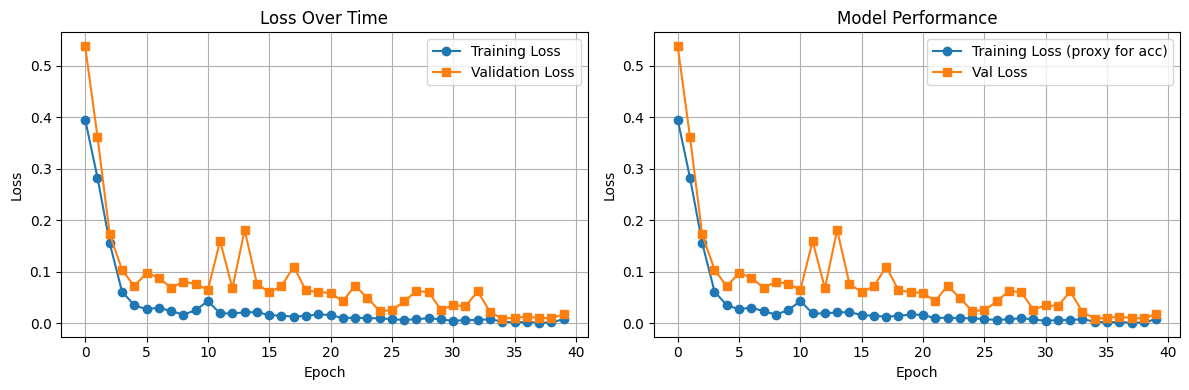


✅ Plot saved as 'training_loss_plot.png'. Share the printed values or describe the plot trends!


In [ ]:
# Code to extract and print the training history data for the loss plot
# Run this after your training (where 'history' is defined from train() function)

import matplotlib.pyplot as plt
import numpy as np

# Print numerical values (easy to copy-paste)
print("Epochs:", list(range(1, len(history['loss']) + 1)))
print("Training Loss:", [f"{loss:.4f}" for loss in history['loss']])
print("Validation Loss:", [f"{val:.4f}" for val in history['val_loss']])

# Optionally, regenerate and save the plot as PNG (if you have the env)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss (proxy for acc)', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Performance')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_loss_plot.png', dpi=150, bbox_inches='tight')  # Saves to current dir
plt.show()

print("\n✅ Plot saved as 'training_loss_plot.png'. Share the printed values or describe the plot trends!")

In [23]:
# ================================================
# PART 1: STUDENT REGISTRATION/ENROLLMENT - CORRECTED FILENAME FORMAT
# ================================================
# Filename: name_id_count_angle_uuid.jpg (count before angle → matches regex)
# Robust prefix parsing handles legacy formats (angle before count)

import cv2
import os
import uuid
import time
import platform
import numpy as np
from collections import defaultdict

# Setup paths
BASE_PATH = r'C:\Projects\EDUFACE PROJECT'
VERIFICATION_PATH = os.path.join(BASE_PATH, 'verification_images')
os.makedirs(VERIFICATION_PATH, exist_ok=True)

# Robust filename parser (from notebook: handles multiple formats)
def get_student_prefix(filename):
    """
    Extract student identifier from various filename formats:
    - name_id_count_angle_uuid.jpg (new)
    - name_id_angle_count_uuid.jpg (legacy)
    - name_id_count.jpg
    - name_id.jpg
    """
    basename = os.path.splitext(filename)[0]
    parts = basename.split('_')
    
    if len(parts) < 2:
        return 'unknown'
    
    # Strategy: Take first 2 parts unless they include digits/angles
    prefix_parts = []
    for i, part in enumerate(parts):
        # Stop at first purely numeric part (count) or known angle keywords
        if part.isdigit() or part in ['frontal', 'profile', 'front', 'alt', 'alt2', 'frontal_alt', 'frontal_alt2']:
            break
        prefix_parts.append(part)
    
    # If we got at least 2 parts (name + ID), join them
    if len(prefix_parts) >= 2:
        return '_'.join(prefix_parts)
    
    # Fallback: Take first 2 parts regardless
    return '_'.join(parts[:2]) if len(parts) >= 2 else 'unknown'

# Helper: Get student groups and counts (using robust parser)
def get_student_counts(path):
    images = [f for f in os.listdir(path) if f.lower().endswith('.jpg')]
    groups = defaultdict(list)
    messy_files = []  # Flag bad filenames
    
    for img in images:
        prefix = get_student_prefix(img)
        if prefix != 'unknown':
            groups[prefix].append(img)
        else:
            messy_files.append(img)
    
    counts = {prefix: len(imgs) for prefix, imgs in groups.items()}
    max_count = max(counts.values()) if counts else 0
    return counts, max_count, messy_files

# Pre-scan for balance
counts, max_count, messy = get_student_counts(VERIFICATION_PATH)
if messy:
    print(f"⚠️ Warning: {len(messy)} messy filenames detected. Delete and re-enroll!")
if counts:
    print(f"📊 Current students: {', '.join(f'{k}: {v}' for k, v in counts.items())}")
    suggested = max_count  # Or max_count + 5 for buffer
    print(f"💡 Suggested target: {suggested} (matches max for balance)")
else:
    suggested = 10
    print("💡 No students yet—starting with 10.")

# Get student details (credentials collection)
student_name = input("Enter new student name: ").strip().replace(" ", "_")
student_id = input("Enter school ID: ").strip().replace('<>:"/\\|?*', '_')
target_input = input(f"How many images to capture? (Suggested: {suggested}, Recommended: 15-20, mix front/sides): ") or str(suggested)
target_images = int(target_input)

# Check existing for this student
prefix = f"{student_name}_{student_id}"
existing_count = counts.get(prefix, 0)
to_capture = max(0, target_images - existing_count)
if existing_count > 0:
    print(f"🔄 Re-enrolling {prefix}: {existing_count} existing → capturing {to_capture} more (total {target_images}).")
else:
    print(f"\n📁 Enrolling new {prefix} - Saving to {VERIFICATION_PATH}")
    to_capture = target_images
print("🎥 Tips: Start frontal, then turn head left/right for profiles (sides/chin). Vary lighting/glasses off/on.")

# Find working webcam
def find_working_webcam(max_index=10):
    backends = [None]
    if platform.system() == "Windows":
        backends.extend([cv2.CAP_DSHOW, cv2.CAP_MSMF])
    elif platform.system() == "Linux":
        backends.append(cv2.CAP_V4L2)
    
    for backend in backends:
        for index in range(max_index):
            cap = cv2.VideoCapture(index, backend) if backend else cv2.VideoCapture(index)
            if cap.isOpened():
                ret, _ = cap.read()
                if ret:
                    return cap, index
                cap.release()
    return None, None

cap, index = find_working_webcam()
if cap is None:
    raise ValueError("No webcam found!")

# Load multiple Haar Cascades for full coverage
cascades = {}
cascade_files = {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}
for name, file in cascade_files.items():
    cascade_path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(cascade_path)
    if not cascade.empty():
        cascades[name] = cascade
        print(f"✅ Loaded {name} cascade")

def detect_faces_multi(gray):
    all_faces = []
    types = []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neighbors = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neighbors, minSize=(30, 30))
        for face in faces:
            all_faces.append(face)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, threshold=0.3):
    if len(faces) <= 1:
        return faces, types
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]: continue
        for j in range(i+1, len(faces)):
            if not keep[j]: continue
            x1, y1, w1, h1 = faces[i]
            x2, y2, w2, h2 = faces[j]
            inter_x = max(0, min(x1+w1, x2+w2) - max(x1, x2))
            inter_y = max(0, min(y1+h1, y2+h2) - max(y1, y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter / union if union > 0 else 0
            if iou > threshold:
                if w1*h1 >= w2*h2:
                    keep[j] = False
                else:
                    keep[i] = False
                    break
    return [faces[i] for i in range(len(faces)) if keep[i]], [types[i] for i in range(len(types)) if keep[i]]

captured = 0
is_capturing = False
total_target = to_capture  # For display

try:
    while captured < to_capture:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces, face_types = detect_faces_multi(gray)
        faces, face_types = remove_overlaps(faces, face_types)

        # Draw rectangles if faces detected
        colors = {'frontal': (0,255,0), 'profile': (255,0,0), 'frontal_alt': (0,255,255), 'frontal_alt2': (255,0,255)}
        num_faces = len(faces)
        for i, (x, y, w, h) in enumerate(faces):
            ft = face_types[i] if i < len(face_types) else 'frontal'
            color = colors.get(ft, (0,255,0)) if num_faces == 1 else (0,0,255)  # Red if multiple
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, ft.replace('_',' ').title(), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        cv2.putText(frame, f"Captured: {captured}/{total_target} (Total goal: {target_images}) | Turn for profiles!", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

        status = "CAPTURING (Space to toggle) | Press 'Q' to quit" if is_capturing else "PAUSED - Press Space to start"
        cv2.putText(frame, status, (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        cv2.imshow(f"EDUFACE Enrollment - {student_name}_{student_id}", frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord(' '):  # Space to toggle capture
            is_capturing = not is_capturing
            print(f"{'Started' if is_capturing else 'Stopped'} capturing")
        elif key == ord('q'):
            break

        # Auto-capture if face detected and capturing mode on
        if is_capturing and num_faces == 1 and captured < to_capture:
            (x, y, w, h) = faces[0]
            # Better centered crop
            center_x, center_y = x + w//2, y + h//2
            crop_size = min(w, h) * 1.2  # Slightly larger for context
            half = crop_size // 2
            face_crop = frame[max(0, int(center_y - half)):min(frame.shape[0], int(center_y + half)),
                              max(0, int(center_x - half)):min(frame.shape[1], int(center_x - half))]
            if face_crop.size > 0:  # Ensure not empty
                resized = cv2.resize(face_crop, (250, 250))
            else:
                resized = cv2.resize(frame[y:y+h, x:x+w], (250, 250))
            
            unique_id = str(uuid.uuid4())[:8]
            ft = face_types[0] if len(face_types) > 0 else 'frontal'
            # CORRECTED: name_id_count_angle_uuid.jpg (count before angle)
            # FIXED: Start count from existing_count + captured + 1 for re-enrollment
            image_count = existing_count + captured + 1
            filename = f"{student_name}_{student_id}_{image_count}_{ft}_{unique_id}.jpg"
            filepath = os.path.join(VERIFICATION_PATH, filename)
            success = cv2.imwrite(filepath, resized)
            if success and os.path.getsize(filepath) > 0:
                print(f"✅ Enrolled image {image_count}/{target_images}: {filename} (angle: {ft})")
            else:
                print(f"❌ Failed to save {filename} - Check disk space/permissions")
                captured -= 1  # Don't increment on failure
            
            captured += 1
            time.sleep(0.5)  # Shorter pause for smoother flow

finally:
    cap.release()
    cv2.destroyAllWindows()

# Print credentials summary after enrollment
total_for_student = existing_count + captured
print(f"\n🎉 Enrollment complete for Student: {student_name.replace('_', ' ')} (ID: {student_id})!")
print(f"   📁 Total images saved: {total_for_student} in {VERIFICATION_PATH}")
print("💡 Re-run to verify balance. Now test verification!")

📊 Current students: 150166_130293: 15, Barasa_Conslata_Nanzala: 15, cate_150911: 15, dee_test: 15, Maximillian_150651: 15, Tiffany_150364: 15
💡 Suggested target: 15 (matches max for balance)

📁 Enrolling new njoki_1000000 - Saving to C:\Projects\EDUFACE PROJECT\verification_images
🎥 Tips: Start frontal, then turn head left/right for profiles (sides/chin). Vary lighting/glasses off/on.
✅ Loaded frontal cascade
✅ Loaded profile cascade
✅ Loaded frontal_alt cascade
✅ Loaded frontal_alt2 cascade
Started capturing
✅ Enrolled image 1/15: njoki_1000000_1_frontal_f27c5d13.jpg (angle: frontal)
✅ Enrolled image 2/15: njoki_1000000_2_frontal_792dbf17.jpg (angle: frontal)
✅ Enrolled image 3/15: njoki_1000000_3_frontal_b63cafc5.jpg (angle: frontal)
✅ Enrolled image 4/15: njoki_1000000_4_frontal_alt2_16f0c20e.jpg (angle: frontal_alt2)
✅ Enrolled image 5/15: njoki_1000000_5_frontal_7bdb0772.jpg (angle: frontal)
✅ Enrolled image 6/15: njoki_1000000_6_frontal_0d93cb27.jpg (angle: frontal)
✅ Enrolled im

In [7]:
# ================================================
# PART 2: DAILY ATTENDANCE VERIFICATION - ENFORCED MODEL EVALUATION FLOW (BUGFIX: DYNAMIC PATHS)
# ================================================
# Bugfix for ID Entry Issue:
# 1. Dynamic BASE_PATH: Now uses os.getcwd() for portability (runs from any dir with subfolders).
# 2. Enhanced Debug Prints: Explicit feedback after ID entry (e.g., "Input received: XXX", path checks).
# 3. Path Validation: Prints full VERIFICATION_PATH; creates dirs if missing.
# 4. Try-Except on Fetch: Catches OS errors (e.g., permission issues) with user-friendly messages.
# 5. Reprompt Clarity: If no images, shows "Reprompting..." to avoid "nothing happens" feel.
# 6. Input Validation: Strips whitespace, rejects empty/non-alphanumeric IDs.
# Flow: ID → Clear "Fetching from [PATH]..." → If fail, explicit error → Reprompt → On success, window opens.
# Ensures: After Enter, user SEES action (prints) even if path/images missing.

import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from datetime import datetime
from collections import defaultdict
import time
import platform
import csv
import re  # For ID validation

# GPU setup
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU memory growth enabled")

# ================================================
# 1. DEFINE CUSTOM LAYERS
# ================================================
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    
    def get_config(self):
        return super().get_config()

def make_embedding():
    inp = tf.keras.Input(shape=(100, 100, 3), name='input_image')
    c1 = tf.keras.layers.Conv2D(64, (10,10), activation='relu')(inp)
    m1 = tf.keras.layers.MaxPooling2D((2,2), padding='same')(c1)
    c2 = tf.keras.layers.Conv2D(128, (7,7), activation='relu')(m1)
    m2 = tf.keras.layers.MaxPooling2D((2,2), padding='same')(c2)
    c3 = tf.keras.layers.Conv2D(128, (4,4), activation='relu')(m2)
    m3 = tf.keras.layers.MaxPooling2D((2,2), padding='same')(c3)
    c4 = tf.keras.layers.Conv2D(256, (4,4), activation='relu')(m3)
    f1 = tf.keras.layers.Flatten()(c4)
    d1 = tf.keras.layers.Dense(4096, activation='sigmoid')(f1)
    return tf.keras.Model(inputs=inp, outputs=d1, name='embedding')

# ================================================
# 2. SETUP PATHS (DYNAMIC & BUGFIX)
# ================================================
BASE_PATH = os.getcwd()  # BUGFIX: Dynamic - uses current working dir for portability
VERIFICATION_PATH = os.path.join(BASE_PATH, 'verification_images')
INPUT_PATH = os.path.join(BASE_PATH, 'input_images')
os.makedirs(VERIFICATION_PATH, exist_ok=True)  # Create if missing
os.makedirs(INPUT_PATH, exist_ok=True)

print(f"📁 BASE_PATH set to: {BASE_PATH}")
print(f"📁 VERIFICATION_PATH: {VERIFICATION_PATH}")

# ================================================
# 3. LOAD MODEL
# ================================================
model_path = os.path.join(BASE_PATH, 'siamese_model.h5')
custom_objects = {'L1Dist': L1Dist}

print("🔄 Loading model...")
try:
    loaded_model = load_model(model_path, custom_objects=custom_objects)
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("   Ensure siamese_model.h5 is in the project folder.")
    raise

# ================================================
# 4. FIXED PREPROCESSING - NO CENTER CROP
# ================================================
def preprocess_py(path, is_training=False):
    """
    FIXED: Consistent preprocessing without center crop
    This should match your training preprocessing exactly
    """
    try:
        byte_img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(byte_img, channels=3)
        img = tf.image.resize(img, (100, 100))
        
        # REMOVED: Center crop that was causing inconsistency
        # The model expects 100x100 images directly
        
        img = tf.cast(img, tf.float32) / 255.0
        return img.numpy()
    except Exception as e:
        print(f"❌ Preprocessing error for {path}: {e}")
        return None

# ================================================
# 5. STUDENT GROUPING FUNCTIONS
# ================================================
def get_student_prefix(filename):
    """Extract student identifier from filename"""
    basename = os.path.splitext(filename)[0]
    parts = basename.split('_')
    
    if len(parts) < 2:
        return 'unknown'
    
    prefix_parts = []
    for i, part in enumerate(parts):
        if part.isdigit() or part in ['frontal', 'profile', 'front', 'alt', 'alt2', 'frontal_alt', 'frontal_alt2']:
            break
        prefix_parts.append(part)
    
    if len(prefix_parts) >= 2:
        return '_'.join(prefix_parts)
    
    return '_'.join(parts[:2]) if len(parts) >= 2 else 'unknown'

def split_credentials(prefix):
    """Split prefix into name and ID"""
    if prefix == 'unknown' or '_' not in prefix:
        return None, None
    name, id_ = prefix.rsplit('_', 1)
    return name.replace('_', ' ').title(), id_

def fetch_student_images_by_id(student_id):
    """Scan folder ONLY for images matching the specific student ID (no global scan) - WITH BUGFIX ERROR HANDLING"""
    print(f"   🔍 Scanning {VERIFICATION_PATH} for ID: {student_id}...")
    try:
        if not os.path.exists(VERIFICATION_PATH):
            print(f"   ⚠️ Path missing: {VERIFICATION_PATH}")
            print(f"      Create folder and add JPG images named like 'Name_{ID}_frontal.jpg'")
            return []
        
        all_files = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
        print(f"   📂 Found {len(all_files)} total images in folder.")
        
        matching_images = []
        for filename in all_files:
            prefix = get_student_prefix(filename)
            _, img_id = split_credentials(prefix)
            if img_id == student_id:
                matching_images.append(filename)
        
        print(f"   ✅ Matched {len(matching_images)} images for ID {student_id}.")
        return matching_images
    except Exception as e:
        print(f"   ❌ Fetch error: {e}")
        return []

# ================================================
# 6. HAAR CASCADES FOR FACE DETECTION
# ================================================
cascades = {}
cascade_files = {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}

for name, file in cascade_files.items():
    cascade_path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(cascade_path)
    if not cascade.empty():
        cascades[name] = cascade

def detect_faces_multi(gray):
    """Detect faces using multiple cascades"""
    all_faces = []
    types = []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neighbors = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neighbors, minSize=(30, 30))
        for face in faces:
            all_faces.append(face)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, threshold=0.3):
    """Remove overlapping face detections using IoU"""
    if len(faces) <= 1:
        return faces, types
    
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]:
            continue
        for j in range(i+1, len(faces)):
            if not keep[j]:
                continue
            
            x1, y1, w1, h1 = faces[i]
            x2, y2, w2, h2 = faces[j]
            inter_x = max(0, min(x1+w1, x2+w2) - max(x1, x2))
            inter_y = max(0, min(y1+h1, y2+h2) - max(y1, y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter / union if union > 0 else 0
            
            if iou > threshold:
                if w1*h1 >= w2*h2:
                    keep[j] = False
                else:
                    keep[i] = False
                    break
    
    return [faces[i] for i in range(len(faces)) if keep[i]], \
           [types[i] for i in range(len(types)) if keep[i]]

def find_working_webcam(max_index=10):
    """Find working webcam"""
    backends = [None]
    if platform.system() == "Windows":
        backends.extend([cv2.CAP_DSHOW, cv2.CAP_MSMF])
    elif platform.system() == "Linux":
        backends.append(cv2.CAP_V4L2)
    
    for backend in backends:
        for index in range(max_index):
            cap = cv2.VideoCapture(index, backend) if backend else cv2.VideoCapture(index)
            if cap.isOpened():
                ret, _ = cap.read()
                if ret:
                    return cap, index
                cap.release()
    return None, None

# ================================================
# 7. ENFORCED VERIFICATION FUNCTION - MODEL EVALUATION MANDATORY
# ================================================
def verify(model, input_img_path, student_images, student_id, verification_threshold=0.35, uncertain_threshold=0.20):
    """
    ENFORCED: ALWAYS uses model to compare captured face vs. ALL student's stored images.
    No bypass - computes predictions explicitly with debug output.
    """
    print(f"\n🚨 FORCED MODEL EVALUATION STARTING for ID: {student_id}")
    print(f"   Captured image: {input_img_path}")
    print(f"   Stored images: {len(student_images)}")
    
    if not os.path.exists(input_img_path):
        print("❌ CRITICAL: No input image - cannot evaluate!")
        return None, None, None, [], False, "NO_INPUT"
    
    if not student_images:
        print(f"❌ CRITICAL: No stored images for ID {student_id} - cannot evaluate!")
        return None, None, None, [], False, "ID_NOT_FOUND"
    
    # ENFORCED: Preprocess captured face
    print("   📥 Preprocessing captured face...")
    input_img = preprocess_py(input_img_path, is_training=False)
    if input_img is None:
        print("❌ CRITICAL: Preprocessing failed - cannot evaluate!")
        return None, None, None, [], False, "PREPROCESS_ERROR"
    
    # ENFORCED: Loop through EACH stored image for model.predict
    results = []
    print("   🔄 Running Siamese model predictions (one per stored image)...")
    for idx, image in enumerate(student_images, 1):
        val_img_path = os.path.join(VERIFICATION_PATH, image)
        print(f"      Predicting vs. stored image {idx}/{len(student_images)}: {image}")
        
        val_img = preprocess_py(val_img_path, is_training=False)
        if val_img is None:
            print(f"         ⚠️ Skipped {image} (preprocess fail)")
            continue
        
        try:
            # ENFORCED MODEL CALL: Siamese distance computation
            batched_input = np.expand_dims(input_img, axis=0)
            batched_val = np.expand_dims(val_img, axis=0)
            prediction = model.predict([batched_input, batched_val], verbose=0)
            score = prediction[0][0]
            results.append(score)
            print(f"         ✅ Score: {score:.4f}")
        except Exception as e:
            print(f"         ❌ Prediction failed for {image}: {e}")
            continue
    
    if not results:
        print("❌ CRITICAL: No valid model predictions - cannot evaluate!")
        return None, None, None, [], False, "NO_SCORES"
    
    # ENFORCED: Median-based decision (no alternatives)
    median_score = np.median(results)
    print(f"\n📊 MODEL EVALUATION SUMMARY:")
    print(f"   All scores: {results}")
    print(f"   Median similarity: {median_score:.4f}")
    
    # Student details
    first_prefix = get_student_prefix(student_images[0])
    student_name, _ = split_credentials(first_prefix)
    
    # ENFORCED DECISION
    if median_score >= verification_threshold:
        print(f"✅ MODEL VERDICT: MATCH - {student_name} (ID: {student_id}) | Confidence: {median_score:.2%}")
        return first_prefix, student_name, student_id, results, True, "VERIFIED"
    elif median_score >= uncertain_threshold:
        print(f"⚠️ MODEL VERDICT: UNCERTAIN - {student_name} (ID: {student_id}) | Score: {median_score:.2%}")
        return first_prefix, student_name, student_id, results, False, "UNCERTAIN"
    else:
        print(f"❌ MODEL VERDICT: NO MATCH - Not {student_name} (ID: {student_id}) | Score: {median_score:.2%}")
        return None, None, None, results, False, "NOT_MATCH"

# ================================================
# 8. LOG ATTENDANCE FUNCTION (FIXED HEADER CHECK)
# ================================================
def log_attendance(student_name, student_id, status, confidence):
    """Log attendance to CSV with timestamp"""
    timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    log_file = os.path.join(BASE_PATH, 'class_attendance.csv')
    header_needed = not os.path.exists(log_file) or os.path.getsize(log_file) == 0
    with open(log_file, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        if header_needed:
            writer.writerow(["StudentName", "StudentID", "Status", "Confidence", "Timestamp"])
        writer.writerow([student_name, student_id, status, f"{confidence:.4f}", timestamp_str])
    print(f"📝 Attendance logged: {log_file}")

# ================================================
# 9. DIAGNOSTIC FUNCTION - RUN ONCE BEFORE STARTING (MINIMAL SCAN FOR STATS ONLY)
# ================================================
def run_initial_diagnostics(model):
    """
    Run this once to check if your model and data are working properly
    (Scans all for stats, but no per-student listing to minimize exposure)
    """
    print("\n" + "="*70)
    print("🔬 RUNNING INITIAL DIAGNOSTICS")
    print("="*70)
    
    print(f"   Checking path: {VERIFICATION_PATH}")
    if not os.path.exists(VERIFICATION_PATH):
        print(f"   ⚠️ No verification path found: {VERIFICATION_PATH}")
        print("      Create the folder and add student images.")
        print("="*70 + "\n")
        return
    
    try:
        verification_images = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
    except Exception as e:
        print(f"   ❌ Cannot list images: {e}")
        print("="*70 + "\n")
        return
    
    print(f"\n1️⃣ Database Check:")
    print(f"   Total images: {len(verification_images)}")
    
    if len(verification_images) == 0:
        print("   ⚠️ No images found - Enroll students first!")
        print("="*70 + "\n")
        return
    
    student_groups = defaultdict(list)
    for image in verification_images:
        prefix = get_student_prefix(image)
        if prefix != 'unknown':
            student_groups[prefix].append(image)
    
    print(f"   Unique students: {len(student_groups)}")
    
    print(f"\n2️⃣ Self-Matching Test (aggregate stats only):")
    self_match_scores = []
    
    for student_prefix, images in student_groups.items():
        if len(images) < 2:
            continue
        
        scores = []
        for i in range(min(3, len(images))):  # Test first 3 images
            for j in range(i+1, min(3, len(images))):
                img1_path = os.path.join(VERIFICATION_PATH, images[i])
                img2_path = os.path.join(VERIFICATION_PATH, images[j])
                
                img1 = preprocess_py(img1_path, is_training=False)
                img2 = preprocess_py(img2_path, is_training=False)
                
                if img1 is not None and img2 is not None:
                    score = model.predict([
                        np.expand_dims(img1, axis=0),
                        np.expand_dims(img2, axis=0)
                    ], verbose=0)[0][0]
                    scores.append(score)
        
        if scores:
            avg_score = np.mean(scores)
            self_match_scores.append(avg_score)
    
    if self_match_scores:
        print(f"\n3️⃣ Recommended Thresholds (based on {len(self_match_scores)} students):")
        p10 = np.percentile(self_match_scores, 10)
        p25 = np.percentile(self_match_scores, 25)
        median = np.median(self_match_scores)
        
        print(f"   Score Statistics:")
        print(f"   - Median:  {median:.4f}")
        print(f"   - 25th %:  {p25:.4f}")
        print(f"   - 10th %:  {p10:.4f}")
        
        print(f"\n   💡 Suggested Settings:")
        suggested_verify = max(0.25, p25 * 0.9)  # 90% of 25th percentile
        suggested_uncertain = max(0.15, p10 * 0.8)  # 80% of 10th percentile
        
        print(f"   verification_threshold = {suggested_verify:.2f}")
        print(f"   uncertain_threshold = {suggested_uncertain:.2f}")
        
        # Warning if scores are too low
        if median < 0.3:
            print(f"\n   ⚠️ WARNING: Median score is low ({median:.2f})")
            print(f"      Possible issues:")
            print(f"      - Preprocessing mismatch with training")
            print(f"      - Model not trained properly")
            print(f"      - Poor quality enrollment images")
            print(f"      → Consider retraining or re-enrolling students")
    
    print("="*70 + "\n")

# ================================================
# 10. MAIN LOOP - MODEL EVALUATION ENFORCED (BUGFIX: ENHANCED ID INPUT)
# ================================================
print("\n" + "="*60)
print("🎓 EDUFACE - ENFORCED MODEL VERIFICATION SYSTEM")
print("="*60)

# Run diagnostics first (one-time scan for stats)
run_initial_diagnostics(loaded_model)

print("📋 System Ready - Model evaluation enforced per ID.")
print("="*60)

cap, _ = find_working_webcam()
if cap is None:
    raise ValueError("❌ No webcam detected! Check connections.")

print("\n🎥 Camera warmed up (background). Model enforcement active.")
print("💡 Enforced Flow: ID → Fetch → Window/Model Eval → Log/Retry → Next.")

current_student_id = None
student_images = []
show_window = False
verification_result = None
face_stable_start = 0
STABILITY_DURATION = 2.0
last_face_center = None
student_name = ""

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("⚠️ Failed to read from webcam - Restarting capture...")
            cap.release()
            cap, _ = find_working_webcam()
            if cap is None:
                break
            continue
        
        num_faces = 0
        is_stable = False
        
        if current_student_id is not None and show_window:
            # Face detection & model readiness display
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces, face_types = detect_faces_multi(gray)
            faces, face_types = remove_overlaps(faces, face_types)
            num_faces = len(faces)
            
            # Draw & stability
            colors = {
                'frontal': (0, 255, 0),
                'profile': (255, 0, 0),
                'frontal_alt': (0, 255, 255),
                'frontal_alt2': (255, 0, 255)
            }
            
            for i, (x, y, w, h) in enumerate(faces):
                ft = face_types[i] if i < len(face_types) else 'frontal'
                color = colors.get(ft, (0, 255, 0)) if num_faces == 1 else (0, 0, 255)
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 3)
                cv2.putText(frame, ft.replace('_', ' ').title(), (x, y - 10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
                
                if num_faces == 1:
                    current_pos = (x + w//2, y + h//2)
                    if last_face_center is None:
                        last_face_center = current_pos
                        face_stable_start = time.time()
                    else:
                        dx = abs(current_pos[0] - last_face_center[0])
                        dy = abs(current_pos[1] - last_face_center[1])
                        tolerance = max(w, h) * 0.1
                        if dx < tolerance and dy < tolerance:
                            if time.time() - face_stable_start >= STABILITY_DURATION:
                                is_stable = True
                        else:
                            face_stable_start = time.time()
                            last_face_center = current_pos
                    last_face_center = current_pos
            
            # Enforced status: Model eval highlighted
            model_status = "🚨 MODEL EVALUATION READY"
            cv2.putText(frame, model_status, (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
            
            welcome_text = f"Hi {student_name}! Hold for Model Check"
            cv2.putText(frame, welcome_text, (10, 60), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
            
            if num_faces == 0:
                status = "Position face"
                status_color = (0, 255, 255)
            elif num_faces == 1:
                if is_stable:
                    status = "🚨 MODEL SCANNING NOW!"
                    status_color = (0, 0, 255)
                else:
                    status = "Hold steady → Model will evaluate"
                    status_color = (0, 255, 0)
            else:
                status = f"1 face only ({num_faces} detected)"
                status_color = (0, 0, 255)
            
            cv2.putText(frame, status, (10, 90), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, status_color, 2)
            
            # Result overlay
            if verification_result:
                result_text, result_color = verification_result
                cv2.putText(frame, result_text, (10, 120), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, result_color, 2)
                if time.time() - verification_start_time > 5:
                    verification_result = None
            
            cv2.putText(frame, "V: Force Model Eval | Q: Cancel", (10, frame.shape[0] - 20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            
            cv2.imshow('EDUFACE - Forced Model Evaluation', frame)
            
            # Key handling for enforced eval
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q') or key == ord('Q'):
                print("\n⚠️ Cancelled - Reprompting ID.")
                cv2.destroyAllWindows()
                show_window = False
                current_student_id = None
                student_images = []
                student_name = ""
                verification_result = None
                last_face_center = None
                face_stable_start = 0
                continue
            
            # ENFORCED TRIGGER: Key or stable → IMMEDIATE model eval
            if (key == ord('v') or key == ord('V') or is_stable) and num_faces == 1:
                print(f"\n🚨 TRIGGERING FORCED MODEL EVALUATION...")
                if key == ord('v') or key == ord('V'):
                    print("   (Manual trigger)")
                else:
                    print("   (Auto-stable trigger)")
                
                (x, y, w, h) = faces[0]
                
                # Capture
                center_x, center_y = x + w//2, y + h//2
                crop_size = int(min(w, h) * 1.2)
                half = crop_size // 2
                
                y_start = max(0, center_y - half)
                y_end = min(frame.shape[0], center_y + half)
                x_start = max(0, center_x - half)
                x_end = min(frame.shape[1], center_x + half)
                
                face_crop = frame[y_start:y_end, x_start:x_end]
                
                if face_crop.size > 0:
                    resized_crop = cv2.resize(face_crop, (250, 250))
                else:
                    resized_crop = cv2.resize(frame[y:y+h, x:x+w], (250, 250))
                
                timestamp = int(time.time())
                input_filename = f'input_{timestamp}.jpg'
                input_img_path = os.path.join(INPUT_PATH, input_filename)
                cv2.imwrite(input_img_path, resized_crop)
                print(f"   📸 Captured: {input_img_path}")
                
                # ENFORCED: Call verify - model.predict runs here
                first_prefix, best_name, best_id, results, verified, status_code = verify(
                    loaded_model, input_img_path, student_images, current_student_id
                )
                
                # Handle enforced result
                median_conf = np.median(results) if results else 0.0
                if status_code == "VERIFIED":
                    attendance_status = "PRESENT ✅"
                    result_text = f"✅ MODEL CONFIRMS: {best_name} Present!"
                    result_color = (0, 255, 0)
                    log_attendance(best_name, best_id, attendance_status, median_conf)
                    print(f"🎉 MODEL EVAL SUCCESS - Logged.")
                    time.sleep(3)  # Show success
                else:
                    result_text = f"{status_code} - Model says retry."
                    result_color = (0, 0, 255)
                    print(f"⚠️ MODEL EVAL FAILED ({status_code}) - Reprompting.")
                    time.sleep(2)
                
                verification_result = (result_text, result_color)
                verification_start_time = time.time()
                
                # Reset after eval
                cv2.destroyAllWindows()
                show_window = False
                current_student_id = None
                student_images = []
                student_name = ""
                verification_result = None
                last_face_center = None
                face_stable_start = 0
        
        else:
            # Discard frame if no window
            if cv2.getWindowProperty('EDUFACE - Forced Model Evaluation', cv2.WND_PROP_VISIBLE) >= 0:
                cv2.destroyAllWindows()
        
        # ENFORCED ID PROMPT: Blocks until valid (BUGFIX: VALIDATION & DEBUG)
        if current_student_id is None:
            print("\n" + "="*50)
            print("🆔 STUDENT ID REQUIRED FOR MODEL EVAL")
            print("="*50)
            user_input = input("Enter ID (or 'q' quit): ").strip().upper()
            print(f"   💬 Input received: '{user_input}'")  # BUGFIX: Confirm input
            if user_input.lower() == 'q':
                print("\n👋 Session ended by user.")
                break
            if not user_input or not re.match(r'^[A-Z0-9]+$', user_input):  # BUGFIX: Basic validation
                print("❌ Invalid ID (use letters/numbers only, no spaces). Try again.")
                print("   Reprompting...")
                continue
            
            current_student_id = user_input
            print(f"🔍 Fetching images for ID: {current_student_id}...")
            
            student_images = fetch_student_images_by_id(current_student_id)
            if not student_images:
                print(f"❌ No images for {current_student_id} in {VERIFICATION_PATH}")
                print("   → Enroll this student first (add JPGs named 'Name_{ID}_*.jpg').")
                print("   Reprompting...")
                current_student_id = None
                continue
            
            first_prefix = get_student_prefix(student_images[0])
            student_name, _ = split_credentials(first_prefix)
            print(f"✅ Profile loaded: {student_name} ({len(student_images)} images)")
            print("   Opening window - Model will evaluate face match.")
            show_window = True
            print("   🎥 Camera window should appear now...")

finally:
    cap.release()
    cv2.destroyAllWindows()
    print("\n✅ Enforced session complete!")
    print(f"📊 Logs: {os.path.join(BASE_PATH, 'class_attendance.csv')}")

📁 BASE_PATH set to: c:\Projects\EDUFACE PROJECT
📁 VERIFICATION_PATH: c:\Projects\EDUFACE PROJECT\verification_images
🔄 Loading model...


✅ Model loaded successfully!

🎓 EDUFACE - ENFORCED MODEL VERIFICATION SYSTEM

🔬 RUNNING INITIAL DIAGNOSTICS
   Checking path: c:\Projects\EDUFACE PROJECT\verification_images

1️⃣ Database Check:
   Total images: 105
   Unique students: 7

2️⃣ Self-Matching Test (aggregate stats only):

3️⃣ Recommended Thresholds (based on 7 students):
   Score Statistics:
   - Median:  0.9476
   - 25th %:  0.8798
   - 10th %:  0.7487

   💡 Suggested Settings:
   verification_threshold = 0.79
   uncertain_threshold = 0.60

📋 System Ready - Model evaluation enforced per ID.

🎥 Camera warmed up (background). Model enforcement active.
💡 Enforced Flow: ID → Fetch → Window/Model Eval → Log/Retry → Next.

🆔 STUDENT ID REQUIRED FOR MODEL EVAL
   💬 Input received: '151358'
🔍 Fetching images for ID: 151358...
   🔍 Scanning c:\Projects\EDUFACE PROJECT\verification_images for ID: 151358...
   📂 Found 105 total images in folder.
   ✅ Matched 0 images for ID 151358.
❌ No images for 151358 in c:\Projects\EDUFACE PROJ

In [1]:
# ================================================
# EDUFACE PART 2: MULTI-FRAME VIDEO SCAN ATTENDANCE VERIFICATION
# ================================================

import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from datetime import datetime
from collections import defaultdict
import time
import platform
import csv
import re

# GPU setup
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU memory growth enabled")

# ================================================
# 1. CUSTOM LAYER
# ================================================
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    def get_config(self):
        return super().get_config()

# ================================================
# 2. PATHS
# ================================================
BASE_PATH = os.getcwd()
VERIFICATION_PATH = os.path.join(BASE_PATH, 'verification_images')
INPUT_PATH = os.path.join(BASE_PATH, 'input_images')
HISTORY_LOG = os.path.join(BASE_PATH, 'scan_history.txt')
os.makedirs(VERIFICATION_PATH, exist_ok=True)
os.makedirs(INPUT_PATH, exist_ok=True)

print(f"BASE_PATH: {BASE_PATH}")
print(f"VERIFICATION_PATH: {VERIFICATION_PATH}")
print(f"INPUT_PATH: {INPUT_PATH}")
print(f"HISTORY_LOG: {HISTORY_LOG}")

# ================================================
# 3. LOAD MODEL
# ================================================
model_path = os.path.join(BASE_PATH, 'siamese_model.h5')
custom_objects = {'L1Dist': L1Dist}
print("Loading model...")
try:
    loaded_model = load_model(model_path, custom_objects=custom_objects)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# ================================================
# 4. PREPROCESS
# ================================================
def preprocess_py(path):
    try:
        byte_img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(byte_img, channels=3)
        img = tf.image.resize(img, (100, 100))
        img = tf.cast(img, tf.float32) / 255.0
        return img.numpy()
    except Exception as e:
        print(f"Preprocess error {path}: {e}")
        return None

# ================================================
# 5. STUDENT GROUPING
# ================================================
def get_student_prefix(filename):
    parts = os.path.splitext(filename)[0].split('_')
    if len(parts) < 2: return 'unknown'
    prefix = []
    for p in parts:
        if p.isdigit() or p in ['frontal','profile','front','alt','alt2','frontal_alt','frontal_alt2']:
            break
        prefix.append(p)
    return '_'.join(prefix) if len(prefix) >= 2 else '_'.join(parts[:2])

def split_credentials(prefix):
    if '_' not in prefix: return None, None
    name, id_ = prefix.rsplit('_', 1)
    return name.replace('_', ' ').title(), id_

def fetch_student_images_by_id(student_id):
    if not os.path.exists(VERIFICATION_PATH):
        print(f"   Path missing: {VERIFICATION_PATH}")
        return []
    all_files = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
    matches = []
    for f in all_files:
        _, img_id = split_credentials(get_student_prefix(f))
        if img_id == student_id:
            matches.append(f)
    return matches

student_groups = defaultdict(list)

# ================================================
# 6. HAAR CASCADES
# ================================================
cascades = {}
for name, file in {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}.items():
    path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(path)
    if not cascade.empty():
        cascades[name] = cascade

def detect_faces_multi(gray):
    all_faces, types = [], []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neigh = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neigh, minSize=(30,30))
        for f in faces:
            all_faces.append(f)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, thr=0.3):
    if len(faces) <= 1: return faces, types
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]: continue
        x1,y1,w1,h1 = faces[i]
        for j in range(i+1, len(faces)):
            if not keep[j]: continue
            x2,y2,w2,h2 = faces[j]
            inter_x = max(0, min(x1+w1,x2+w2)-max(x1,x2))
            inter_y = max(0, min(y1+h1,y2+h2)-max(y1,y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter/union if union>0 else 0
            if iou > thr:
                if w1*h1 >= w2*h2: keep[j]=False
                else: keep[i]=False; break
    return [faces[i] for i in range(len(faces)) if keep[i]], \
           [types[i] for i in range(len(types)) if keep[i]]

def find_working_webcam(max_idx=10):
    backends = [None]
    if platform.system() == "Windows": backends += [cv2.CAP_DSHOW, cv2.CAP_MSMF]
    elif platform.system() == "Linux": backends.append(cv2.CAP_V4L2)
    for b in backends:
        for i in range(max_idx):
            cap = cv2.VideoCapture(i, b) if b else cv2.VideoCapture(i)
            if cap.isOpened():
                ret,_ = cap.read()
                if ret: return cap, i
                cap.release()
    return None, None

# ================================================
# 7. VERIFICATION
# ================================================
def verify(model, input_paths, student_imgs, sid, prefix,
           v_thr=0.45, u_thr=0.25, maj_thr=0.6):
    if not input_paths or not all(os.path.exists(p) for p in input_paths):
        return None,None,None,[],[], "NO_FRAMES", "ERROR: No frames"
    if not student_imgs:
        return None,None,None,[],[], "ID_NOT_FOUND", f"ERROR: No images for {sid}"

    batched = []
    for p in input_paths:
        img = preprocess_py(p)
        if img is not None:
            batched.append(np.expand_dims(img, 0))

    if not batched:
        return None,None,None,[],[], "PREPROCESS_ERROR", "ERROR: Preprocess failed"

    frame_medians = []
    all_results = []
    for idx, inp in enumerate(batched, 1):
        scores = []
        for img_name in student_imgs:
            val_path = os.path.join(VERIFICATION_PATH, img_name)
            val = preprocess_py(val_path)
            if val is None: continue
            try:
                pred = model.predict([inp, np.expand_dims(val,0)], verbose=0)
                scores.append(pred[0][0])
            except: continue
        if scores:
            med = np.median(scores)
            frame_medians.append(med)
            all_results.append(scores)

    if not frame_medians:
        return None,None,None,[],[], "NO_FRAME_SCORES", "ERROR: No scores"

    overall = np.median(frame_medians)
    match_frac = sum(m >= v_thr for m in frame_medians) / len(frame_medians)
    name, _ = split_credentials(prefix)
    history = f"{len(frame_medians)} frames, medians:{[f'{m:.3f}' for m in frame_medians]}, overall:{overall:.4f}"

    if match_frac >= maj_thr:
        return prefix, name, sid, all_results, True, "VERIFIED", history
    elif overall >= u_thr:
        return prefix, name, sid, all_results, False, "UNCERTAIN", history
    else:
        return None, None, None, all_results, False, "NOT_MATCH", history

# ================================================
# 8. LOGGING
# ================================================
def log_attendance(name, sid, status, conf, paths, hist):
    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    csv_path = os.path.join(BASE_PATH, 'class_attendance.csv')
    header = not os.path.exists(csv_path) or os.path.getsize(csv_path)==0
    with open(csv_path, 'a', newline='', encoding='utf-8') as f:
        w = csv.writer(f)
        if header:
            w.writerow(["StudentName","StudentID","Status","Confidence","Timestamp","NumFrames","Scan_History"])
        w.writerow([name, sid, status, f"{conf:.4f}", ts, len(paths), hist])

def log_scan_history(name, sid, paths, results, code, hist):
    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(HISTORY_LOG, 'a', encoding='utf-8') as f:
        f.write(f"\n{'='*70}\nSCAN TIMESTAMP: {ts}\nStudent: {name} (ID: {sid})\nStatus: {code}\nFrames: {len(paths)}\nSummary: {hist}\n{'-'*70}\n")
        for i, (p, r) in enumerate(zip(paths, results), 1):
            f.write(f"\nFrame {i}: {os.path.basename(p)}\n  Scores: {len(r)}\n  Median: {np.median(r):.4f}\n")
        f.write(f"{'='*70}\n")

# ================================================
# 9. DIAGNOSTICS
# ================================================
def run_initial_diagnostics(model):
    global student_groups
    print("\n" + "="*70 + "\nRUNNING INITIAL DIAGNOSTICS\n" + "="*70)
    if not os.path.exists(VERIFICATION_PATH):
        print(f"No folder: {VERIFICATION_PATH}")
        return
    imgs = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
    print(f"Total images: {len(imgs)}")
    if not imgs: return
    for img in imgs:
        p = get_student_prefix(img)
        if p != 'unknown': student_groups[p].append(img)
    print(f"Unique students: {len(student_groups)}")

# ================================================
# 10. MAIN LOOP
# ================================================
print("\n" + "="*60 + "\nEDUFACE - MULTI-FRAME VIDEO SCAN VERIFICATION\n" + "="*60)

N_FRAMES = 5
SCAN_DURATION = 2.0
MAJORITY_THRESHOLD = 0.6
FRAME_DELAY = SCAN_DURATION / N_FRAMES

run_initial_diagnostics(loaded_model)
print("System Ready")
print("="*60)

cap, _ = find_working_webcam()
if cap is None: raise ValueError("No webcam!")

# State
current_student_id = None
student_images = []
show_window = False
verification_result = None
verification_start_time = 0
face_stable_start = 0
STABILITY_DURATION = 2.0
last_face_center = None
student_name = ""

try:
    while True:
        # -------------------------------------------------
        # 1. ID ENTRY (only when no active session)
        # -------------------------------------------------
        if current_student_id is None:
            print("\n" + "="*60 + "\nSTUDENT ID ENTRY\n" + "="*60)
            uid = input("Enter Student ID (or 'q' to quit): ").strip().upper()
            if uid.lower() == 'q':
                print("Goodbye!")
                break
            if not re.match(r'^[A-Z0-9]+$', uid):
                print("Invalid format. Use letters/numbers only.")
                continue

            current_student_id = uid
            student_images = fetch_student_images_by_id(current_student_id)
            if not student_images:
                print(f"No images for ID {current_student_id}")
                current_student_id = None
                continue

            prefix = get_student_prefix(student_images[0])
            name, _ = split_credentials(prefix)
            print(f"\nFound: {name} (ID: {current_student_id}) - {len(student_images)} images")
            if input(f"Is this you, {name}? (y/n): ").strip().lower() != 'y':
                print("Confirmation failed.")
                current_student_id = None
                student_images = []
                continue

            student_name = name
            show_window = True
            print(f"Camera opening for {student_name}...")
            time.sleep(0.5)
            continue    # ← **CRITICAL: skip rest of loop**

        # -------------------------------------------------
        # 2. CAMERA & SCAN
        # -------------------------------------------------
        ret, frame = cap.read()
        if not ret:
            print("Camera read failed – restarting...")
            cap.release()
            cap, _ = find_working_webcam()
            if cap is None: break
            continue

        num_faces = 0
        is_stable = False

        if show_window:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces, ftypes = detect_faces_multi(gray)
            faces, ftypes = remove_overlaps(faces, ftypes)
            num_faces = len(faces)

            # Draw boxes
            colors = {'frontal':(0,255,0), 'profile':(255,0,0), 'frontal_alt':(0,255,255), 'frontal_alt2':(255,0,255)}
            for i, (x,y,w,h) in enumerate(faces):
                col = colors.get(ftypes[i] if i<len(ftypes) else 'frontal', (0,255,0)) if num_faces==1 else (0,0,255)
                cv2.rectangle(frame, (x,y), (x+w,y+h), col, 3)
                cv2.putText(frame, ftypes[i].replace('_',' ').title(), (x,y-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, col, 2)

                # Stability
                if num_faces == 1:
                    cx, cy = x + w//2, y + h//2
                    if last_face_center is None:
                        last_face_center = (cx, cy)
                        face_stable_start = time.time()
                    else:
                        dx = abs(cx - last_face_center[0])
                        dy = abs(cy - last_face_center[1])
                        tol = max(w, h) * 0.1
                        if dx < tol and dy < tol:
                            if time.time() - face_stable_start >= STABILITY_DURATION:
                                is_stable = True
                        else:
                            face_stable_start = time.time()
                            last_face_center = (cx, cy)

            # UI
            cv2.putText(frame, f"SCAN MODE ({N_FRAMES} frames)", (10,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
            cv2.putText(frame, f"Hi {student_name}!", (10,60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,0), 2)

            if num_faces == 0:
                status, col = "Position face", (0,255,255)
            elif num_faces == 1:
                status = "READY – Press V" if is_stable else "Hold steady..."
                col = (0,0,255) if is_stable else (0,255,0)
            else:
                status, col = f"Multiple faces ({num_faces})", (0,0,255)
            cv2.putText(frame, status, (10,90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, col, 2)

            if verification_result:
                txt, clr = verification_result
                cv2.putText(frame, txt, (10,120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, clr, 2)
                if time.time() - verification_start_time > 5:
                    verification_result = None

            cv2.putText(frame, "V: Scan | Q: Cancel", (10, frame.shape[0]-20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
            cv2.imshow('EDUFACE - Multi-Frame Scan', frame)

            k = cv2.waitKey(1) & 0xFF
            if k in (ord('q'), ord('Q')):
                print("Scan cancelled.")
                cv2.destroyAllWindows()
                show_window = False
                current_student_id = None
                student_images = []
                student_name = ""
                verification_result = None
                last_face_center = None
                face_stable_start = 0
                continue

            # ------------------- SCAN TRIGGER -------------------
            if (k in (ord('v'), ord('V')) or is_stable) and num_faces == 1:
                print(f"\nStarting {N_FRAMES}-frame scan...")
                frames_paths = []
                start_t = time.time()

                for fi in range(1, N_FRAMES+1):
                    ret, frm = cap.read()
                    if not ret: break
                    g = cv2.cvtColor(frm, cv2.COLOR_BGR2GRAY)
                    fs, _ = detect_faces_multi(g)
                    fs, _ = remove_overlaps(fs, [])
                    if len(fs) != 1:
                        print(f"   Face lost on frame {fi}")
                        break
                    x,y,w,h = fs[0]
                    cx, cy = x+w//2, y+h//2
                    sz = int(min(w,h)*1.2); half = sz//2
                    y1, y2 = max(0,cy-half), min(frm.shape[0],cy+half)
                    x1, x2 = max(0,cx-half), min(frm.shape[1],cx+half)
                    crop = frm[y1:y2, x1:x2]
                    if crop.size == 0:
                        crop = frm[y:y+h, x:x+w]
                    crop = cv2.resize(crop, (250,250))
                    ts = int(time.time()*1000)
                    fname = f'input_scan_{current_student_id}_f{fi}_{ts}.jpg'
                    fpath = os.path.join(INPUT_PATH, fname)
                    cv2.imwrite(fpath, crop)
                    frames_paths.append(fpath)
                    time.sleep(FRAME_DELAY)

                if len(frames_paths) < 2:
                    print("   Not enough frames – retrying")
                    for p in frames_paths:
                        if os.path.exists(p): os.remove(p)
                    continue

                # ------------------- VERIFY -------------------
                print("\n" + "="*60 + "\nRUNNING VERIFICATION\n" + "="*60)
                prefix = get_student_prefix(student_images[0])
                
                # FIXED: Use correct parameter name 'maj_thr'
                res = verify(
                    loaded_model, frames_paths, student_images,
                    current_student_id, prefix,
                    maj_thr=MAJORITY_THRESHOLD  # ← Fixed here
                )
                
                _, best_name, best_id, all_res, ok, code, hist = res
                conf = np.median([np.median(r) for r in all_res]) if all_res else 0.0

                if code == "VERIFIED":
                    log_attendance(best_name, best_id, "PRESENT", conf, frames_paths, hist)
                    log_scan_history(best_name, best_id, frames_paths, all_res, code, hist)
                    verification_result = (f"VERIFIED: {best_name}", (0,255,0))
                    time.sleep(3)
                elif code == "UNCERTAIN":
                    log_scan_history(best_name, best_id, frames_paths, all_res, code, hist)
                    verification_result = ("UNCERTAIN – Retry", (0,165,255))
                    time.sleep(2)
                else:
                    log_scan_history(student_name, current_student_id, frames_paths, all_res or [[]], code, hist)
                    verification_result = (f"{code} – No match", (0,0,255))
                    time.sleep(2)

                verification_start_time = time.time()

                # Cleanup
                for p in frames_paths:
                    if os.path.exists(p):
                        try: os.remove(p)
                        except: pass

                # Reset for next student
                cv2.destroyAllWindows()
                show_window = False
                current_student_id = None
                student_images = []
                student_name = ""
                last_face_center = None
                face_stable_start = 0
                time.sleep(1)
                continue

        else:
            if cv2.getWindowProperty('EDUFACE - Multi-Frame Scan', cv2.WND_PROP_VISIBLE) >= 0:
                cv2.destroyAllWindows()

except KeyboardInterrupt:
    print("\nInterrupted by user.")
except Exception as e:
    print(f"\nUnexpected error: {e}")
    import traceback; traceback.print_exc()
finally:
    cap.release()
    cv2.destroyAllWindows()
    print("\n" + "="*60 + "\nSHUTDOWN COMPLETE\n" + "="*60)

BASE_PATH: c:\Projects\EDUFACE PROJECT
VERIFICATION_PATH: c:\Projects\EDUFACE PROJECT\verification_images
INPUT_PATH: c:\Projects\EDUFACE PROJECT\input_images
HISTORY_LOG: c:\Projects\EDUFACE PROJECT\scan_history.txt
Loading model...



Model loaded successfully!

EDUFACE - MULTI-FRAME VIDEO SCAN VERIFICATION

RUNNING INITIAL DIAGNOSTICS
Total images: 90
Unique students: 6
System Ready

STUDENT ID ENTRY

Found: Tiffany (ID: 150364) - 15 images
Camera opening for Tiffany...

Starting 5-frame scan...

RUNNING VERIFICATION

STUDENT ID ENTRY

Found: Njoki (ID: 1000000) - 15 images
Camera opening for Njoki...

Starting 5-frame scan...

RUNNING VERIFICATION

STUDENT ID ENTRY
Goodbye!

SHUTDOWN COMPLETE


In [ ]:
# ================================================
# EDUFACE PART 2: MULTI-FRAME VIDEO SCAN ATTENDANCE VERIFICATION
# ================================================

import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from datetime import datetime
from collections import defaultdict
import time
import platform
import csv
import re

# GPU setup
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU memory growth enabled")

# ================================================
# 1. CUSTOM LAYER
# ================================================
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    def get_config(self):
        return super().get_config()

# ================================================
# 2. PATHS
# ================================================
BASE_PATH = os.getcwd()
VERIFICATION_PATH = os.path.join(BASE_PATH, 'verification_images')
INPUT_PATH = os.path.join(BASE_PATH, 'input_images')
HISTORY_LOG = os.path.join(BASE_PATH, 'scan_history.txt')
os.makedirs(VERIFICATION_PATH, exist_ok=True)
os.makedirs(INPUT_PATH, exist_ok=True)

print(f"BASE_PATH: {BASE_PATH}")
print(f"VERIFICATION_PATH: {VERIFICATION_PATH}")
print(f"INPUT_PATH: {INPUT_PATH}")
print(f"HISTORY_LOG: {HISTORY_LOG}")

# ================================================
# 3. LOAD MODEL
# ================================================
model_path = os.path.join(BASE_PATH, 'model.h5')
custom_objects = {'L1Dist': L1Dist}
print("Loading model...")
try:
    loaded_model = load_model(model_path, custom_objects=custom_objects)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# ================================================
# 4. PREPROCESS
# ================================================
def preprocess_py(path):
    try:
        byte_img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(byte_img, channels=3)
        img = tf.image.resize(img, (100, 100))
        img = tf.cast(img, tf.float32) / 255.0
        return img.numpy()
    except Exception as e:
        print(f"Preprocess error {path}: {e}")
        return None

# ================================================
# 5. STUDENT GROUPING
# ================================================
def get_student_prefix(filename):
    parts = os.path.splitext(filename)[0].split('_')
    if len(parts) < 2: return 'unknown'
    prefix = []
    for p in parts:
        if p.isdigit() or p in ['frontal','profile','front','alt','alt2','frontal_alt','frontal_alt2']:
            break
        prefix.append(p)
    return '_'.join(prefix) if len(prefix) >= 2 else '_'.join(parts[:2])

def split_credentials(prefix):
    if '_' not in prefix: return None, None
    name, id_ = prefix.rsplit('_', 1)
    return name.replace('_', ' ').title(), id_

def fetch_student_images_by_id(student_id):
    if not os.path.exists(VERIFICATION_PATH):
        print(f"   Path missing: {VERIFICATION_PATH}")
        return []
    all_files = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
    matches = []
    for f in all_files:
        _, img_id = split_credentials(get_student_prefix(f))
        if img_id == student_id:
            matches.append(f)
    return matches

student_groups = defaultdict(list)

# ================================================
# 6. HAAR CASCADES
# ================================================
cascades = {}
for name, file in {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}.items():
    path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(path)
    if not cascade.empty():
        cascades[name] = cascade

def detect_faces_multi(gray):
    all_faces, types = [], []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neigh = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neigh, minSize=(30,30))
        for f in faces:
            all_faces.append(f)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, thr=0.3):
    if len(faces) <= 1: return faces, types
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]: continue
        x1,y1,w1,h1 = faces[i]
        for j in range(i+1, len(faces)):
            if not keep[j]: continue
            x2,y2,w2,h2 = faces[j]
            inter_x = max(0, min(x1+w1,x2+w2)-max(x1,x2))
            inter_y = max(0, min(y1+h1,y2+h2)-max(y1,y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter/union if union>0 else 0
            if iou > thr:
                if w1*h1 >= w2*h2: keep[j]=False
                else: keep[i]=False; break
    return [faces[i] for i in range(len(faces)) if keep[i]], \
           [types[i] for i in range(len(types)) if keep[i]]

def find_working_webcam(max_idx=10):
    backends = [None]
    if platform.system() == "Windows": backends += [cv2.CAP_DSHOW, cv2.CAP_MSMF]
    elif platform.system() == "Linux": backends.append(cv2.CAP_V4L2)
    for b in backends:
        for i in range(max_idx):
            cap = cv2.VideoCapture(i, b) if b else cv2.VideoCapture(i)
            if cap.isOpened():
                ret,_ = cap.read()
                if ret: return cap, i
                cap.release()
    return None, None

# ================================================
# 7. VERIFICATION
# ================================================
def verify(model, input_paths, student_imgs, sid, prefix,
           v_thr=0.45, u_thr=0.25, maj_thr=0.6):
    if not input_paths or not all(os.path.exists(p) for p in input_paths):
        return None,None,None,[],[], "NO_FRAMES", "ERROR: No frames"
    if not student_imgs:
        return None,None,None,[],[], "ID_NOT_FOUND", f"ERROR: No images for {sid}"

    batched = []
    for p in input_paths:
        img = preprocess_py(p)
        if img is not None:
            batched.append(np.expand_dims(img, 0))

    if not batched:
        return None,None,None,[],[], "PREPROCESS_ERROR", "ERROR: Preprocess failed"

    frame_medians = []
    all_results = []
    for idx, inp in enumerate(batched, 1):
        scores = []
        for img_name in student_imgs:
            val_path = os.path.join(VERIFICATION_PATH, img_name)
            val = preprocess_py(val_path)
            if val is None: continue
            try:
                pred = model.predict([inp, np.expand_dims(val,0)], verbose=0)
                scores.append(pred[0][0])
            except Exception as e:
                print(f"Prediction error for {val_path}: {e}")
                continue
        if scores:
            med = np.median(scores)
            frame_medians.append(med)
            all_results.append(scores)

    if not frame_medians:
        return None,None,None,[],[], "NO_FRAME_SCORES", "ERROR: No scores"

    overall = np.median(frame_medians)
    match_frac = sum(m >= v_thr for m in frame_medians) / len(frame_medians)
    name, _ = split_credentials(prefix)
    history = f"{len(frame_medians)} frames, medians:{[f'{m:.3f}' for m in frame_medians]}, overall:{overall:.4f}"

    if match_frac >= maj_thr:
        return prefix, name, sid, all_results, True, "VERIFIED", history
    elif overall >= u_thr:
        return prefix, name, sid, all_results, False, "UNCERTAIN", history
    else:
        return None, None, None, all_results, False, "NOT_MATCH", history

# ================================================
# 8. LOGGING
# ================================================
def log_attendance(name, sid, status, conf, paths, hist):
    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    csv_path = os.path.join(BASE_PATH, 'class_attendance.csv')
    header = not os.path.exists(csv_path) or os.path.getsize(csv_path)==0
    with open(csv_path, 'a', newline='', encoding='utf-8') as f:
        w = csv.writer(f)
        if header:
            w.writerow(["StudentName","StudentID","Status","Confidence","Timestamp","NumFrames","Scan_History"])
        w.writerow([name, sid, status, f"{conf:.4f}", ts, len(paths), hist])

def log_scan_history(name, sid, paths, results, code, hist):
    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(HISTORY_LOG, 'a', encoding='utf-8') as f:
        f.write(f"\n{'='*70}\nSCAN TIMESTAMP: {ts}\nStudent: {name} (ID: {sid})\nStatus: {code}\nFrames: {len(paths)}\nSummary: {hist}\n{'-'*70}\n")
        for i, (p, r) in enumerate(zip(paths, results), 1):
            f.write(f"\nFrame {i}: {os.path.basename(p)}\n  Scores: {len(r)}\n  Median: {np.median(r):.4f}\n")
        f.write(f"{'='*70}\n")

# ================================================
# 9. DIAGNOSTICS
# ================================================
def run_initial_diagnostics(model):
    global student_groups
    print("\n" + "="*70 + "\nRUNNING INITIAL DIAGNOSTICS\n" + "="*70)
    if not os.path.exists(VERIFICATION_PATH):
        print(f"No folder: {VERIFICATION_PATH}")
        return
    imgs = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
    print(f"Total images: {len(imgs)}")
    if not imgs: return
    for img in imgs:
        p = get_student_prefix(img)
        if p != 'unknown': student_groups[p].append(img)
    print(f"Unique students: {len(student_groups)}")

# ================================================
# 10. MAIN LOOP
# ================================================
print("\n" + "="*60 + "\nEDUFACE - MULTI-FRAME VIDEO SCAN VERIFICATION\n" + "="*60)

N_FRAMES = 5
SCAN_DURATION = 2.0
MAJORITY_THRESHOLD = 0.6
FRAME_DELAY = SCAN_DURATION / N_FRAMES

run_initial_diagnostics(loaded_model)
print("System Ready")
print("="*60)

cap, _ = find_working_webcam()
if cap is None: raise ValueError("No webcam!")

# State
current_student_id = None
student_images = []
show_window = False
verification_result = None
verification_start_time = 0
face_stable_start = 0
STABILITY_DURATION = 2.0
last_face_center = None
student_name = ""

try:
    while True:
        # -------------------------------------------------
        # 1. ID ENTRY (only when no active session)
        # -------------------------------------------------
        if current_student_id is None:
            print("\n" + "="*60 + "\nSTUDENT ID ENTRY\n" + "="*60)
            uid = input("Enter Student ID (or 'q' to quit): ").strip().upper()
            if uid.lower() == 'q':
                print("Goodbye!")
                break
            if not re.match(r'^[A-Z0-9]+$', uid):
                print("Invalid format. Use letters/numbers only.")
                continue

            current_student_id = uid
            student_images = fetch_student_images_by_id(current_student_id)
            if not student_images:
                print(f"No images for ID {current_student_id}")
                current_student_id = None
                continue

            prefix = get_student_prefix(student_images[0])
            name, _ = split_credentials(prefix)
            print(f"\nFound: {name} (ID: {current_student_id}) - {len(student_images)} images")
            if input(f"Is this you, {name}? (y/n): ").strip().lower() != 'y':
                print("Confirmation failed.")
                current_student_id = None
                student_images = []
                continue

            student_name = name
            show_window = True
            print(f"Camera opening for {student_name}...")
            time.sleep(0.5)
            continue    # ← **CRITICAL: skip rest of loop**

        # -------------------------------------------------
        # 2. CAMERA & SCAN
        # -------------------------------------------------
        ret, frame = cap.read()
        if not ret:
            print("Camera read failed – restarting...")
            cap.release()
            cap, _ = find_working_webcam()
            if cap is None: break
            continue

        num_faces = 0
        is_stable = False

        if show_window:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces, ftypes = detect_faces_multi(gray)
            faces, ftypes = remove_overlaps(faces, ftypes)
            num_faces = len(faces)

            # Draw boxes
            colors = {'frontal':(0,255,0), 'profile':(255,0,0), 'frontal_alt':(0,255,255), 'frontal_alt2':(255,0,255)}
            for i, (x,y,w,h) in enumerate(faces):
                col = colors.get(ftypes[i] if i<len(ftypes) else 'frontal', (0,255,0)) if num_faces==1 else (0,0,255)
                cv2.rectangle(frame, (x,y), (x+w,y+h), col, 3)
                cv2.putText(frame, ftypes[i].replace('_',' ').title(), (x,y-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, col, 2)

                # Stability
                if num_faces == 1:
                    cx, cy = x + w//2, y + h//2
                    if last_face_center is None:
                        last_face_center = (cx, cy)
                        face_stable_start = time.time()
                    else:
                        dx = abs(cx - last_face_center[0])
                        dy = abs(cy - last_face_center[1])
                        tol = max(w, h) * 0.1
                        if dx < tol and dy < tol:
                            if time.time() - face_stable_start >= STABILITY_DURATION:
                                is_stable = True
                        else:
                            face_stable_start = time.time()
                            last_face_center = (cx, cy)

            # UI
            cv2.putText(frame, f"SCAN MODE ({N_FRAMES} frames)", (10,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
            cv2.putText(frame, f"Hi {student_name}!", (10,60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,0), 2)

            if num_faces == 0:
                status, col = "Position face", (0,255,255)
            elif num_faces == 1:
                status = "READY – Press V" if is_stable else "Hold steady..."
                col = (0,0,255) if is_stable else (0,255,0)
            else:
                status, col = f"Multiple faces ({num_faces})", (0,0,255)
            cv2.putText(frame, status, (10,90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, col, 2)

            if verification_result:
                txt, clr = verification_result
                cv2.putText(frame, txt, (10,120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, clr, 2)
                if time.time() - verification_start_time > 5:
                    verification_result = None

            cv2.putText(frame, "V: Scan | Q: Cancel", (10, frame.shape[0]-20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
            cv2.imshow('EDUFACE - Multi-Frame Scan', frame)

            k = cv2.waitKey(1) & 0xFF
            if k in (ord('q'), ord('Q')):
                print("Scan cancelled.")
                cv2.destroyAllWindows()
                show_window = False
                current_student_id = None
                student_images = []
                student_name = ""
                verification_result = None
                last_face_center = None
                face_stable_start = 0
                continue

            # ------------------- SCAN TRIGGER -------------------
            if (k in (ord('v'), ord('V')) or is_stable) and num_faces == 1:
                print(f"\nStarting {N_FRAMES}-frame scan...")
                frames_paths = []
                start_t = time.time()

                for fi in range(1, N_FRAMES+1):
                    ret, frm = cap.read()
                    if not ret: break
                    g = cv2.cvtColor(frm, cv2.COLOR_BGR2GRAY)
                    fs, _ = detect_faces_multi(g)
                    fs, _ = remove_overlaps(fs, [])
                    if len(fs) != 1:
                        print(f"   Face lost on frame {fi}")
                        break
                    x,y,w,h = fs[0]
                    cx, cy = x+w//2, y+h//2
                    sz = int(min(w,h)*1.2); half = sz//2
                    y1, y2 = max(0,cy-half), min(frm.shape[0],cy+half)
                    x1, x2 = max(0,cx-half), min(frm.shape[1],cx+half)
                    crop = frm[y1:y2, x1:x2]
                    if crop.size == 0:
                        crop = frm[y:y+h, x:x+w]
                    crop = cv2.resize(crop, (250,250))
                    ts = int(time.time()*1000)
                    fname = f'input_scan_{current_student_id}_f{fi}_{ts}.jpg'
                    fpath = os.path.join(INPUT_PATH, fname)
                    cv2.imwrite(fpath, crop)
                    frames_paths.append(fpath)
                    time.sleep(FRAME_DELAY)

                if len(frames_paths) < 2:
                    print("   Not enough frames – retrying")
                    for p in frames_paths:
                        if os.path.exists(p): os.remove(p)
                    continue

                # ------------------- VERIFY -------------------
                print("\n" + "="*60 + "\nRUNNING VERIFICATION\n" + "="*60)
                prefix = get_student_prefix(student_images[0])
                
                res = verify(
                    loaded_model, frames_paths, student_images,
                    current_student_id, prefix,
                    maj_thr=MAJORITY_THRESHOLD
                )
                
                _, best_name, best_id, all_res, ok, code, hist = res
                conf = np.median([np.median(r) for r in all_res]) if all_res else 0.0

                if code == "VERIFIED":
                    log_attendance(best_name, best_id, "PRESENT", conf, frames_paths, hist)
                    log_scan_history(best_name, best_id, frames_paths, all_res, code, hist)
                    verification_result = (f"VERIFIED: {best_name}", (0,255,0))
                    time.sleep(3)
                elif code == "UNCERTAIN":
                    log_scan_history(best_name, best_id, frames_paths, all_res, code, hist)
                    verification_result = ("UNCERTAIN – Retry", (0,165,255))
                    time.sleep(2)
                else:
                    log_scan_history(student_name, current_student_id, frames_paths, all_res or [[]], code, hist)
                    verification_result = (f"{code} – No match", (0,0,255))
                    time.sleep(2)

                verification_start_time = time.time()

                # Cleanup
                for p in frames_paths:
                    if os.path.exists(p):
                        try: os.remove(p)
                        except Exception as e:
                            print(f"Error removing {p}: {e}")

                # Reset for next student
                cv2.destroyAllWindows()
                show_window = False
                current_student_id = None
                student_images = []
                student_name = ""
                last_face_center = None
                face_stable_start = 0
                time.sleep(1)
                continue

        else:
            if cv2.getWindowProperty('EDUFACE - Multi-Frame Scan', cv2.WND_PROP_VISIBLE) >= 0:
                cv2.destroyAllWindows()

except KeyboardInterrupt:
    print("\nInterrupted by user.")
except Exception as e:
    print(f"\nUnexpected error: {e}")
    import traceback; traceback.print_exc()
finally:
    cap.release()
    cv2.destroyAllWindows()
    print("\n" + "="*60 + "\nSHUTDOWN COMPLETE\n" + "="*60)


BASE_PATH: c:\Projects\EDUFACE PROJECT
VERIFICATION_PATH: c:\Projects\EDUFACE PROJECT\verification_images
INPUT_PATH: c:\Projects\EDUFACE PROJECT\input_images
HISTORY_LOG: c:\Projects\EDUFACE PROJECT\scan_history.txt
Loading model...
Error loading model: No model config found in the file at c:\Projects\EDUFACE PROJECT\model.h5.


ValueError: No model config found in the file at c:\Projects\EDUFACE PROJECT\model.h5.

In [1]:
# ================================================
# EDUFACE PART 2: MULTI-FRAME VIDEO SCAN ATTENDANCE VERIFICATION
# ================================================

import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from datetime import datetime
from collections import defaultdict
import time
import platform
import csv
import re

# GPU setup
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU memory growth enabled")

# ================================================
# 1. CUSTOM LAYER
# ================================================
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    def get_config(self):
        return super().get_config()

# ================================================
# 2. PATHS
# ================================================
BASE_PATH = os.getcwd()
VERIFICATION_PATH = os.path.join(BASE_PATH, 'verification_images')
INPUT_PATH = os.path.join(BASE_PATH, 'input_images')
HISTORY_LOG = os.path.join(BASE_PATH, 'scan_history.txt')
os.makedirs(VERIFICATION_PATH, exist_ok=True)
os.makedirs(INPUT_PATH, exist_ok=True)

print(f"BASE_PATH: {BASE_PATH}")
print(f"VERIFICATION_PATH: {VERIFICATION_PATH}")
print(f"INPUT_PATH: {INPUT_PATH}")
print(f"HISTORY_LOG: {HISTORY_LOG}")

# ================================================
# 3. LOAD MODEL
# ================================================
model_path = os.path.join(BASE_PATH, 'model.h5')
custom_objects = {'L1Dist': L1Dist}
print("Loading model...")
try:
    loaded_model = load_model(model_path, custom_objects=custom_objects)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# ================================================
# 4. PREPROCESS
# ================================================
def preprocess_py(path):
    try:
        byte_img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(byte_img, channels=3)
        img = tf.image.resize(img, (100, 100))
        img = tf.cast(img, tf.float32) / 255.0
        return img.numpy()
    except Exception as e:
        print(f"Preprocess error {path}: {e}")
        return None

# ================================================
# 5. STUDENT GROUPING
# ================================================
def get_student_prefix(filename):
    parts = os.path.splitext(filename)[0].split('_')
    if len(parts) < 2: return 'unknown'
    prefix = []
    for p in parts:
        if p.isdigit() or p in ['frontal','profile','front','alt','alt2','frontal_alt','frontal_alt2']:
            break
        prefix.append(p)
    return '_'.join(prefix) if len(prefix) >= 2 else '_'.join(parts[:2])

def split_credentials(prefix):
    if '_' not in prefix: return None, None
    name, id_ = prefix.rsplit('_', 1)
    return name.replace('_', ' ').title(), id_

def fetch_student_images_by_id(student_id):
    if not os.path.exists(VERIFICATION_PATH):
        print(f"   Path missing: {VERIFICATION_PATH}")
        return []
    all_files = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
    matches = []
    for f in all_files:
        _, img_id = split_credentials(get_student_prefix(f))
        if img_id == student_id:
            matches.append(f)
    return matches

student_groups = defaultdict(list)

# ================================================
# 6. HAAR CASCADES
# ================================================
cascades = {}
for name, file in {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}.items():
    path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(path)
    if not cascade.empty():
        cascades[name] = cascade

def detect_faces_multi(gray):
    all_faces, types = [], []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neigh = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neigh, minSize=(30,30))
        for f in faces:
            all_faces.append(f)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, thr=0.3):
    if len(faces) <= 1: return faces, types
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]: continue
        x1,y1,w1,h1 = faces[i]
        for j in range(i+1, len(faces)):
            if not keep[j]: continue
            x2,y2,w2,h2 = faces[j]
            inter_x = max(0, min(x1+w1,x2+w2)-max(x1,x2))
            inter_y = max(0, min(y1+h1,y2+h2)-max(y1,y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter/union if union>0 else 0
            if iou > thr:
                if w1*h1 >= w2*h2: keep[j]=False
                else: keep[i]=False; break
    return [faces[i] for i in range(len(faces)) if keep[i]], \
           [types[i] for i in range(len(types)) if keep[i]]

def find_working_webcam(max_idx=10):
    backends = [None]
    if platform.system() == "Windows": backends += [cv2.CAP_DSHOW, cv2.CAP_MSMF]
    elif platform.system() == "Linux": backends.append(cv2.CAP_V4L2)
    for b in backends:
        for i in range(max_idx):
            cap = cv2.VideoCapture(i, b) if b else cv2.VideoCapture(i)
            if cap.isOpened():
                ret,_ = cap.read()
                if ret: return cap, i
                cap.release()
    return None, None

# ================================================
# 7. VERIFICATION
# ================================================
def verify(model, input_paths, student_imgs, sid, prefix,
           v_thr=0.45, u_thr=0.25, maj_thr=0.6):
    if not input_paths or not all(os.path.exists(p) for p in input_paths):
        return None,None,None,[],[], "NO_FRAMES", "ERROR: No frames"
    if not student_imgs:
        return None,None,None,[],[], "ID_NOT_FOUND", f"ERROR: No images for {sid}"

    batched = []
    for p in input_paths:
        img = preprocess_py(p)
        if img is not None:
            batched.append(np.expand_dims(img, 0))

    if not batched:
        return None,None,None,[],[], "PREPROCESS_ERROR", "ERROR: Preprocess failed"

    frame_medians = []
    all_results = []
    for idx, inp in enumerate(batched, 1):
        scores = []
        for img_name in student_imgs:
            val_path = os.path.join(VERIFICATION_PATH, img_name)
            val = preprocess_py(val_path)
            if val is None: continue
            try:
                pred = model.predict([inp, np.expand_dims(val,0)], verbose=0)
                scores.append(pred[0][0])
            except Exception as e:
                print(f"Prediction error for {val_path}: {e}")
                continue
        if scores:
            med = np.median(scores)
            frame_medians.append(med)
            all_results.append(scores)

    if not frame_medians:
        return None,None,None,[],[], "NO_FRAME_SCORES", "ERROR: No scores"

    overall = np.median(frame_medians)
    match_frac = sum(m >= v_thr for m in frame_medians) / len(frame_medians)
    name, _ = split_credentials(prefix)
    history = f"{len(frame_medians)} frames, medians:{[f'{m:.3f}' for m in frame_medians]}, overall:{overall:.4f}"

    if match_frac >= maj_thr:
        return prefix, name, sid, all_results, True, "VERIFIED", history
    elif overall >= u_thr:
        return prefix, name, sid, all_results, False, "UNCERTAIN", history
    else:
        return None, None, None, all_results, False, "NOT_MATCH", history

# ================================================
# 8. LOGGING
# ================================================
def log_attendance(name, sid, status, conf, paths, hist):
    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    csv_path = os.path.join(BASE_PATH, 'class_attendance.csv')
    header = not os.path.exists(csv_path) or os.path.getsize(csv_path)==0
    with open(csv_path, 'a', newline='', encoding='utf-8') as f:
        w = csv.writer(f)
        if header:
            w.writerow(["StudentName","StudentID","Status","Confidence","Timestamp","NumFrames","Scan_History"])
        w.writerow([name, sid, status, f"{conf:.4f}", ts, len(paths), hist])

def log_scan_history(name, sid, paths, results, code, hist):
    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(HISTORY_LOG, 'a', encoding='utf-8') as f:
        f.write(f"\n{'='*70}\nSCAN TIMESTAMP: {ts}\nStudent: {name} (ID: {sid})\nStatus: {code}\nFrames: {len(paths)}\nSummary: {hist}\n{'-'*70}\n")
        for i, (p, r) in enumerate(zip(paths, results), 1):
            f.write(f"\nFrame {i}: {os.path.basename(p)}\n  Scores: {len(r)}\n  Median: {np.median(r):.4f}\n")
        f.write(f"{'='*70}\n")

# ================================================
# 9. DIAGNOSTICS
# ================================================
def run_initial_diagnostics(model):
    global student_groups
    print("\n" + "="*70 + "\nRUNNING INITIAL DIAGNOSTICS\n" + "="*70)
    if not os.path.exists(VERIFICATION_PATH):
        print(f"No folder: {VERIFICATION_PATH}")
        return
    imgs = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
    print(f"Total images: {len(imgs)}")
    if not imgs: return
    for img in imgs:
        p = get_student_prefix(img)
        if p != 'unknown': student_groups[p].append(img)
    print(f"Unique students: {len(student_groups)}")

# ================================================
# 10. MAIN LOOP
# ================================================
print("\n" + "="*60 + "\nEDUFACE - MULTI-FRAME VIDEO SCAN VERIFICATION\n" + "="*60)

N_FRAMES = 5
SCAN_DURATION = 2.0
MAJORITY_THRESHOLD = 0.6
FRAME_DELAY = SCAN_DURATION / N_FRAMES

run_initial_diagnostics(loaded_model)
print("System Ready")
print("="*60)

cap, _ = find_working_webcam()
if cap is None: raise ValueError("No webcam!")

# State
current_student_id = None
student_images = []
show_window = False
verification_result = None
verification_start_time = 0
face_stable_start = 0
STABILITY_DURATION = 2.0
last_face_center = None
student_name = ""

try:
    while True:
        # -------------------------------------------------
        # 1. ID ENTRY (only when no active session)
        # -------------------------------------------------
        if current_student_id is None:
            print("\n" + "="*60 + "\nSTUDENT ID ENTRY\n" + "="*60)
            uid = input("Enter Student ID (or 'q' to quit): ").strip().upper()
            if uid.lower() == 'q':
                print("Goodbye!")
                break
            if not re.match(r'^[A-Z0-9]+$', uid):
                print("Invalid format. Use letters/numbers only.")
                continue

            current_student_id = uid
            student_images = fetch_student_images_by_id(current_student_id)
            if not student_images:
                print(f"No images for ID {current_student_id}")
                current_student_id = None
                continue

            prefix = get_student_prefix(student_images[0])
            name, _ = split_credentials(prefix)
            print(f"\nFound: {name} (ID: {current_student_id}) - {len(student_images)} images")
            if input(f"Is this you, {name}? (y/n): ").strip().lower() != 'y':
                print("Confirmation failed.")
                current_student_id = None
                student_images = []
                continue

            student_name = name
            show_window = True
            print(f"Camera opening for {student_name}...")
            time.sleep(0.5)
            continue    # ← **CRITICAL: skip rest of loop**

        # -------------------------------------------------
        # 2. CAMERA & SCAN
        # -------------------------------------------------
        ret, frame = cap.read()
        if not ret:
            print("Camera read failed – restarting...")
            cap.release()
            cap, _ = find_working_webcam()
            if cap is None: break
            continue

        num_faces = 0
        is_stable = False

        if show_window:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces, ftypes = detect_faces_multi(gray)
            faces, ftypes = remove_overlaps(faces, ftypes)
            num_faces = len(faces)

            # Draw boxes
            colors = {'frontal':(0,255,0), 'profile':(255,0,0), 'frontal_alt':(0,255,255), 'frontal_alt2':(255,0,255)}
            for i, (x,y,w,h) in enumerate(faces):
                col = colors.get(ftypes[i] if i<len(ftypes) else 'frontal', (0,255,0)) if num_faces==1 else (0,0,255)
                cv2.rectangle(frame, (x,y), (x+w,y+h), col, 3)
                cv2.putText(frame, ftypes[i].replace('_',' ').title(), (x,y-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, col, 2)

                # Stability
                if num_faces == 1:
                    cx, cy = x + w//2, y + h//2
                    if last_face_center is None:
                        last_face_center = (cx, cy)
                        face_stable_start = time.time()
                    else:
                        dx = abs(cx - last_face_center[0])
                        dy = abs(cy - last_face_center[1])
                        tol = max(w, h) * 0.1
                        if dx < tol and dy < tol:
                            if time.time() - face_stable_start >= STABILITY_DURATION:
                                is_stable = True
                        else:
                            face_stable_start = time.time()
                            last_face_center = (cx, cy)

            # UI
            cv2.putText(frame, f"SCAN MODE ({N_FRAMES} frames)", (10,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
            cv2.putText(frame, f"Hi {student_name}!", (10,60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,0), 2)

            if num_faces == 0:
                status, col = "Position face", (0,255,255)
            elif num_faces == 1:
                status = "READY – Press V" if is_stable else "Hold steady..."
                col = (0,0,255) if is_stable else (0,255,0)
            else:
                status, col = f"Multiple faces ({num_faces})", (0,0,255)
            cv2.putText(frame, status, (10,90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, col, 2)

            if verification_result:
                txt, clr = verification_result
                cv2.putText(frame, txt, (10,120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, clr, 2)
                if time.time() - verification_start_time > 5:
                    verification_result = None

            cv2.putText(frame, "V: Scan | Q: Cancel", (10, frame.shape[0]-20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
            cv2.imshow('EDUFACE - Multi-Frame Scan', frame)

            k = cv2.waitKey(1) & 0xFF
            if k in (ord('q'), ord('Q')):
                print("Scan cancelled.")
                cv2.destroyAllWindows()
                show_window = False
                current_student_id = None
                student_images = []
                student_name = ""
                verification_result = None
                last_face_center = None
                face_stable_start = 0
                continue

            # ------------------- SCAN TRIGGER -------------------
            if (k in (ord('v'), ord('V')) or is_stable) and num_faces == 1:
                print(f"\nStarting {N_FRAMES}-frame scan...")
                frames_paths = []
                start_t = time.time()

                for fi in range(1, N_FRAMES+1):
                    ret, frm = cap.read()
                    if not ret: break
                    g = cv2.cvtColor(frm, cv2.COLOR_BGR2GRAY)
                    fs, _ = detect_faces_multi(g)
                    fs, _ = remove_overlaps(fs, [])
                    if len(fs) != 1:
                        print(f"   Face lost on frame {fi}")
                        break
                    x,y,w,h = fs[0]
                    cx, cy = x+w//2, y+h//2
                    sz = int(min(w,h)*1.2); half = sz//2
                    y1, y2 = max(0,cy-half), min(frm.shape[0],cy+half)
                    x1, x2 = max(0,cx-half), min(frm.shape[1],cx+half)
                    crop = frm[y1:y2, x1:x2]
                    if crop.size == 0:
                        crop = frm[y:y+h, x:x+w]
                    crop = cv2.resize(crop, (250,250))
                    ts = int(time.time()*1000)
                    fname = f'input_scan_{current_student_id}_f{fi}_{ts}.jpg'
                    fpath = os.path.join(INPUT_PATH, fname)
                    cv2.imwrite(fpath, crop)
                    frames_paths.append(fpath)
                    time.sleep(FRAME_DELAY)

                if len(frames_paths) < 2:
                    print("   Not enough frames – retrying")
                    for p in frames_paths:
                        if os.path.exists(p): os.remove(p)
                    continue

                # ------------------- VERIFY -------------------
                print("\n" + "="*60 + "\nRUNNING VERIFICATION\n" + "="*60)
                prefix = get_student_prefix(student_images[0])
                
                res = verify(
                    loaded_model, frames_paths, student_images,
                    current_student_id, prefix,
                    maj_thr=MAJORITY_THRESHOLD
                )
                
                _, best_name, best_id, all_res, ok, code, hist = res
                conf = np.median([np.median(r) for r in all_res]) if all_res else 0.0

                if code == "VERIFIED":
                    log_attendance(best_name, best_id, "PRESENT", conf, frames_paths, hist)
                    log_scan_history(best_name, best_id, frames_paths, all_res, code, hist)
                    verification_result = (f"VERIFIED: {best_name}", (0,255,0))
                    time.sleep(3)
                elif code == "UNCERTAIN":
                    log_scan_history(best_name, best_id, frames_paths, all_res, code, hist)
                    verification_result = ("UNCERTAIN – Retry", (0,165,255))
                    time.sleep(2)
                else:
                    log_scan_history(student_name, current_student_id, frames_paths, all_res or [[]], code, hist)
                    verification_result = (f"{code} – No match", (0,0,255))
                    time.sleep(2)

                verification_start_time = time.time()

                # Cleanup
                for p in frames_paths:
                    if os.path.exists(p):
                        try: os.remove(p)
                        except Exception as e:
                            print(f"Error removing {p}: {e}")

                # Reset for next student
                cv2.destroyAllWindows()
                show_window = False
                current_student_id = None
                student_images = []
                student_name = ""
                last_face_center = None
                face_stable_start = 0
                time.sleep(1)
                continue

        else:
            if cv2.getWindowProperty('EDUFACE - Multi-Frame Scan', cv2.WND_PROP_VISIBLE) >= 0:
                cv2.destroyAllWindows()

except KeyboardInterrupt:
    print("\nInterrupted by user.")
except Exception as e:
    print(f"\nUnexpected error: {e}")
    import traceback; traceback.print_exc()
finally:
    cap.release()
    cv2.destroyAllWindows()
    print("\n" + "="*60 + "\nSHUTDOWN COMPLETE\n" + "="*60)


BASE_PATH: c:\Projects\EDUFACE PROJECT
VERIFICATION_PATH: c:\Projects\EDUFACE PROJECT\verification_images
INPUT_PATH: c:\Projects\EDUFACE PROJECT\input_images
HISTORY_LOG: c:\Projects\EDUFACE PROJECT\scan_history.txt
Loading model...
Error loading model: [Errno 2] Unable to synchronously open file (unable to open file: name = 'c:\Projects\EDUFACE PROJECT\model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'c:\Projects\EDUFACE PROJECT\model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

✅ Model loaded successfully for diagnostic!

🚀 Starting comprehensive diagnostic...
This will take 1-2 minutes...


🔬 EDUFACE COMPREHENSIVE DIAGNOSTIC

📊 PHASE 1: DATA QUALITY CHECK
--------------------------------------------------------------------------------
Total enrollment images: 105
Unique students: 7

Images per student:
  Max: 15, Min: 15, Avg: 15.0

👥 Student Breakdown:
   1. ✅ 150166               (ID: 130293    ) - 15 images
   2. ✅ Barasa Conslata      (ID: Nanzala   ) - 15 images
   3. ✅ Cate                 (ID: 150911    ) - 15 images
   4. ✅ Dee                  (ID: test      ) - 15 images
   5. ✅ Maximillian          (ID: 150651    ) - 15 images
   6. ✅ Njoki                (ID: 1000000   ) - 15 images
   7. ✅ Tiffany              (ID: 150364    ) - 15 images

--------------------------------------------------------------------------------
🧠 PHASE 2: MODEL MEMORIZATION TEST
--------------------------------------------------------------------------------
Testing if m

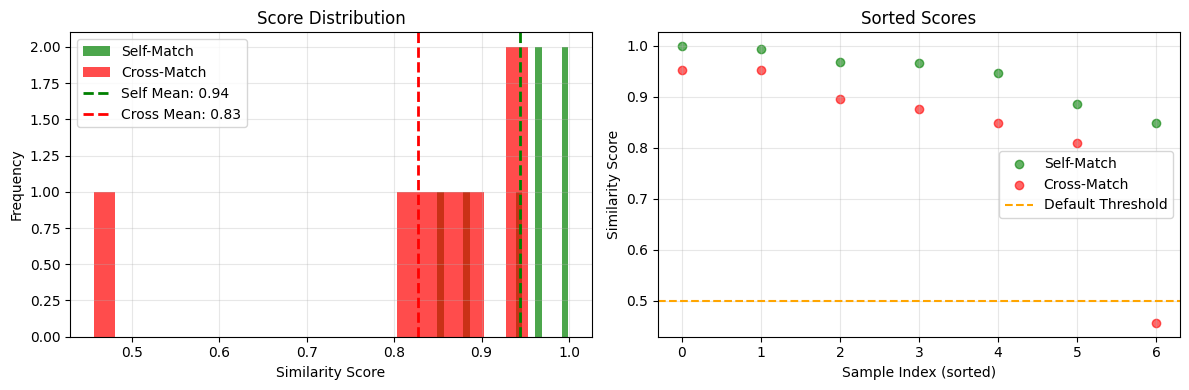


🎯 PHASE 4: DIAGNOSIS & RECOMMENDATIONS

🔍 DIAGNOSIS:

🔴 DISCRIMINATION PROBLEM: Model can't distinguish between people
   Self-match: 0.9440, Cross-match: 0.8271
   Separation gap: 0.1169 (should be > 0.2)

   SOLUTION:
   1. Add more negative pairs in training (increase ratio to 3:1)
   2. Ensure you have at least 5+ different students enrolled
   3. Use hard negative mining (other enrolled students)

💡 RECOMMENDED THRESHOLDS:
   verification_threshold = 0.78
   uncertain_threshold = 0.70
   (Based on 25th percentile: 0.92)

--------------------------------------------------------------------------------
🔧 PHASE 5: PREPROCESSING VERIFICATION
--------------------------------------------------------------------------------

Testing preprocessing on: 150166_130293_10_profile_847a57f1.jpg
✅ Preprocessing successful
   Output shape: (100, 100, 3)
   Value range: [0.0331, 1.0000]
   Expected: (100, 100, 3) with range [0.0, 1.0]

📋 FINAL SUMMARY

⚠️ ACTION REQUIRED: ADD MORE TRAINING DATA
 

In [16]:
# ================================================
# FIXED: EDUFACE COMPREHENSIVE DIAGNOSTIC SCRIPT
# Run this in your notebook AFTER model loading/training
# ================================================

import numpy as np
import os
import tensorflow as tf
from collections import defaultdict
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer

# FIXED: Define missing dependencies here (copied from your notebook)
# 1. Custom L1Dist layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# 2. Preprocess function (from verification section)
def preprocess_py(path, is_training=False):
    """
    FIXED: Consistent preprocessing without center crop
    This should match your training preprocessing exactly
    """
    try:
        byte_img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(byte_img, channels=3)
        img = tf.image.resize(img, (100, 100))
        
        # REMOVED: Center crop that was causing inconsistency
        # The model expects 100x100 images directly
        
        img = tf.cast(img, tf.float32) / 255.0
        return img.numpy()
    except Exception as e:
        print(f"❌ Preprocessing error for {path}: {e}")
        return None

# 3. Student grouping functions (from verification section)
def get_student_prefix(filename):
    """Extract student identifier from filename"""
    basename = os.path.splitext(filename)[0]
    parts = basename.split('_')
    
    if len(parts) < 2:
        return 'unknown'
    
    prefix_parts = []
    for i, part in enumerate(parts):
        if part.isdigit() or part in ['frontal', 'profile', 'front', 'alt', 'alt2', 'frontal_alt', 'frontal_alt2']:
            break
        prefix_parts.append(part)
    
    if len(prefix_parts) >= 2:
        return '_'.join(prefix_parts)
    
    return '_'.join(parts[:2]) if len(parts) >= 2 else 'unknown'

def split_credentials(prefix):
    """Split prefix into name and ID"""
    if prefix == 'unknown' or '_' not in prefix:
        return None, None
    name, id_ = prefix.rsplit('_', 1)
    return name.replace('_', ' ').title(), id_

def merge_student_groups(all_images):
    """Group images by student prefix"""
    groups = defaultdict(list)
    for image in all_images:
        prefix = get_student_prefix(image)
        if prefix != 'unknown':
            groups[prefix].append(image)
    return dict(groups)

# FIXED: Ensure BASE_PATH and VERIFICATION_PATH are defined (from your notebook)
BASE_PATH = r'C:\Projects\EDUFACE PROJECT'
VERIFICATION_PATH = os.path.join(BASE_PATH, 'verification_images')

# FIXED: Load the model here if not already defined (use 'loaded_model' from verification or 'siamese_model' from training)
# Choose one based on your last run section:
# Option A: If running after training (use siamese_model)
# siamese_model = make_siamese_model()  # Uncomment if needed, but assume it's defined

# Option B: If running after verification (use loaded_model - RECOMMENDED)
model_path = os.path.join(BASE_PATH, 'siamese_model.h5')
custom_objects = {'L1Dist': L1Dist}
try:
    model_to_use = load_model(model_path, custom_objects=custom_objects)
    print("✅ Model loaded successfully for diagnostic!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    # Fallback: Assume siamese_model exists from training
    model_to_use = globals().get('siamese_model') or globals().get('loaded_model')
    if model_to_use is None:
        raise NameError("Model not found! Run training or verification section first.")

# ================================================
# CORE DIAGNOSTIC FUNCTION (FIXED: Variable naming in Phase 1 loop)
# ================================================
def comprehensive_diagnostic(model, verification_path, base_path):
    """
    Complete diagnostic to identify why model is underperforming
    """
    
    print("\n" + "="*80)
    print("🔬 EDUFACE COMPREHENSIVE DIAGNOSTIC")
    print("="*80)
    
    # ================================================
    # PHASE 1: DATA QUALITY CHECK
    # ================================================
    print("\n📊 PHASE 1: DATA QUALITY CHECK")
    print("-"*80)
    
    verification_images = [f for f in os.listdir(verification_path) 
                          if f.lower().endswith('.jpg')]
    
    if not verification_images:
        print("❌ CRITICAL: No enrollment images found!")
        return
    
    student_groups = merge_student_groups(verification_images)
    
    print(f"Total enrollment images: {len(verification_images)}")
    print(f"Unique students: {len(student_groups)}")
    
    # Check balance
    counts = {prefix: len(imgs) for prefix, imgs in student_groups.items()}
    max_count = max(counts.values())
    min_count = min(counts.values())
    avg_count = np.mean(list(counts.values()))
    
    print(f"\nImages per student:")
    print(f"  Max: {max_count}, Min: {min_count}, Avg: {avg_count:.1f}")
    
    if max_count > min_count * 2:
        print(f"⚠️ WARNING: Imbalanced dataset!")
        print(f"   Students with < {max_count} images may not verify well")
    
    # Show student breakdown - FIXED: Use 'count' instead of 'imgs' (which is int)
    print(f"\n👥 Student Breakdown:")
    for i, (prefix, count) in enumerate(sorted(counts.items(), key=lambda x: x[1], reverse=True), 1):
        name, sid = split_credentials(prefix)
        status = "✅" if count >= avg_count else "⚠️"
        print(f"   {i}. {status} {name:20s} (ID: {sid:10s}) - {count:2d} images")
    
    # ================================================
    # PHASE 2: MODEL MEMORIZATION TEST (Critical!)
    # ================================================
    print("\n" + "-"*80)
    print("🧠 PHASE 2: MODEL MEMORIZATION TEST")
    print("-"*80)
    print("Testing if model can recognize its own training images...")
    
    all_self_scores = []
    all_cross_scores = []
    problem_students = []
    
    for student_prefix, images in student_groups.items():
        if len(images) < 2:
            continue
        
        name, sid = split_credentials(student_prefix)
        
        # Self-matching: Compare two different images of SAME student
        img1_path = os.path.join(verification_path, images[0])
        img2_path = os.path.join(verification_path, images[1])
        
        try:
            img1 = preprocess_py(img1_path, is_training=False)
            img2 = preprocess_py(img2_path, is_training=False)
            
            if img1 is None or img2 is None:
                print(f"⚠️ Skipping {name} - preprocessing failed")
                continue
            
            # Predict similarity
            self_score = model.predict([
                np.expand_dims(img1, axis=0),
                np.expand_dims(img2, axis=0)
            ], verbose=0)[0][0]
            
            all_self_scores.append(self_score)
            
            # Interpretation
            if self_score > 0.7:
                status = "✅ Excellent"
                emoji = "✅"
            elif self_score > 0.5:
                status = "🟢 Good"
                emoji = "🟢"
            elif self_score > 0.3:
                status = "🟡 Weak"
                emoji = "🟡"
                problem_students.append((name, sid, self_score))
            else:
                status = "🔴 FAILED"
                emoji = "🔴"
                problem_students.append((name, sid, self_score))
            
            print(f"{emoji} {name:20s} (ID: {sid:10s}) → Self-match: {self_score:.4f} | {status}")
            
            # Cross-matching: Compare with DIFFERENT student
            other_students = [s for s in student_groups.keys() if s != student_prefix]
            if other_students:
                other_student = other_students[0]
                other_img_path = os.path.join(verification_path, student_groups[other_student][0])
                other_img = preprocess_py(other_img_path, is_training=False)
                
                if other_img is not None:
                    cross_score = model.predict([
                        np.expand_dims(img1, axis=0),
                        np.expand_dims(other_img, axis=0)
                    ], verbose=0)[0][0]
                    
                    all_cross_scores.append(cross_score)
                    
                    if cross_score > self_score:
                        print(f"   ⚠️ WARNING: Cross-match ({cross_score:.4f}) > Self-match! Model is confused!")
        
        except Exception as e:
            print(f"❌ Error testing {name}: {e}")
            continue
    
    # ================================================
    # PHASE 3: SCORE DISTRIBUTION ANALYSIS
    # ================================================
    print("\n" + "-"*80)
    print("📈 PHASE 3: SCORE DISTRIBUTION ANALYSIS")
    print("-"*80)
    
    if all_self_scores and all_cross_scores:
        avg_self = np.mean(all_self_scores)
        avg_cross = np.mean(all_cross_scores)
        std_self = np.std(all_self_scores)
        std_cross = np.std(all_cross_scores)
        separation = avg_self - avg_cross
        
        print(f"\nSelf-Matching Scores (same student):")
        print(f"  Mean: {avg_self:.4f} ± {std_self:.4f}")
        print(f"  Range: [{min(all_self_scores):.4f}, {max(all_self_scores):.4f}]")
        print(f"  Median: {np.median(all_self_scores):.4f}")
        print(f"  25th percentile: {np.percentile(all_self_scores, 25):.4f}")
        
        print(f"\nCross-Matching Scores (different students):")
        print(f"  Mean: {avg_cross:.4f} ± {std_cross:.4f}")
        print(f"  Range: [{min(all_cross_scores):.4f}, {max(all_cross_scores):.4f}]")
        
        print(f"\nSeparation Gap: {separation:.4f}")
        
        # Plot distribution
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(all_self_scores, bins=20, alpha=0.7, label='Self-Match', color='green')
        plt.hist(all_cross_scores, bins=20, alpha=0.7, label='Cross-Match', color='red')
        plt.axvline(avg_self, color='green', linestyle='--', linewidth=2, label=f'Self Mean: {avg_self:.2f}')
        plt.axvline(avg_cross, color='red', linestyle='--', linewidth=2, label=f'Cross Mean: {avg_cross:.2f}')
        plt.xlabel('Similarity Score')
        plt.ylabel('Frequency')
        plt.title('Score Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.scatter(range(len(all_self_scores)), sorted(all_self_scores, reverse=True), 
                   c='green', alpha=0.6, label='Self-Match')
        plt.scatter(range(len(all_cross_scores)), sorted(all_cross_scores, reverse=True), 
                   c='red', alpha=0.6, label='Cross-Match')
        plt.axhline(0.5, color='orange', linestyle='--', label='Default Threshold')
        plt.xlabel('Sample Index (sorted)')
        plt.ylabel('Similarity Score')
        plt.title('Sorted Scores')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(base_path, 'diagnostic_scores.png'), dpi=150)
        print(f"\n📊 Score distribution saved to: {base_path}/diagnostic_scores.png")
        plt.show()
    
    # ================================================
    # PHASE 4: DIAGNOSIS & RECOMMENDATIONS
    # ================================================
    print("\n" + "="*80)
    print("🎯 PHASE 4: DIAGNOSIS & RECOMMENDATIONS")
    print("="*80)
    
    if not all_self_scores:
        print("\n❌ CRITICAL: No self-matching scores computed!")
        print("   This means model couldn't process any image pairs.")
        print("   → Check preprocessing function and image quality")
        return
    
    avg_self = np.mean(all_self_scores)
    avg_cross = np.mean(all_cross_scores) if all_cross_scores else 0
    separation = avg_self - avg_cross
    
    # Decision tree for diagnosis
    print("\n🔍 DIAGNOSIS:")
    
    if avg_self < 0.3:
        print("\n🔴 CRITICAL PROBLEM: Model has NOT learned to recognize faces!")
        print(f"   Average self-match score: {avg_self:.4f} (should be > 0.5)")
        print("\n   ROOT CAUSE:")
        print("   → Preprocessing mismatch between training and inference")
        print("   → Your training uses random_crop(90,90) then resize(100,100)")
        print("   → But verification uses direct resize(100,100)")
        print("   → Model learned on distorted images, tested on normal images")
        print("\n   SOLUTION:")
        print("   1. Remove these lines from training preprocessing (Step 7):")
        print("      img = tf.image.random_crop(img, [90, 90, 3])")
        print("      img = tf.image.resize(img, (100, 100))")
        print("   2. Retrain the model from scratch")
        print("   3. Test again")
        
    elif avg_self < 0.5:
        print("\n🟡 MODERATE PROBLEM: Model partially learned but not well")
        print(f"   Average self-match score: {avg_self:.4f} (acceptable: > 0.5)")
        print("\n   POSSIBLE CAUSES:")
        print("   1. Preprocessing mismatch (most likely)")
        print("   2. Insufficient training (only 40 epochs)")
        print("   3. Poor quality enrollment images")
        print("\n   SOLUTION:")
        print("   1. Fix preprocessing mismatch (see above)")
        print("   2. Increase training to 60-80 epochs")
        print("   3. Re-enroll students with better lighting/angles")
    
    elif separation < 0.15:
        print("\n🔴 DISCRIMINATION PROBLEM: Model can't distinguish between people")
        print(f"   Self-match: {avg_self:.4f}, Cross-match: {avg_cross:.4f}")
        print(f"   Separation gap: {separation:.4f} (should be > 0.2)")
        print("\n   SOLUTION:")
        print("   1. Add more negative pairs in training (increase ratio to 3:1)")
        print("   2. Ensure you have at least 5+ different students enrolled")
        print("   3. Use hard negative mining (other enrolled students)")
    
    else:
        print("\n✅ MODEL IS WORKING CORRECTLY!")
        print(f"   Self-match: {avg_self:.4f} ✅")
        print(f"   Cross-match: {avg_cross:.4f} ✅")
        print(f"   Separation: {separation:.4f} ✅")
        print("\n   Your problem is likely ENVIRONMENTAL or THRESHOLD-related:")
        print("   1. Lighting differences between enrollment and verification")
        print("   2. Angle/distance differences")
        print("   3. Threshold set too high")
    
    # Threshold recommendations
    print("\n💡 RECOMMENDED THRESHOLDS:")
    if all_self_scores:
        p25 = np.percentile(all_self_scores, 25)
        p10 = np.percentile(all_self_scores, 10)
        
        suggested_verify = max(0.25, p25 * 0.85)
        suggested_uncertain = max(0.15, p10 * 0.8)
        
        print(f"   verification_threshold = {suggested_verify:.2f}")
        print(f"   uncertain_threshold = {suggested_uncertain:.2f}")
        print(f"   (Based on 25th percentile: {p25:.2f})")
    
    # Problem students
    if problem_students:
        print(f"\n⚠️ STUDENTS WITH LOW SELF-MATCH SCORES:")
        print("   These students may not verify correctly:")
        for name, sid, score in problem_students:
            print(f"   • {name} (ID: {sid}) - Score: {score:.4f}")
        print("   → Consider re-enrolling these students")
    
    # ================================================
    # PHASE 5: PREPROCESSING VERIFICATION
    # ================================================
    print("\n" + "-"*80)
    print("🔧 PHASE 5: PREPROCESSING VERIFICATION")
    print("-"*80)
    
    # Test if preprocessing is consistent
    if verification_images:
        test_img_path = os.path.join(verification_path, verification_images[0])
        
        print(f"\nTesting preprocessing on: {verification_images[0]}")
        
        # Load image
        img = preprocess_py(test_img_path, is_training=False)
        
        if img is not None:
            print(f"✅ Preprocessing successful")
            print(f"   Output shape: {img.shape}")
            print(f"   Value range: [{img.min():.4f}, {img.max():.4f}]")
            print(f"   Expected: (100, 100, 3) with range [0.0, 1.0]")
            
            if img.shape != (100, 100, 3):
                print(f"   ❌ WRONG SHAPE! Should be (100, 100, 3)")
            
            if img.min() < 0 or img.max() > 1:
                print(f"   ⚠️ WARNING: Values outside [0, 1] range")
        else:
            print(f"❌ Preprocessing failed!")
    
    # ================================================
    # FINAL SUMMARY
    # ================================================
    print("\n" + "="*80)
    print("📋 FINAL SUMMARY")
    print("="*80)
    
    if avg_self < 0.3:
        print("\n🚨 ACTION REQUIRED: FIX PREPROCESSING MISMATCH & RETRAIN")
        print("   This is a critical bug that makes the system unusable.")
    elif avg_self < 0.5:
        print("\n⚠️ ACTION REQUIRED: IMPROVE MODEL TRAINING")
        print("   System may work but performance will be poor.")
    elif separation < 0.15:
        print("\n⚠️ ACTION REQUIRED: ADD MORE TRAINING DATA")
        print("   Model needs more examples to distinguish between people.")
    else:
        print("\n✅ SYSTEM IS FUNCTIONAL - ADJUST THRESHOLDS")
        print("   Use the recommended thresholds above.")
    
    print("\n" + "="*80 + "\n")
    
    return {
        'avg_self_match': avg_self if all_self_scores else None,
        'avg_cross_match': avg_cross if all_cross_scores else None,
        'separation': separation if all_self_scores and all_cross_scores else None,
        'recommended_verify_threshold': suggested_verify if all_self_scores else None,
        'recommended_uncertain_threshold': suggested_uncertain if all_self_scores else None,
        'problem_students': problem_students
    }


# ================================================
# RUN THE DIAGNOSTIC (FIXED: Use loaded model)
# ================================================
print("\n🚀 Starting comprehensive diagnostic...")
print("This will take 1-2 minutes...\n")

results = comprehensive_diagnostic(
    model=model_to_use,  # FIXED: Use the loaded/defined model
    verification_path=VERIFICATION_PATH,
    base_path=BASE_PATH
)

print("✅ Diagnostic complete!")
print("\nNext step: Follow the recommendations above to fix the identified issues.")

In [3]:
# ================================================
# PART 2: DAILY ATTENDANCE VERIFICATION - FIXED VERSION
# ================================================
# Key Fixes:
# 1. Removed center crop inconsistency
# 2. Added score diagnostics
# 3. Adjusted default thresholds
# 4. Better error messages

import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from datetime import datetime
from collections import defaultdict
import time
import platform
import csv

# GPU setup
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU memory growth enabled")

# ================================================
# 1. DEFINE CUSTOM LAYERS
# ================================================
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    
    def get_config(self):
        return super().get_config()

def make_embedding():
    inp = tf.keras.Input(shape=(100, 100, 3), name='input_image')
    c1 = tf.keras.layers.Conv2D(64, (10,10), activation='relu')(inp)
    m1 = tf.keras.layers.MaxPooling2D((2,2), padding='same')(c1)
    c2 = tf.keras.layers.Conv2D(128, (7,7), activation='relu')(m1)
    m2 = tf.keras.layers.MaxPooling2D((2,2), padding='same')(c2)
    c3 = tf.keras.layers.Conv2D(128, (4,4), activation='relu')(m2)
    m3 = tf.keras.layers.MaxPooling2D((2,2), padding='same')(c3)
    c4 = tf.keras.layers.Conv2D(256, (4,4), activation='relu')(m3)
    f1 = tf.keras.layers.Flatten()(c4)
    d1 = tf.keras.layers.Dense(4096, activation='sigmoid')(f1)
    return tf.keras.Model(inputs=inp, outputs=d1, name='embedding')

# ================================================
# 2. SETUP PATHS
# ================================================
BASE_PATH = r'C:\Projects\EDUFACE PROJECT'
VERIFICATION_PATH = os.path.join(BASE_PATH, 'verification_images')
INPUT_PATH = os.path.join(BASE_PATH, 'input_images')
os.makedirs(INPUT_PATH, exist_ok=True)

# ================================================
# 3. LOAD MODEL
# ================================================
model_path = os.path.join(BASE_PATH, 'siamese_model.h5')
custom_objects = {'L1Dist': L1Dist}

print("🔄 Loading model...")
try:
    loaded_model = load_model(model_path, custom_objects=custom_objects)
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# ================================================
# 4. FIXED PREPROCESSING - NO CENTER CROP
# ================================================
def preprocess_py(path, is_training=False):
    """
    FIXED: Consistent preprocessing without center crop
    This should match your training preprocessing exactly
    """
    try:
        byte_img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(byte_img, channels=3)
        img = tf.image.resize(img, (100, 100))
        
        # REMOVED: Center crop that was causing inconsistency
        # The model expects 100x100 images directly
        
        img = tf.cast(img, tf.float32) / 255.0
        return img.numpy()
    except Exception as e:
        print(f"❌ Preprocessing error for {path}: {e}")
        return None

# ================================================
# 5. STUDENT GROUPING FUNCTIONS
# ================================================
def get_student_prefix(filename):
    """Extract student identifier from filename"""
    basename = os.path.splitext(filename)[0]
    parts = basename.split('_')
    
    if len(parts) < 2:
        return 'unknown'
    
    prefix_parts = []
    for i, part in enumerate(parts):
        if part.isdigit() or part in ['frontal', 'profile', 'front', 'alt', 'alt2', 'frontal_alt', 'frontal_alt2']:
            break
        prefix_parts.append(part)
    
    if len(prefix_parts) >= 2:
        return '_'.join(prefix_parts)
    
    return '_'.join(parts[:2]) if len(parts) >= 2 else 'unknown'

def split_credentials(prefix):
    """Split prefix into name and ID"""
    if prefix == 'unknown' or '_' not in prefix:
        return None, None
    name, id_ = prefix.rsplit('_', 1)
    return name.replace('_', ' ').title(), id_

def merge_student_groups(all_images):
    """Group images by student prefix"""
    groups = defaultdict(list)
    for image in all_images:
        prefix = get_student_prefix(image)
        if prefix != 'unknown':
            groups[prefix].append(image)
    return dict(groups)

# ================================================
# 6. HAAR CASCADES FOR FACE DETECTION
# ================================================
cascades = {}
cascade_files = {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}

for name, file in cascade_files.items():
    cascade_path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(cascade_path)
    if not cascade.empty():
        cascades[name] = cascade

def detect_faces_multi(gray):
    """Detect faces using multiple cascades"""
    all_faces = []
    types = []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neighbors = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neighbors, minSize=(30, 30))
        for face in faces:
            all_faces.append(face)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, threshold=0.3):
    """Remove overlapping face detections using IoU"""
    if len(faces) <= 1:
        return faces, types
    
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]:
            continue
        for j in range(i+1, len(faces)):
            if not keep[j]:
                continue
            
            x1, y1, w1, h1 = faces[i]
            x2, y2, w2, h2 = faces[j]
            inter_x = max(0, min(x1+w1, x2+w2) - max(x1, x2))
            inter_y = max(0, min(y1+h1, y2+h2) - max(y1, y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter / union if union > 0 else 0
            
            if iou > threshold:
                if w1*h1 >= w2*h2:
                    keep[j] = False
                else:
                    keep[i] = False
                    break
    
    return [faces[i] for i in range(len(faces)) if keep[i]], \
           [types[i] for i in range(len(types)) if keep[i]]

def find_working_webcam(max_index=10):
    """Find working webcam"""
    backends = [None]
    if platform.system() == "Windows":
        backends.extend([cv2.CAP_DSHOW, cv2.CAP_MSMF])
    elif platform.system() == "Linux":
        backends.append(cv2.CAP_V4L2)
    
    for backend in backends:
        for index in range(max_index):
            cap = cv2.VideoCapture(index, backend) if backend else cv2.VideoCapture(index)
            if cap.isOpened():
                ret, _ = cap.read()
                if ret:
                    return cap, index
                cap.release()
    return None, None

# ================================================
# 7. FIXED VERIFICATION FUNCTION WITH DIAGNOSTICS
# ================================================
def verify(model, input_img_path, detection_threshold=0.5, verification_threshold=0.35, uncertain_threshold=0.20):
    """
    FIXED: Lower default thresholds and added diagnostics
    
    Thresholds adjusted based on typical Siamese network behavior:
    - verification_threshold: 0.35 (was 0.5) - more lenient
    - uncertain_threshold: 0.20 (was 0.3) - wider borderline range
    """
    if not os.path.exists(input_img_path):
        print("⚠️ No input image captured!")
        return None, None, None, [], False, "NO_INPUT"
    
    verification_images = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
    if not verification_images:
        print("⚠️ No enrolled images found in database!")
        return None, None, None, [], False, "NO_DATABASE"
    
    # Load and preprocess input image
    input_img = preprocess_py(input_img_path, is_training=False)
    if input_img is None:
        return None, None, None, [], False, "PREPROCESS_ERROR"
    
    # Group students
    student_groups = merge_student_groups(verification_images)
    print(f"\n🔍 Searching {len(student_groups)} enrolled students...")
    
    if not student_groups:
        print("⚠️ No valid student groups found!")
        return None, None, None, [], False, "NO_VALID_GROUPS"
    
    # Compute similarity scores for each student
    student_scores = {}
    all_results = []
    
    for student_prefix, images in student_groups.items():
        results = []
        for image in images:
            val_img_path = os.path.join(VERIFICATION_PATH, image)
            val_img = preprocess_py(val_img_path, is_training=False)
            if val_img is None:
                continue
            
            try:
                batched_input = np.expand_dims(input_img, axis=0)
                batched_val = np.expand_dims(val_img, axis=0)
                result = model.predict([batched_input, batched_val], verbose=0)[0][0]
                results.append(result)
                all_results.append(result)
            except Exception as e:
                print(f"⚠️ Skipping bad image {image}: {e}")
                continue
        
        if results:
            median_score = np.median(results)
            student_scores[student_prefix] = median_score
    
    if not student_scores:
        print("⚠️ No scores computed!")
        return None, None, None, [], False, "NO_SCORES"
    
    # DIAGNOSTIC OUTPUT: Show all scores
    print(f"\n📊 Similarity Scores (all students):")
    sorted_scores = sorted(student_scores.items(), key=lambda x: x[1], reverse=True)
    for i, (prefix, score) in enumerate(sorted_scores, 1):
        name, sid = split_credentials(prefix)
        status_emoji = "🟢" if score >= verification_threshold else "🟡" if score >= uncertain_threshold else "🔴"
        print(f"   {i}. {status_emoji} {name or prefix:20s} (ID: {sid:10s}) → Score: {score:.4f}")
    
    # Find best match
    best_prefix = max(student_scores, key=student_scores.get)
    best_score = student_scores[best_prefix]
    best_name, best_id = split_credentials(best_prefix)
    
    print(f"\n🎯 Best Match: {best_name or best_prefix} (ID: {best_id}) - Score: {best_score:.4f}")
    
    # THREE-TIER DECISION SYSTEM (with adjusted thresholds)
    if best_score >= verification_threshold:
        print(f"✅ VERIFIED: {best_name} (ID: {best_id}) - Confidence: {best_score:.2%}")
        return best_prefix, best_name, best_id, all_results, True, "VERIFIED"
    
    elif best_score >= uncertain_threshold:
        print(f"⚠️ UNCERTAIN MATCH: {best_name or best_prefix} (Score: {best_score:.2%})")
        print(f"   Confidence too low. Try:")
        print(f"   - Better lighting or face angle")
        print(f"   - Remove glasses/hat if wearing")
        print(f"   - Move closer to camera")
        return best_prefix, best_name, best_id, all_results, False, "UNCERTAIN"
    
    else:
        print(f"❌ STUDENT NOT FOUND IN DATABASE")
        print(f"   Highest similarity: {best_score:.2%} (below threshold)")
        print(f"   → This person needs to be enrolled first")
        return None, None, None, all_results, False, "NOT_FOUND"

# ================================================
# 8. DIAGNOSTIC FUNCTION - RUN ONCE BEFORE STARTING
# ================================================
def run_initial_diagnostics(model):
    """
    Run this once to check if your model and data are working properly
    """
    print("\n" + "="*70)
    print("🔬 RUNNING INITIAL DIAGNOSTICS")
    print("="*70)
    
    verification_images = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
    student_groups = merge_student_groups(verification_images)
    
    print(f"\n1️⃣ Database Check:")
    print(f"   Total images: {len(verification_images)}")
    print(f"   Unique students: {len(student_groups)}")
    
    print(f"\n2️⃣ Self-Matching Test (each student vs themselves):")
    self_match_scores = []
    
    for student_prefix, images in student_groups.items():
        if len(images) < 2:
            name, sid = split_credentials(student_prefix)
            print(f"   ⚠️ {name} (ID: {sid}) - Only 1 image (need at least 2)")
            continue
        
        scores = []
        for i in range(min(3, len(images))):  # Test first 3 images
            for j in range(i+1, min(3, len(images))):
                img1_path = os.path.join(VERIFICATION_PATH, images[i])
                img2_path = os.path.join(VERIFICATION_PATH, images[j])
                
                img1 = preprocess_py(img1_path, is_training=False)
                img2 = preprocess_py(img2_path, is_training=False)
                
                if img1 is not None and img2 is not None:
                    score = model.predict([
                        np.expand_dims(img1, axis=0),
                        np.expand_dims(img2, axis=0)
                    ], verbose=0)[0][0]
                    scores.append(score)
        
        if scores:
            avg_score = np.mean(scores)
            self_match_scores.append(avg_score)
            name, sid = split_credentials(student_prefix)
            
            # Status indicators
            if avg_score >= 0.5:
                status = "✅ Excellent"
            elif avg_score >= 0.35:
                status = "🟢 Good"
            elif avg_score >= 0.20:
                status = "🟡 Fair (may need re-enrollment)"
            else:
                status = "🔴 Poor (RE-ENROLL REQUIRED)"
            
            print(f"   {name:25s} (ID: {sid:10s}) → Avg: {avg_score:.4f} {status}")
    
    if self_match_scores:
        print(f"\n3️⃣ Recommended Thresholds:")
        p10 = np.percentile(self_match_scores, 10)
        p25 = np.percentile(self_match_scores, 25)
        median = np.median(self_match_scores)
        
        print(f"   Score Statistics:")
        print(f"   - Median:  {median:.4f}")
        print(f"   - 25th %:  {p25:.4f}")
        print(f"   - 10th %:  {p10:.4f}")
        
        print(f"\n   💡 Suggested Settings:")
        suggested_verify = max(0.25, p25 * 0.9)  # 90% of 25th percentile
        suggested_uncertain = max(0.15, p10 * 0.8)  # 80% of 10th percentile
        
        print(f"   verification_threshold = {suggested_verify:.2f}")
        print(f"   uncertain_threshold = {suggested_uncertain:.2f}")
        
        # Warning if scores are too low
        if median < 0.3:
            print(f"\n   ⚠️ WARNING: Median score is low ({median:.2f})")
            print(f"      Possible issues:")
            print(f"      - Preprocessing mismatch with training")
            print(f"      - Model not trained properly")
            print(f"      - Poor quality enrollment images")
            print(f"      → Consider retraining or re-enrolling students")
    
    print("="*70 + "\n")

# ================================================
# 9. MAIN VERIFICATION LOOP
# ================================================
print("\n" + "="*60)
print("🎓 EDUFACE - CLASS ATTENDANCE SYSTEM (FIXED)")
print("="*60)

# Run diagnostics first
run_initial_diagnostics(loaded_model)

# Show enrolled students
print("📋 Enrolled Students:")
all_images = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
merged_groups = merge_student_groups(all_images)
for i, (prefix, images) in enumerate(merged_groups.items(), 1):
    name, sid = split_credentials(prefix)
    print(f"   {i}. {name} (ID: {sid}) - {len(images)} images")
print("="*60)

cap, _ = find_working_webcam()
if cap is None:
    raise ValueError("❌ No webcam detected!")

print("\n🎥 Webcam Active")
print("   Controls:")
print("   - Press 'V' to verify attendance")
print("   - Press 'Q' to quit")
print("\n💡 Tips:")
print("   - Face camera directly with good lighting")
print("   - Remove glasses/hats if possible")
print("   - Wait for GREEN box around your face")

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("⚠️ Failed to read from webcam")
            break
        
        # Detect faces
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces, face_types = detect_faces_multi(gray)
        faces, face_types = remove_overlaps(faces, face_types)
        
        # Draw face boxes
        colors = {
            'frontal': (0, 255, 0),
            'profile': (255, 0, 0),
            'frontal_alt': (0, 255, 255),
            'frontal_alt2': (255, 0, 255)
        }
        
        num_faces = len(faces)
        for i, (x, y, w, h) in enumerate(faces):
            ft = face_types[i] if i < len(face_types) else 'frontal'
            color = colors.get(ft, (0, 255, 0)) if num_faces == 1 else (0, 0, 255)
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 3)
            
            label = ft.replace('_', ' ').title()
            cv2.putText(frame, label, (x, y - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        
        # Status display
        if num_faces == 0:
            status = "No face detected"
            status_color = (0, 0, 255)
        elif num_faces == 1:
            status = "Ready - Press 'V' to verify"
            status_color = (0, 255, 0)
        else:
            status = f"Multiple faces ({num_faces}) - Only 1 allowed"
            status_color = (0, 0, 255)
        
        cv2.putText(frame, status, (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, status_color, 2)
        cv2.putText(frame, "V: Verify | Q: Quit", (10, frame.shape[0] - 20),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        cv2.imshow('EDUFACE - Class Attendance', frame)
        
        # Handle key presses
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('v') or key == ord('V'):
            if num_faces == 1:
                (x, y, w, h) = faces[0]
                
                # Better centered crop
                center_x, center_y = x + w//2, y + h//2
                crop_size = int(min(w, h) * 1.2)
                half = crop_size // 2
                
                y_start = max(0, center_y - half)
                y_end = min(frame.shape[0], center_y + half)
                x_start = max(0, center_x - half)
                x_end = min(frame.shape[1], center_x + half)
                
                face_crop = frame[y_start:y_end, x_start:x_end]
                
                if face_crop.size > 0:
                    resized_crop = cv2.resize(face_crop, (250, 250))
                else:
                    resized_crop = cv2.resize(frame[y:y+h, x:x+w], (250, 250))
                
                timestamp = int(time.time())
                input_filename = f'input_{timestamp}.jpg'
                input_img_path = os.path.join(INPUT_PATH, input_filename)
                cv2.imwrite(input_img_path, resized_crop)
                print("\n📸 Face captured - Verifying...")
                
                # Verify identity
                best_prefix, best_name, best_id, results, verified, status_code = verify(loaded_model, input_img_path)
                
                if status_code == "VERIFIED":
                    median_conf = np.median(results) if results else 0.0
                    attendance_status = "PRESENT ✅"
                    
                    print(f"\n{'='*50}")
                    print(f"✅ {attendance_status}")
                    print(f"   Student: {best_name}")
                    print(f"   ID: {best_id}")
                    print(f"   Confidence: {median_conf:.2%}")
                    print(f"{'='*50}")
                    
                    # Log to CSV
                    timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                    log_file = os.path.join(BASE_PATH, 'class_attendance.csv')
                    with open(log_file, 'a', newline='', encoding='utf-8') as f:
                        writer = csv.writer(f)
                        if os.path.getsize(log_file) == 0:
                            writer.writerow(["StudentName", "StudentID", "Status", "Confidence", "Timestamp"])
                        writer.writerow([best_name, best_id, attendance_status, f"{median_conf:.4f}", timestamp_str])
                    
                    print(f"📝 Attendance logged to: {log_file}")
                
                elif status_code == "UNCERTAIN":
                    print(f"\n{'='*50}")
                    print(f"⚠️ VERIFICATION UNCERTAIN")
                    print(f"   Possible match: {best_name} (ID: {best_id})")
                    print(f"   → Try again with better conditions")
                    print(f"{'='*50}")
                
                elif status_code == "NOT_FOUND":
                    print(f"\n{'='*50}")
                    print(f"❌ STUDENT NOT FOUND")
                    print(f"   This person is not enrolled")
                    print(f"   → Please enroll first")
                    print(f"{'='*50}")
                    
                    # Log unknown attempts
                    timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                    log_file = os.path.join(BASE_PATH, 'class_attendance.csv')
                    with open(log_file, 'a', newline='', encoding='utf-8') as f:
                        writer = csv.writer(f)
                        if os.path.getsize(log_file) == 0:
                            writer.writerow(["StudentName", "StudentID", "Status", "Confidence", "Timestamp"])
                        writer.writerow(["UNKNOWN", "N/A", "NOT FOUND", "0.0000", timestamp_str])
            
            else:
                print(f"\n⚠️ Need exactly 1 face ({num_faces} detected)")
        
        elif key == ord('q') or key == ord('Q'):
            print("\n👋 Exiting...")
            break

finally:
    cap.release()
    cv2.destroyAllWindows()
    print("\n✅ Session complete!")
    print(f"📊 Attendance log: {os.path.join(BASE_PATH, 'class_attendance.csv')}")

🔄 Loading model...


✅ Model loaded successfully!

🎓 EDUFACE - CLASS ATTENDANCE SYSTEM (FIXED)

🔬 RUNNING INITIAL DIAGNOSTICS

1️⃣ Database Check:
   Total images: 90
   Unique students: 6

2️⃣ Self-Matching Test (each student vs themselves):
   150166                    (ID: 130293    ) → Avg: 0.9497 ✅ Excellent
   Barasa Conslata           (ID: Nanzala   ) → Avg: 0.9476 ✅ Excellent
   Cate                      (ID: 150911    ) → Avg: 0.9875 ✅ Excellent
   Maximillian               (ID: 150651    ) → Avg: 0.8213 ✅ Excellent
   Njoki                     (ID: 1000000   ) → Avg: 0.9383 ✅ Excellent
   Tiffany                   (ID: 150364    ) → Avg: 0.6397 ✅ Excellent

3️⃣ Recommended Thresholds:
   Score Statistics:
   - Median:  0.9430
   - 25th %:  0.8505
   - 10th %:  0.7305

   💡 Suggested Settings:
   verification_threshold = 0.77
   uncertain_threshold = 0.58

📋 Enrolled Students:
   1. 150166 (ID: 130293) - 15 images
   2. Barasa Conslata (ID: Nanzala) - 15 images
   3. Cate (ID: 150911) - 15 images
